# Classifying MBTI Personality Types from Texts
*Author: Moritz Grimm*  
*Version: 18 June 2025*

## Executive Summary

This project explores the prediction of MBTI personality types based on written user-generated text data. Both classical machine learning approaches (with engineered word and character features) and transformer-based models using BERT embeddings are employed. The entire pipeline covers data preprocessing, feature engineering, model comparison, an ablation study, hyperparameter optimization with Optuna, and full-scale training on Google Cloud Vertex AI. Special attention is paid to the strong class imbalance, feature importance analysis, and reproducibility — i.e., all data processing steps and pipeline stages are fully documented and fully automated, allowing the entire process to be rerun consistently.

*The following Table of Contents is generated automatically by parsing the notebook's JSON structure and extracting markdown headers. In **nbviewer**, the Table of Contents is also clickable (but not when viewing the notebook directly on **GitHub**).*


<details>
<summary>How the Table of Contents is Generated (click to expand)</summary>

There is **no native feature in Jupyter notebooks or nbviewer** to automatically generate and update a hyperlinked Table of Contents. Existing solutions (e.g., manually writing Markdown lists or relying on browser extensions) either lack flexibility or are not portable when sharing static views.

To solve this, we directly **parse the notebook’s `.ipynb` JSON file**, identify markdown cells, extract headers up to a chosen depth, and build the Table of Contents as a Markdown list. This ensures:

- Headings are always up to date  
- Hyperlinks follow Jupyter’s internal anchor rules  
  (`[Title](#title-with-hyphens)`)  
- Maintenance overhead is reduced as the notebook evolves

This small function demonstrates how automation and reproducibility principles can be applied even to notebook structure itself.
</details>

In [ ]:
import json
from IPython.display import Markdown

def generate_toc_from_ipynb(filepath: str, max_level: int = 2) -> Markdown:
    """Generate a Markdown-formatted table of contents from a Jupyter Notebook.
    Scans all markdown cells and includes headings up to the specified max_level depth."""

    with open(filepath, "r", encoding="utf-8") as f:
        notebook = json.load(f)

    #exceptions = ["Count the Number of Links/URLs"]

    toc_lines = ["## Table of Contents"]
    for cell in notebook["cells"]:
        if cell["cell_type"] == "markdown":
            for line in cell["source"]:
                if line.strip().startswith("#" * max_level):  # all from ## level on
                    heading = line.strip()
                    level = heading.split(" ")[0]
                    indent_factor = len(level) - 1
                    if indent_factor in range(1, max_level + 1):
                        title = heading.replace(level, "").strip()
                        anchor = title.replace(" ", "-")
                        indent = "   " * indent_factor
                        toc_lines.append(f"{indent}- [{title}](#{anchor})")

    return Markdown("\n".join(toc_lines))

# use the function to create the ToC
generate_toc_from_ipynb("mbti_nb.ipynb")

## Table of Contents
   - [Executive Summary](#Executive-Summary)
   - [Key Results Summary](#Key-Results-Summary)
   - [Pipeline Diagram](#Pipeline-Diagram)
   - [Introduction](#Introduction)
   - [Converting the Data in the Proper Form](#Converting-the-Data-in-the-Proper-Form)
      - [Inspecting the Labels and Splitting the Data](#Inspecting-the-Labels-and-Splitting-the-Data)
      - [Data Frame with Single Posts](#Data-Frame-with-Single-Posts)
   - [Data Cleaning](#Data-Cleaning)
      - [URLs](#URLs)
      - [Encoding Patterns, Emojis and Label Leakage](#Encoding-Patterns,-Emojis-and-Label-Leakage)
   - [Feature Engineering](#Feature-Engineering)
      - [Number of Words](#Number-of-Words)
      - [Number of Characters](#Number-of-Characters)
      - [Characters per Word Ratio](#Characters-per-Word-Ratio)
   - [Text Normalization](#Text-Normalization)
      - [Punctuation Removal](#Punctuation-Removal)
      - [Tokenization, Lemmatization, Stopword Removal, Lower Case](#Tokenization,-Lemmatization,-Stopword-Removal,-Lower-Case)
   - [Classical Machine Learning](#Classical-Machine-Learning)
      - [Prepare the Data for Machine Learning](#Prepare-the-Data-for-Machine-Learning)
      - [XGBoost](#XGBoost)
      - [Random Forest](#Random-Forest)
      - [Logistic Regression](#Logistic-Regression)
   - [Approach with BERT Embeddings](#Approach-with-BERT-Embeddings)
      - [Adjusting the PySpark Pipeline](#Adjusting-the-PySpark-Pipeline)
      - [Creating the Datasets](#Creating-the-Datasets)
      - [Defining a Model Class](#Defining-a-Model-Class)
      - [Training the Model](#Training-the-Model)
      - [Model Evaluation](#Model-Evaluation)
   - [User Level Approach](#User-Level-Approach)
      - [Classical Machine Learning](#Classical-Machine-Learning)
      - [BERT Embeddings](#BERT-Embeddings)
      - [Ablation Study: Do We Need the Engineered Features?](#Ablation-Study:-Do-We-Need-the-Engineered-Features?)
      - [Hyperparameter Tuning](#Hyperparameter-Tuning)
      - [Training the Final Model on the Google Cloud](#Training-the-Final-Model-on-the-Google-Cloud)
   - [What Else Could Be Done](#What-Else-Could-Be-Done)
   - [The Dataset from a Sociological and Methodological Perspective](#The-Dataset-from-a-Sociological-and-Methodological-Perspective)
   - [Conclusions](#Conclusions)

25/06/18 18:17:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

## Key Results Summary

- Strong class imbalance was present, which heavily influenced model behavior.
- Classical models (XGBoost, Logistic Regression, Random Forest) showed poor classification performance on the single-post data and moderate on the user-level data.
- BERT embeddings provided better contextual understanding and achieved nearly the same accuracy on the user-level data like classical models while needing fewer words.
- An ablation study revealed that there is no evidence that engineered features improved the BERT model.
- Hyperparameter optimization was conducted using Optuna with Bayesian optimization.
- A fully automated cloud-based training pipeline was developed and successfully executed on Google Cloud Vertex AI.
- Entire pipeline designed to be reproducible and transparent.

## Pipeline Diagram
<div style="text-align: center;">
    <img src="Mermaid_Pipeline_Diagram.svg" width=50%>
</div>

## Introduction

**In short**: This notebook explores whether MBTI types can be reliably predicted from user forum posts — both as bundles and as individual entries — while avoiding common pitfalls like data leakage.

The main goal of this notebook is to build a model that can predict an author’s personality type, according to the [MBTI](https://en.wikipedia.org/wiki/Myers–Briggs_Type_Indicator) (Myers-Briggs Type Indicator), based on their written texts.

To do so, I use data collected from the website *[personalitycafe.com](https://www.personalitycafe.com)*, where users can take an MBTI test and engage in forum discussions. The dataset, uploaded to [Kaggle](https://www.kaggle.com/datasets/datasnaek/mbti-type), contains around 8,000 users’ test results and approximately their 50 most recent posts. This setup allows for training machine learning models that aim to infer MBTI types from text.

My primary interest was to assess **how well such models actually perform**, especially given that **MBTI is widely criticized for its methodological weaknesses**, despite its popularity in both personal contexts and some corporate HR settings. If criticisms regarding its **low validity and reliability** are justified, we should not expect high-performing models either.

In reviewing other Kaggle notebooks, I found reported accuracies around **60%** on the test set, using word-count-based features and predictions made on all posts per user (for example, this [notebook](https://www.kaggle.com/code/irfan911/mbti-nlp)). However, those approaches involved **minimal data cleaning** and did not address **data leakage**, raising concerns about the generalizability of their findings beyond the *personalitycafe* dataset.

I was also curious how well models would perform when making predictions **on individual posts rather than bundled user data**. This expands the dataset from roughly 8,000 to nearly **400,000 rows**, but each row now contains less contextual information. It also introduces methodological challenges, such as **dependencies among posts from the same user**. To explore this, I compared models trained on individual posts with models trained on user-level data, as in the original dataset.

## Converting the Data in the Proper Form

First, since we use PySpark for data handling in this notebook, we start by setting up a PySpark session:

In [ ]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("MBTI_Classification")
         .config("spark.driver.memory", "6g")  # allocate up to 75% of the local system memory
         .config("spark.executor.memory", "4g")  # limit executor memory to avoid overloading
         .config("spark.sql.shuffle.partitions", "4")  # reduce partitions for smaller datasets
         .config("spark.driver.maxResultSize", "2g")  # ap the max size of serialized results
         .config("spark.ui.showConsoleProgress", "false")  # suppress the stages output (as it creates often red blocks in the outputs)
         .getOrCreate())

# show only errors in the session
spark.sparkContext.setLogLevel("ERROR")

Now, we read in the data from CSV files.

In [ ]:
mbti = spark.read.csv("mbti.csv", header=True, inferSchema=True)

**Note**: I manually downloaded the dataset from Kaggle and stored it locally. This ensures that I could work with the data reliably. For simplicity, this notebook assumes the dataset is already present in the local `data/` folder.

### Inspecting the Labels and Splitting the Data

In [ ]:
mbti_row_num = mbti.count()

print(f"This original dataframe has {mbti_row_num} rows. Here are a few randomly drawn ones:")
mbti.sample(False, 5/mbti_row_num, seed=42).show(truncate=130)

This original dataframe has 8675 rows. Here are a few randomly drawn ones:
+----+----------------------------------------------------------------------------------------------------------------------------------+
|type|                                                                                                                             posts|
+----+----------------------------------------------------------------------------------------------------------------------------------+
|INTJ|'What I'm noticing is that this thread is on the front page and still has a glaring, eye-poking, hideous grammar mistake in its...|
|INFJ|'Hasn't lost her innocence yet|||Asked a lot of uncomfortable questions as a child.|||I'm just playing. I remember some dramati...|
|ENTJ|'Found it! I was wrong that it was Israeli, albeit it was led by the Tel Aviv University. It also included Germany and Switzerl...|
|INFJ|'https://www.youtube.com/watch?v=h3lWwMHFhnA|||https://www.youtube.com/watch?v=K2XdgMFffZU|

The dataframe has only two columns: the personality type combination and the posts from one user in a single cell. These posts of one user are separated by '|||'.
The topics are pretty diverse and as a part of a conversation in a chat they also sometimes include links.

We want to enable the identification of users, so we create a unique user_id:

In [ ]:
from pyspark.sql import functions as F

mbti = mbti.withColumn("user_id", F.monotonically_increasing_id())

mbti.limit(5).show()

+----+--------------------+-------+
|type|               posts|user_id|
+----+--------------------+-------+
|INFJ|'http://www.youtu...|      0|
|ENTP|'I'm finding the ...|      1|
|INTP|'Good one  _____ ...|      2|
|INTJ|'Dear INTP,   I e...|      3|
|ENTJ|'You're fired.|||...|      4|
+----+--------------------+-------+



Before manipulating the data, let us briefly take a look at the distribution of the types to illustrate the topic:

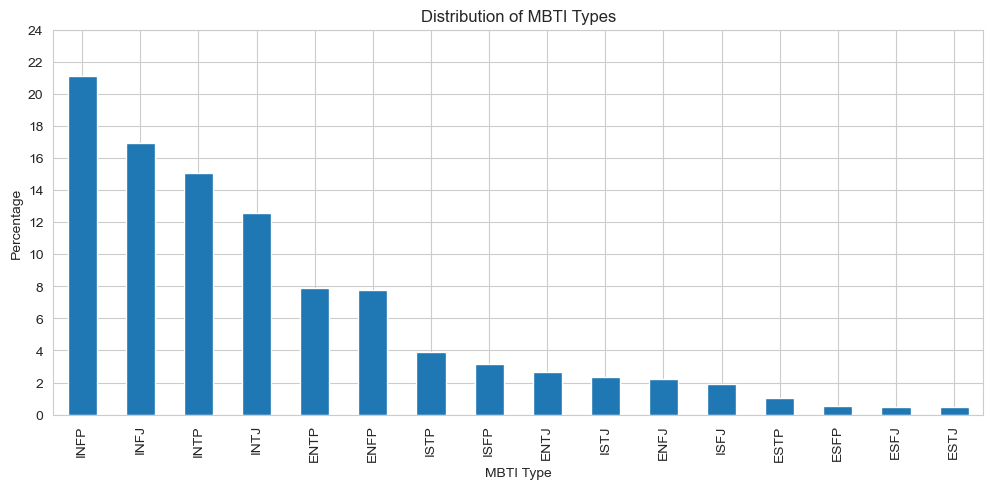

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

type_distribution_pd = (mbti.select("type")
                            .groupBy("type")
                            .count()
                            .withColumn("percentage", F.col("count") / F.lit(mbti.count()) * 100)
                            .toPandas()
                            .sort_values("percentage", ascending=False))

(type_distribution_pd.plot(x="type",
                           y="percentage",
                           kind="bar",
                           legend=False,
                           title="Distribution of MBTI Types",
                           xlabel="MBTI Type",
                           ylabel="Percentage",
                           figsize=(12, 5)));
plt.yticks(ticks=np.arange(0, 26, 2), labels=np.arange(0, 26, 2));

There are exactly 16 different types, all written with capital letters only, just as it should be. 

The **distribution is not balanced** at all, as some type combinations are much less common than others with INFP being the most frequent and ESTJ the most rare ones. This **will bias the models' predictions** towards the most frequent classes if we do not account for that imbalance. 
This **strong imbalance might represent sampling effects**, e.g. individuals with one of the frequent types could be more inclined to write in a forum or accept that their data may be used within a dataset. Nevertheless, since reliable statistics on the types' distribution in the overall population (let alone the global population) are lacking, we cannot confidently assess over- or underrepresentation.

Machine learning needs numerical data, so we have to convert our labels to numerical ones.

In [ ]:
from pyspark.sql import functions as F
from itertools import chain

# store the type_names in a list and use it for creating a dictionary that numerates the types
type_names = [row["type"] for row in mbti.select("type").distinct().orderBy("type").collect()]
type_dict = {type_name: i for i, type_name in enumerate(type_names)}

# create a mapping expression to use the type_dict for every entry in the type column of the dataframe
mapping_expr = F.create_map([F.lit(x) for x in chain(*type_dict.items())])  # chain flattens the dictionary
mbti = mbti.withColumn("type_num", mapping_expr[F.col("type")])

mbti.select("type", "type_num").distinct().orderBy("type_num").show()

+----+--------+
|type|type_num|
+----+--------+
|ENFJ|       0|
|ENFP|       1|
|ENTJ|       2|
|ENTP|       3|
|ESFJ|       4|
|ESFP|       5|
|ESTJ|       6|
|ESTP|       7|
|INFJ|       8|
|INFP|       9|
|INTJ|      10|
|INTP|      11|
|ISFJ|      12|
|ISFP|      13|
|ISTJ|      14|
|ISTP|      15|
+----+--------+



MBTI types consist of 4 **preference pairs** (such as extraversion vs. introversion), each representing a psychological dimension with two poles, and a person is  assumed to lean more to one of these both poles. These preferences are encoded in the four-letter type abbreviations and can be extracted for analysis:

In [ ]:
preferences_names = ['Extraversion', 'Introversion', 'Intuition', 'Sensing',
                     'Thinking', 'Feeling', 'Judging', 'Perceiving']
preferences_abb = ['E', 'I', 'N', 'S', 'T', 'F', 'J', 'P']
pref_dict = {abb: name for abb, name in zip(preferences_abb, preferences_names)}

def target_mapping(df, string_index, preference):
    """Returns a mapping for the four pairs where 1 is assigned if the type matches the first preference of the pair, else 0"""
    target_map = df.withColumn(
        preference,
        F.when(F.col("type").substr(string_index + 1, 1) == preference, 1).otherwise(0)  # +1 for PySpark starting with 1
    )
    return target_map


# Example for the Preference Extraversion (E):
target_mapping(mbti, 0, "E").select("type", "E").distinct().show()

+----+---+
|type|  E|
+----+---+
|INTP|  0|
|INFP|  0|
|ESTP|  1|
|ESFP|  1|
|ESTJ|  1|
|ESFJ|  1|
|INFJ|  0|
|ENTJ|  1|
|ISFP|  0|
|ISTP|  0|
|ISTJ|  0|
|ENTP|  1|
|INTJ|  0|
|ENFJ|  1|
|ENFP|  1|
|ISFJ|  0|
+----+---+



Since I sometimes forget the abbreviations, I also add forms that make the preferences explicit:

In [ ]:
import numpy as np

# create short 0, 1 coded columns for each of the eight preferences with our newly defined target_mapping function:
index_list = [int(i) for i in np.repeat(np.arange(0, 4), 2)]  # int necessary for compatibility with PySpark
for index, preference in zip(index_list, preferences_abb):
    mbti = target_mapping(mbti, index, preference)

# create labels that are more verbose, so we can analyze the data better
preferences_pairs = ["E-I", "N-S", "T-F", "J-P"]
preferences_names = [['Extraversion', 'Introversion'],
                     ['Intuition', 'Sensing'],
                     ['Thinking', 'Feeling'],
                     ['Judging', 'Perceiving']]

for pair, name in zip(preferences_pairs, preferences_names):
    mbti = mbti.withColumn(pair, F.when(F.col(pair[0]) == 1, name[0]).otherwise(name[1]))

# store the label names in an array:
classes = np.array(list(type_dict.keys()))

# show all newly created columns referring on the original type column
mbti.drop("posts", "user_id").distinct().orderBy("type").show()

+----+--------+---+---+---+---+---+---+---+---+------------+---------+--------+----------+
|type|type_num|  E|  I|  N|  S|  T|  F|  J|  P|         E-I|      N-S|     T-F|       J-P|
+----+--------+---+---+---+---+---+---+---+---+------------+---------+--------+----------+
|ENFJ|       0|  1|  0|  1|  0|  0|  1|  1|  0|Extraversion|Intuition| Feeling|   Judging|
|ENFP|       1|  1|  0|  1|  0|  0|  1|  0|  1|Extraversion|Intuition| Feeling|Perceiving|
|ENTJ|       2|  1|  0|  1|  0|  1|  0|  1|  0|Extraversion|Intuition|Thinking|   Judging|
|ENTP|       3|  1|  0|  1|  0|  1|  0|  0|  1|Extraversion|Intuition|Thinking|Perceiving|
|ESFJ|       4|  1|  0|  0|  1|  0|  1|  1|  0|Extraversion|  Sensing| Feeling|   Judging|
|ESFP|       5|  1|  0|  0|  1|  0|  1|  0|  1|Extraversion|  Sensing| Feeling|Perceiving|
|ESTJ|       6|  1|  0|  0|  1|  1|  0|  1|  0|Extraversion|  Sensing|Thinking|   Judging|
|ESTP|       7|  1|  0|  0|  1|  1|  0|  0|  1|Extraversion|  Sensing|Thinking|Perceiving|

Now that we have more explicit categories, we plot the distribution of each preference pair separately:

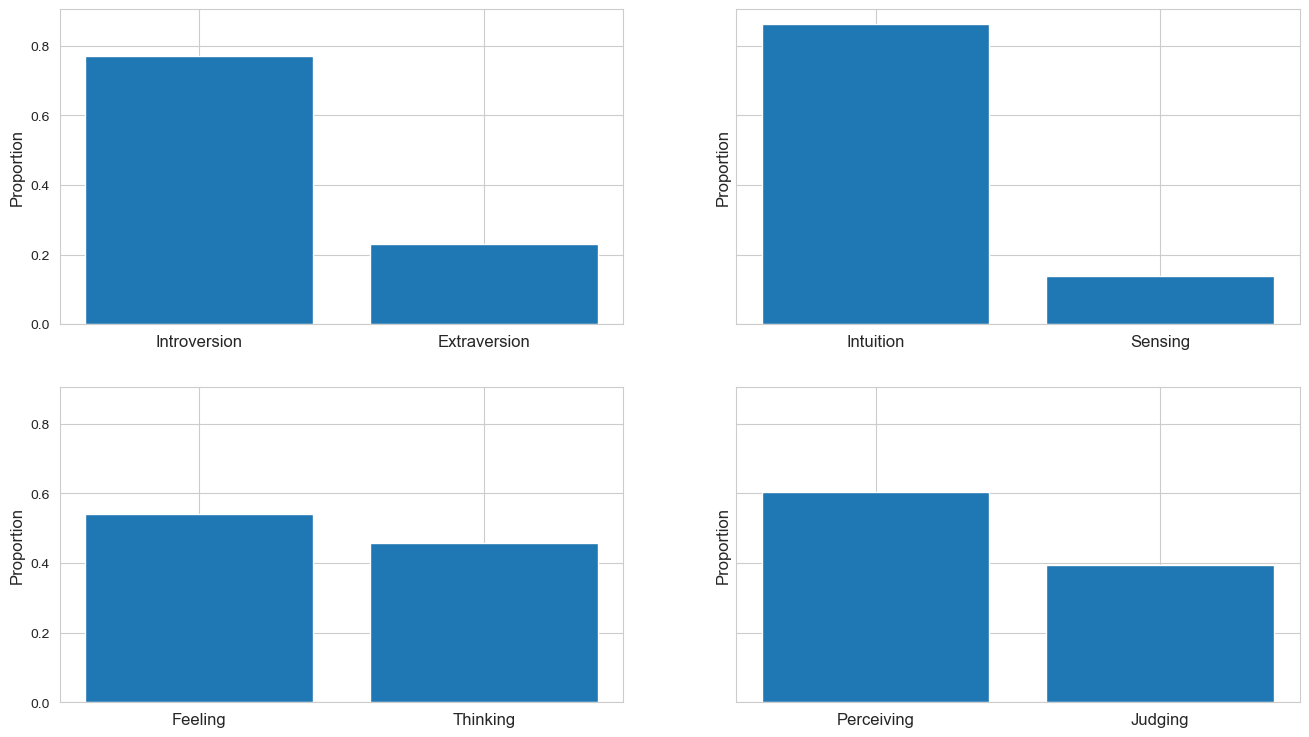

In [ ]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(16, 9))
for (i, ax), pair in zip(np.ndenumerate(axes), preferences_pairs):
    x = mbti.select(pair).toPandas().value_counts(normalize=True).reset_index()[pair]
    y = mbti.select(pair).toPandas().value_counts(normalize=True)
    ax.bar(x, y)
    ax.set_ylabel("Proportion", size=12)
    ax.tick_params(axis='x', labelsize=12)

**Introversion and Intuition are much more common** than their counterparts. This **explains the overall distribution pattern** in the previous plot, where we saw that the types with introversion and intuition are more frequent than those with their respective opposites. This also adds further weight to the assumption that the data might not represent the true distribution of the types. 

We now split the data into train and test sets to avoid data leakage or snooping bias by further exploring the full data.

In [ ]:
from pyspark.sql.window import Window
from typing import Tuple

# to ensure that the distribution of the types stays the same, we define a function for that:
def stratified_split(df: "PySpark.DataFrame" , frac: float, label: str, seed=14) -> Tuple["PySpark.DataFrame", "PySpark.DataFrame"]:
    """Returns a training and a test dataframe stratified by the column specified in label from df with the training dataframe having 
    the size of frac"""
    
    # Calculate exact row count for the train set for each class in label
    label_counts = df.groupBy(label).count()
    sample_counts = label_counts.withColumn("sample_count", (F.col("count") * frac).cast("int"))

    # Join counts back to the original dataframe
    df = df.join(sample_counts.select(label, "sample_count"), on=label)

    # Assign row numbers within each label
    window = Window.partitionBy(label).orderBy(F.rand(seed))
    df = df.withColumn("row_num", F.row_number().over(window))

    # Define train and test and shuffle the data by ordering it by a random number (as it is ordered by partitioned originally)
    train = df.filter(F.col("row_num") <= F.col("sample_count")).drop("row_num", "sample_count").orderBy(F.rand(seed))
    test = df.filter(F.col("row_num") > F.col("sample_count")).drop("row_num", "sample_count").orderBy(F.rand(seed))

    return train, test

# use the function to split the data
train_user, test_user = stratified_split(mbti, 0.8, "type_num")

train_user_size = train_user.count()
test_user_size = test_user.count()

print(f"The resulting training data has a size of {train_user_size} rows and the test data of {test_user_size} rows")

The resulting training data has a size of 6934 rows and the test data of 1741 rows


### Data Frame with Single Posts

To make predictions on single posts we need one row per post not per user. 

In [ ]:
def split_userframe_to_postframe(user_frame):
    post_frame = (
        # create a list with all posts.
        user_frame.withColumn("post", F.split(F.col("posts"), r"\|\|\|"))   # posts are separated by "|||"
        # explode the list
        .withColumn("post", F.explode(F.col("post"))) 
        # create an ID for every post
        .withColumn("post_id", F.monotonically_increasing_id())  
    )
    return post_frame

train = split_userframe_to_postframe(train_user)
test = split_userframe_to_postframe(test_user)

# show the first five rows of the new datasets
print("train:")
train.select("user_id", "posts", "post").limit(5).show(truncate=60)
print(f"train size: {train.count()}\n")
      
print("test:")
test.select("user_id", "posts", "post").limit(5).show(truncate=60)
print(f"test size: {test.count()}")

# we do not need the large post strings anymore, so we drop it
train = train.drop("posts")
test = test.drop("posts")

train:
+-----------+------------------------------------------------------------+------------------------------------------------------------+
|    user_id|                                                       posts|                                                        post|
+-----------+------------------------------------------------------------+------------------------------------------------------------+
|51539608296|'Hi. I'm really messed up. I feel like happiness is impos...|'Hi. I'm really messed up. I feel like happiness is impos...|
|51539608296|'Hi. I'm really messed up. I feel like happiness is impos...|Well then I guess I'm a born loser. I'm not built to tole...|
|51539608296|'Hi. I'm really messed up. I feel like happiness is impos...|There's nothing that I'd actually want from anyone right ...|
|51539608296|'Hi. I'm really messed up. I feel like happiness is impos...|From my experience I'm sure I don't belong in any group.....|
|51539608296|'Hi. I'm really messed up. I

Before proceeding with the data cleaning, we examine the distribution of the number of posts eachc user has written:

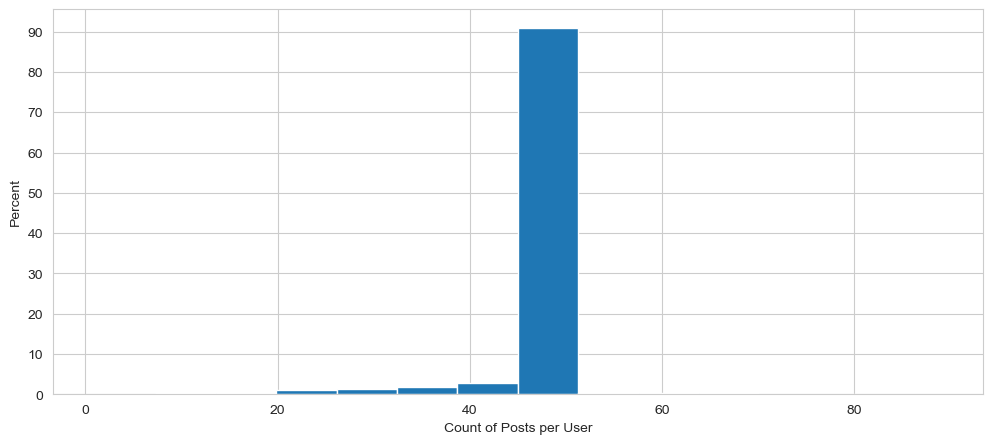

In [ ]:
import seaborn as sns

# histogram of count of the user ids
plt.figure(figsize=(12,5))
sns.histplot(train.select("user_id").groupBy("user_id").count().toPandas()["count"], stat="percent", alpha=1)
plt.xlabel("Count of Posts per User")
plt.yticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10));

The **vast majority of users (around 90%) provide 50 posts** each. 

It is worth to keep in mind that the **posts we are traning the models on are not independent from each other** as they are **not randomly sampled from different individuals** and should share some patterns simply because around 50 of them stem from the same user. However, including the user_id feature in models may make them prone to overfitting and relying too much on it and this would spoil the idea of training on single posts. So I will **refrain from using the user_id for prediction**.

## Data Cleaning

Let us check if there are posts that are empty:

In [ ]:
train.filter(F.col("post") == "").count()

816

**These number of posts do not contain any character and are empty**. We will filter them out later with a minimum of words that a post will have to have in order to get in the final training dataset for the prediction (empyt posts contain only 1 word: "")

### URLs

Since the data comes from an internet forum, it includes a considerable number of URLs. These links can introduce noise into the models and make data inspection more difficult. Because the presence of URLs is both a potential signal and a candidate for removal, we handle them in this hybrid section. We begin by extracting features such as the number of links per post and exploring their potential relevance — including the domains involved. Only after this analysis do we replace all URLs with a placeholder as part of the final data cleaning step.

#### Counting the Number of URLs

In [ ]:
import re

# create a pattern to check for links in the post:
URL_pattern = r"https?\S*|www\.\S*"

# get the number of links in a post
train = (train.withColumn("links_num", 
                         F.size(
                             F.regexp_extract_all(F.col("post"), F.lit(URL_pattern), 0)
                         )))

(train.select("post", "links_num")
    .filter(F.col("links_num")>0)
    .limit(5)
    .show(truncate=120))

+------------------------------------------------------------------------------------------------------------------------+---------+
|                                                                                                                    post|links_num|
+------------------------------------------------------------------------------------------------------------------------+---------+
|http://www.youtube.com/watch?v=Noz6-KaT4fA That's for my girl... You have no idea how she's changed me for the better...|        1|
|                     http://www.youtube.com/watch?v=WEQnzs8wl6E Really I've been practicing this song on guitar all day.|        1|
|http://www.youtube.com/watch?v=LKrUaY6hgpM  http://www.youtube.com/watch?v=qFoWz4fiwCE  http://www.youtube.com/watch?...|        3|
|cow https://67.media.tumblr.com/0917d3698ece425da884cafea9f6f3d0/tumblr_ogbwavMCAY1qewsw4o1_250.gif  I think I tuned ...|        1|
|I wonder if it's just general penchant of Pe-ness. ... Ehehe, read i

#### How Many Links are in the Posts?

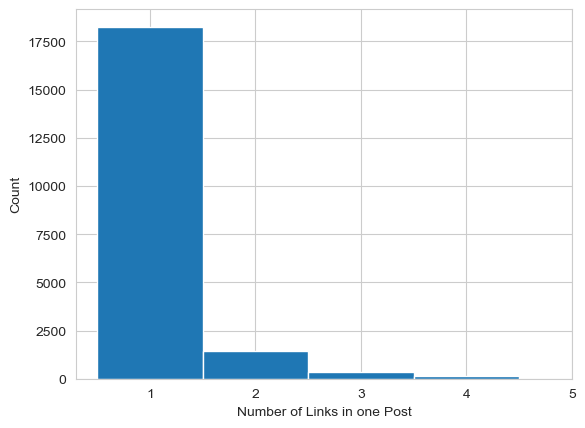

In [ ]:
# to make the plot meaningful filter for ">0"
sns.histplot(train.select("links_num").filter(F.col("links_num") > 0).toPandas()["links_num"],
             binwidth=1,
             alpha=1)
plt.xticks(ticks=np.arange(1.5, 6.5, 1), labels=np.arange(1, 6, 1))
plt.xlabel("Number of Links in one Post");

There are **around 20k posts with links** in the train dataset. If so then it is **only one link in most of the cases**. There are 8 posts with 5 links, which is such a small number that the plot cuts them off. 

So most of the 338k posts do not contain links. That is why I did not show the value for zero links in the plot as it would completely distort the chart and make it useless.

#### Does the Number of Links in a Post Correlate with the Personality Type?

For example, extraverted people may tend to post more links, as they tend to share more of themselves.

Text(0, 0.5, 'Number of Links')

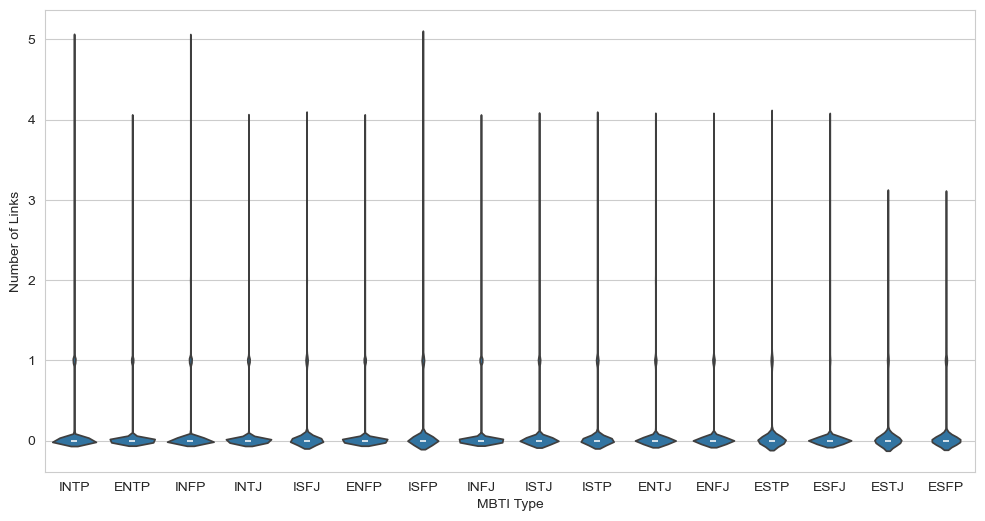

In [ ]:
links_type_pd = train.select("links_num", "type").toPandas()
plt.figure(figsize=(12, 6))
sns.violinplot(links_type_pd, x="type", y="links_num");
plt.xlabel("MBTI Type")
plt.ylabel("Number of Links")

Although we can see some differences in the range of the violin plots (with ESTJ having the shortest), **this plot does not help much**, since all types usually do not contain links in their posts.we are primarily interested in whether we can predict the type from the number of links, and not vice versa (which is why a Kruskal-Wallis test would only help indirectly). Therefore, **analyzing the distribution conditioned on the number of links provides a more direct approach**.

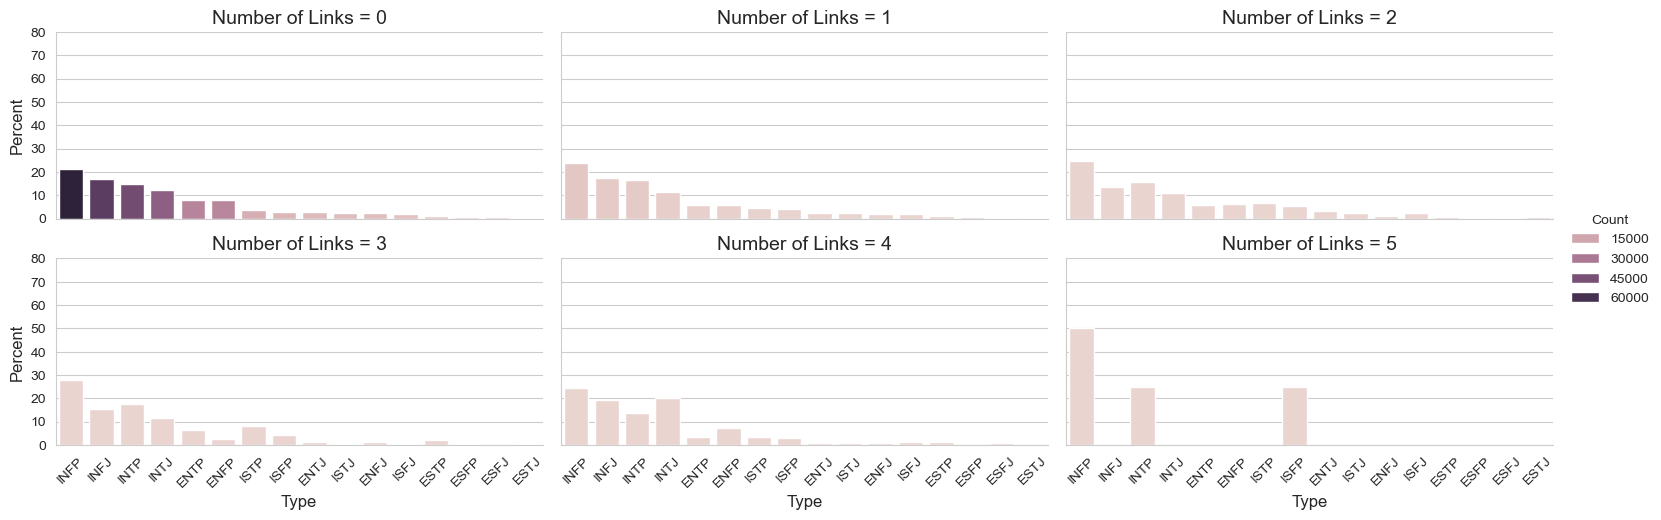

In [ ]:
import pandas as pd

# define a helper function to create the data for the plot, as we will need that a couple of times in the notebook
def conditional_types_dist(df: pd.DataFrame, groupby_col: str) -> pd.DataFrame:
    cond_percents = df.astype(str).groupby([groupby_col]).value_counts(normalize=True).rename("Percent") * 100
    cond_absolutes = df.astype(str).groupby([groupby_col]).value_counts(normalize=False).rename("Count")
    return pd.concat([cond_percents, cond_absolutes], axis=1).reset_index()

links_type_plot_df = conditional_types_dist(links_type_pd, "links_num")

# facet bar plot
g = sns.catplot(links_type_plot_df,
                x="type",
                y="Percent",
                hue="Count",
                col="links_num",
                col_wrap=3,
                kind="bar",
                height=2.5,
                aspect=2.1,
                )

# beautify the plot a bit
num_link_range = range(0, links_type_pd.links_num.max() + 1)

for ax, i in zip(g.axes, num_link_range):
    ax.set_title(f"Number of Links = {i}", size=14)
    ax.set_xlabel("Type", size=12)
    ax.tick_params("x", labelrotation=45)
    ax.set_ylabel("Percent", size=12)
    ax.set_yticks(ticks=np.arange(0, 90, 10), labels=np.arange(0, 90, 10));

**Posts with a higher number of links are increasingly likely to belong to the INFP type.** However, keep in mind that the total **number of posts rapidly decreases as the number of links increases** (as shown by the color in the plot). If we ran a multinomial logistic regression with the number of links as the only regressor for the personality type, the number of links would have a significant effect on some types.

**However, we also see that INFP would always be the safest prediction.** This is no coincidence, as it is the class with the highest overall proportion. The other types, however, are so rare that they cannot even be displayed in the plots. This already indicates that the distribution is too skewed for unweighted machine learning, as models tend to predict the modal category, and emphasizes the need for weighting. However, we will keep this feature as a candidate for our machine learning models for now.

Therefore, we need to define a PySpark transformer for the preprocessing pipeline that adds the number of links to the dataset.

In [ ]:
from pyspark.ml import Transformer

# create the transformers for the pipeline
class CountLinksTransformer(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol,
                                  F.size(
                                      F.regexp_extract_all(F.col(self.inputCol), F.lit(URL_pattern), 0)
                                  )
                                 )

#### Inspecting the URLs

In [ ]:
# create a series with all the links
post_list = [row["post"] for row in train.select("post").collect()]
all_posts = "".join(post_list)
all_links = pd.Series(re.findall(URL_pattern, all_posts))  # a lot smaller then train

from urllib.parse import urlparse

# define a small helper function that returns the domain of an url:
def get_domain(url):
    try:  # if url starts with r"http?://" break up the URL into components
        parsed_url = urlparse(url)
        domain = parsed_url.netloc

        # return the last two segments
        return domain.split(".")[-2] + "." + domain.split(".")[-1]
    except:  # if url starts with www
        try:
            return re.search(r"www\.(\S*)", url).group(1)
        except:
            return "no url:" + url # return a marker that this is not an url to be able to find those entries

all_main_domains = pd.Series([get_domain(link) for link in all_links])

# check the results that could not have been found and got the "no url:" prefix
no_valid_urls = pd.Series([re.findall(r"no url:(\S*)", domain) for domain in all_main_domains])  # returns an empty list, if patern not found
print(no_valid_urls[no_valid_urls.apply(len) > 0])  # show only rows without empty lists, e.g. only those where the no url pattern was found

1656                [http:youtube.com/watch?v=KAveNvDnL_A]
1749     [http://http://personalitycafe.com/intro/48221...
7133                                               [https]
10515                             [http://personalitycafe]
11255    [http://http://i222.photobucket.com/albums/dd2...
14492                                            [http://]
15197    [http://http://personalitycafe.com/enfp-forum-...
16320                                              [https]
16321                                          [https/tls]
16789                                              [http:]
17008    [http[colon]//www[dot]youtube[dot]com/watch?v=...
18870    [http://http://img691.imageshack.us/img691/563...
18871    [http://http://img691.imageshack.us/img691/563...
18872    [http://http://img691.imageshack.us/img691/563...
18873    [http://http://img691.imageshack.us/img691/563...
dtype: object


All shown entries are invalid urls, so the function seems to work correctly

In [ ]:
# these are the top 20 most frequent urls
frequent_domains = all_main_domains.value_counts().iloc[:21]
frequent_domains_names = frequent_domains.index
frequent_domains

youtube.com            11348
youtu.be                 758
imgur.com                643
tumblr.com               624
personalitycafe.com      537
photobucket.com          456
tinypic.com              316
giphy.com                209
fbcdn.net                197
wordpress.com            179
imageshack.us            170
deviantart.net           154
blogspot.com             153
pinimg.com               123
staticflickr.com          96
akamaihd.net              82
tapatalk-cdn.com          78
wikipedia.org             69
gstatic.com               64
wikimedia.org             53
co.uk                     50
Name: count, dtype: int64

Nearly two third of all links refer to youtube. A lot of domains probably only appear seldomly. How often does it happen that a domain gets used once, twice, thrice and so on?

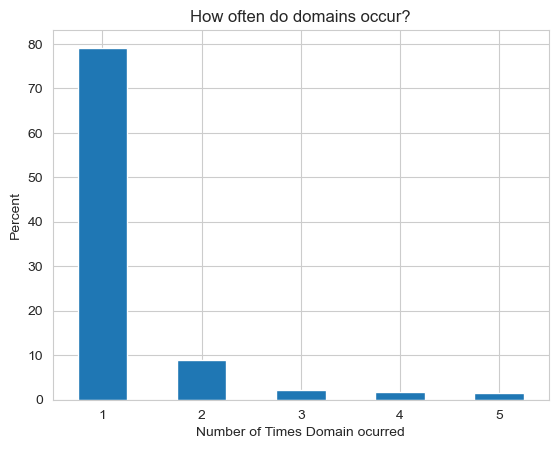

In [ ]:
(all_main_domains.value_counts()  # count how often each domain occurs
      .rename("Number of Times Domain ocurred")
      .value_counts(normalize=True)  # count and normalize how often the count of domains occurs (count the count)
      .sort_index().iloc[:5]
      .plot(kind="bar", title="How often do domains occur?", ylabel="Percent"));
plt.xticks(rotation=0);  # the numbers were rotated
plt.yticks(ticks=np.arange(0, 0.9, 0.1), labels=np.arange(0, 90, 10));

About **78% of the domains appear only once** making it questionable if we can derivate a user's type from the domain, but let us examine it carefully.

#### Is there a Connection between Domain and Type?

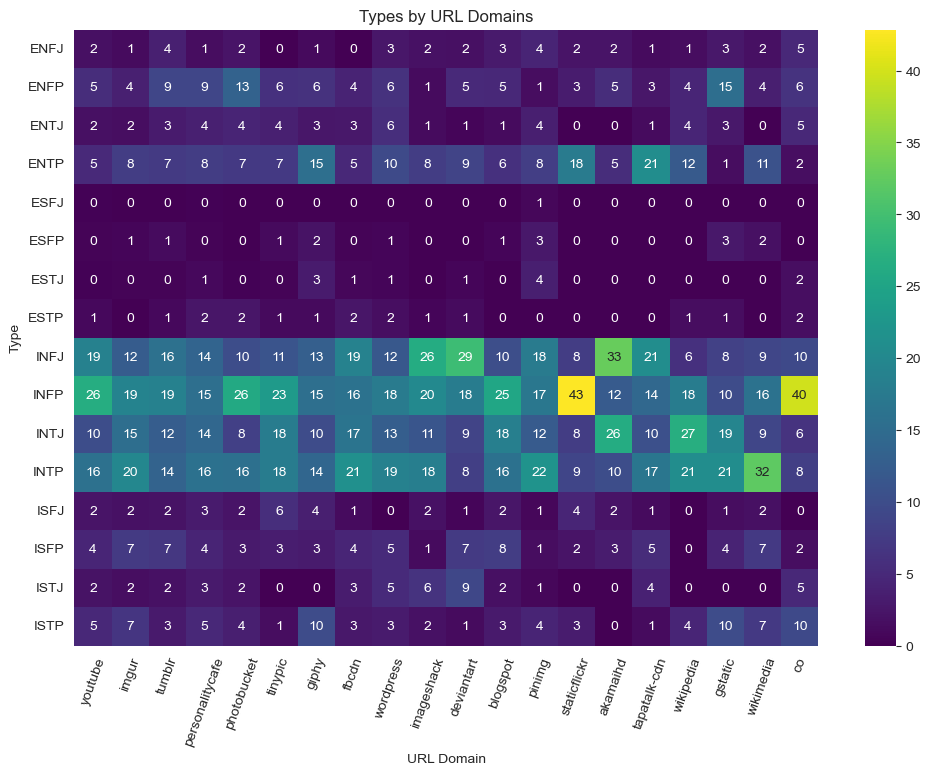

In [ ]:
# create columns that indicate if a domain was used in the post:
# youtube has two domains: "youtube.com" and "youtu.be", so it is treated slightly differently:

types_and_domains = (train.select("type", "post")
                     .withColumn("youtube",
                                 F.regexp_like(F.col("post"),  # regexp_like returns true if in the posts the following pattern is found
                                               F.lit(f"{frequent_domains_names[0]}|{frequent_domains_names[1]}"))  #"youtube" or "youtu"
                                 .cast("int")))  # cast the boolean values to 0 or 1


# for the rest we can define a function for iterating over the domains
def create_domain_column(domain):
    col_name = re.search(r"(\S*)\.", domain).group(1)  # creates the column_name
    return types_and_domains.withColumn(col_name,  # same logic as above
                                        F.regexp_like("post", F.lit(domain))
                                        .cast("int")
                                        )

# now we use this function to iterate over the rest of the domain urls
for domain in frequent_domains_names[2:]:  # excluding the domains for youtube with [2:]
    types_and_domains = create_domain_column(domain)

# we do not use the full posts for our visualization
types_and_domains = types_and_domains.drop("post")

# aggregate the data to a matrix with types in the rows and the domains in the columns for plotting it as a heatmap
tnd = (types_and_domains.groupBy("type")
       .sum()
       .withColumnsRenamed({f"sum({col})": col for col in types_and_domains.columns})  # rename the columns back to their original names
       .toPandas()
       .set_index("type")
       .sort_index()
)

# calculate the percentages for every domain (the distribution of types by domain)
tnd_percent = tnd.div(tnd.sum(axis=0), axis=1) * 100

# plot the resulting percent matrix
sns.set_style("white")
plt.figure(figsize=(12, 8))
sns.heatmap(tnd_percent, annot=True, fmt=".0f", cmap="viridis");
plt.title("Types by URL Domains");
plt.xlabel("URL Domain");
plt.ylabel("Type");
plt.xticks(rotation=70);
plt.yticks(rotation=0);

The resulting matrix shows the relative frequency with which a given domain appears in posts by each MBTI type. For example, the top-left cell indicates that 2% of all YouTube URLs come from posts written by users with the type "ENFJ".

We observe **only small differences across the columns**, which appear visually as **almost horizontal stripes** of similar colors. If the domain had strong predictive power, we would expect more variation — for example, **bright spots scattered across different rows**, not aligned.

Given that most posts don’t contain a URL at all, and when they do, they often just point to YouTube — **with no clear pattern by type** — I decided **not to use the domain as a feature** for classification.

For cleaning the data we also replace URLs in the posts with a placeholder.

#### Replacing the URLs

In [ ]:
# replace the URLs with "WWW" as it usually is not used outside of URLs
train = train.withColumn("cleaned_post", F.regexp_replace("post", URL_pattern, "WWW"))

# define the class for the pipeline
class ReplaceLinksTransformer(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, F.regexp_replace(self.inputCol, URL_pattern, "WWW"))

train.select("post", "cleaned_post").filter(F.regexp_like("post", F.lit(URL_pattern))).show(truncate=55)

+-------------------------------------------------------+-------------------------------------------------------+
|                                                   post|                                           cleaned_post|
+-------------------------------------------------------+-------------------------------------------------------+
|http://www.youtube.com/watch?v=Noz6-KaT4fA That's fo...|WWW That's for my girl... You have no idea how she's...|
|http://www.youtube.com/watch?v=WEQnzs8wl6E Really I'...|WWW Really I've been practicing this song on guitar ...|
|http://www.youtube.com/watch?v=LKrUaY6hgpM  http://w...|                                          WWW  WWW  WWW|
|cow https://67.media.tumblr.com/0917d3698ece425da884...|cow WWW  I think I tuned out most of what K-villain-...|
|I wonder if it's just general penchant of Pe-ness. ....|I wonder if it's just general penchant of Pe-ness. ....|
|Point of personal pride - this colony http://images....|Point of personal pride - this 

### Encoding Patterns, Emojis and Label Leakage

There are some wrong encodings in the posts. First we look at some unicode encoding errors.

In [ ]:
# to check the posts faster, we create a big string with all posts from the cleaned_post column
all_posts_cleaned = [row["cleaned_post"] for row in train.select("cleaned_post").collect()]
all_posts_cleaned = "|||".join(all_posts_cleaned)  # using "|||" as a delimiter

# Unfortunately the wrong encodings do not appear with a preceding "\" what would make them easier to detect
# First we look at some unicode encoding errors
unicode_matches = np.unique(
    re.findall(r"u[0-9A-Fa-f]{4}", all_posts_cleaned))  # regex pattern for unicode
print(unicode_matches)

['u1671' 'u2002' 'u2003' 'u200b' 'u200e' 'u200f' 'u2028' 'u202c' 'u3000'
 'uadab' 'uaded' 'uaeda' 'uba90' 'ubaca' 'ubade' 'ubbed' 'ubfac' 'ucccc'
 'ucced' 'uccee' 'uceed' 'uceee' 'ucefe' 'uda57' 'udbdd' 'udddd' 'uddde'
 'udded' 'ude11' 'ude31' 'ue009' 'ue106' 'ue247' 'ue32e' 'uebea' 'uebec'
 'ued17' 'ueded' 'ueeee' 'uefae' 'uf0b7' 'uf44c' 'uf60a' 'uf60d' 'uface'
 'ufeff' 'uffba' 'uffed' 'uffee' 'uffff']


Some of them are due to wrong encodings but not all. Further we find that there are also windows encoding errors:

In [ ]:
windows_matches = np.unique(
    re.findall(r"x[0-9A-Fa-f]{2}", all_posts_cleaned))  # regex pattern for windows
print(windows_matches)  # even more than unicode_matches

['x01' 'x07' 'x10' 'x11' 'x14' 'x18' 'x19' 'x20' 'x22' 'x23' 'x24' 'x27'
 'x30' 'x36' 'x40' 'x50' 'x56' 'x7f' 'x80' 'x81' 'x83' 'x84' 'x85' 'x86'
 'x90' 'x91' 'x92' 'x93' 'x94' 'x95' 'x96' 'x97' 'x98' 'x99' 'x9a' 'x9b'
 'x9c' 'x9d' 'xCa' 'xDD' 'xE0' 'xFa' 'xaF' 'xaa' 'xab' 'xac' 'xad' 'xaf'
 'xba' 'xbd' 'xbf' 'xc3' 'xc4' 'xc5' 'xca' 'xce' 'xda' 'xde' 'xec' 'xed'
 'xee' 'xf3' 'xf7' 'xfa']


These are also not all due to wrong encodings. But there are also garbled texts, where the decoding must have failed twice:

In [ ]:
garbled_texts = np.unique(re.findall(r"âx[0-9A-Fa-f]{2}x[0-9A-Fa-f]{2}", all_posts_cleaned))  # regex pattern for garbled text
print(garbled_texts)

['âx80x93' 'âx80x94' 'âx80x98' 'âx80x99' 'âx80x9c' 'âx80x9d']


#### Inspecting the posts with wrong encodings

Here is a real example that is not due to encoding error:

In [ ]:
def rows_with_encodings(encoding: str, df=train, nrows: int=5):
    """Returns the posts, that contain the encoding"""
    all_matches = df.filter(F.regexp_like("cleaned_post", F.lit(encoding)))
    return all_matches.select("cleaned_post").limit(nrows).show(truncate=False)

rows_with_encodings('uffed')

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_post                                                                                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id quite like to fall from a high place at around 35 years old, and i should like to be stuffed.                                                                                               |
|this sounds like something my ISTJ friend would do so. ISTJ  TMLT collect stuffed animals as an adult                                                                                          |
|XD I stuffed up the formattin

And examples that contain garbled texts:

In [ ]:
rows_with_encodings("âx80x9c")

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_post                                                                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Fuck Yeah Hannibal, Hugh âx80x9cWee Manâx80x9d Dancy [x] LOLOL                                                                                                            |
|Kilroy Katesith âx80x94 semiunwanted: âx80x9cif you have a bit of stress then...                                                                                          |
|Kilroy Katesith âx80x94 semiunwanted: âx80x9cif you have a bit of stress then...                                                      

Not all of these patterns are really wrong encodings, so we have to check it manually and a helper function would be handy: 

In [ ]:
def show_all_potential_encoding_errors(matches):
    """Returns all posts of every match in matches.
    Makes it easy to inspect all posts with a potential encoding error in groups like unicode_matches"""
    for match in matches:
        print(match)
        print(rows_with_encodings(encoding=match, df=train))

# example of the first two windows patterns "x01" and "x07"
show_all_potential_encoding_errors(windows_matches[:2])

x01
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_post                                                                                                                                                                        |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Not a bad idea! Is there any way you can point me in the right direction, and then maybe a mod (mods, this is for you) can change the title and remove that first part?   x01660    |
|That this is a healine:  Kim K's post-baby body a mystery   :   x01660                                                                                                              |
|I am planning on writing a series of articles, and that will make it easier for 

Checking all the found possible encodings involves a lot of output so I leave that output as an example. If we do so, we find also some patterns like :tongue: or :dry: that seem to be representations of emojis which we are going to examine now.

#### Emojis

In [ ]:
# create a simple pattern for the emojis
emoji_pattern = r":\w+:"

possible_emojis = np.unique(re.findall(emoji_pattern, all_posts_cleaned))

# they are a lot so here the first 40
possible_emojis[:40]

array([':03:', ':10:', ':11S:', ':16:', ':1892:', ':19:', ':30:', ':32:',
       ':33:', ':3:', ':40:', ':46:', ':58:', ':7:', ':88J:', ':Amazon:',
       ':CAN:', ':D:', ':DR:', ':EPIC:', ':L:', ':Shrugs:', ':Smilies1:',
       ':Smilies3:', ':Smilies:', ':Wink:', ':adjoint:', ':adoration:',
       ':ambivalence:', ':angel:', ':angry:', ':annoyed:', ':anonymous:',
       ':anyone:', ':applause:', ':applouse:', ':apthy:', ':astonished:',
       ':ball:', ':beguiled:'], dtype='<U30')

Some of these combinations are not emojis at all. Here is an example that is not an emoji but part of a duration:

In [ ]:
train.filter(F.regexp_like(F.col("cleaned_post"), F.lit(":10:"))).select("user_id", "cleaned_post").show(truncate=False)

+-----------+-----------------------------------------------------------------------+
|user_id    |cleaned_post                                                           |
+-----------+-----------------------------------------------------------------------+
|17179869856|A very enthusiastic conductor. He really gets going around ~2:10:   WWW|
+-----------+-----------------------------------------------------------------------+



**We need to exclude these patterns from our regex patterns.** We could handle this via a dictionary, but the following approach is more efficient, as we replace all matches with the same universal placeholder.

In [ ]:
# a collection of patterns of the emoji list, that do not represent emojis
no_emojis = [r"\d{1,2}\w?:",  # combinations with only 2 digits only or 2 digits followed by a letter. But 4 digits (:1892:) seem to be valid
             "D:",  # is the :D smiley
             "Amazon:",  # normal sentence
             "CAN:",  # normal sentence
             "DR:",  # typo in TL:DR:
             "EPIC",  # normal sentence
             "GryffindorIstj:",  # typo
             "d:",  # :d smiley
             "i:",  # refers to "introversion"
             "iconsonicheart707:",  # typo
             "p:",  # refers to "perception"
             "r:",  # normal sentence
             "t:"]  # refers to "thinking"

# create negative lookaheads to make sure the elements of the previously created list are not taken into account
no_emojis_negative_lookaheads = "".join(["(?!" + no_emoji + ")" for no_emoji in no_emojis])

# build the full pattern
corrected_emoji_pattern = ":" + no_emojis_negative_lookaheads + r"\w+:"

corrected_emoji_pattern

':(?!\\d{1,2}\\w?:)(?!D:)(?!Amazon:)(?!CAN:)(?!DR:)(?!EPIC)(?!GryffindorIstj:)(?!d:)(?!i:)(?!iconsonicheart707:)(?!p:)(?!r:)(?!t:)\\w+:'

That is how our final pattern to detect emojis looks like.

In [ ]:
emojis = np.unique(re.findall(corrected_emoji_pattern, all_posts_cleaned))
emojis[:40]

array([':1892:', ':L:', ':Shrugs:', ':Smilies1:', ':Smilies3:',
       ':Smilies:', ':Wink:', ':adjoint:', ':adoration:', ':ambivalence:',
       ':angel:', ':angry:', ':annoyed:', ':anonymous:', ':anyone:',
       ':applause:', ':applouse:', ':apthy:', ':astonished:', ':ball:',
       ':beguiled:', ':biggrin:', ':black_eyed:', ':blue:', ':blush:',
       ':blushed:', ':bored:', ':brocoli:', ':butterfly:', ':bwink:',
       ':carrot:', ':chargrined:', ':chat02:', ':cheerful:', ':cheers2:',
       ':chuncky:', ':cold:', ':computer:', ':concern:', ':confused2:'],
      dtype='<U30')

In [ ]:
train.filter(F.regexp_like(F.col("cleaned_post"), F.lit(corrected_emoji_pattern))).count()

14995

**Nearly 15,000 posts contain these emoji patterns.** We replace them with a single character sequence, "<EMOJI>", as this information should be sufficient for the models.

#### Personality Types

Sometimes, users also talked about their own types and differences to others and mentioned the type's name. While this appears harmless at first, we can see that models attempt to infer the author's personality type based on the mentioned types. In cases where the author reveals their own type in a post, this even **introduces data leakage**, as it effectively exposes the label. Furthermore, this kind of conversation is quite **specific to this website**, so **replacing type names with a more general token forces the model to learn more abstract patterns** instead of relying on individual type names.

Here is an example illustrating that the type "ENFJ" is mostly used by authors with this or similar types, making it a fairly strong predictor for this class. The same holds true for other types.

In [ ]:
(train.filter(F.regexp_like(F.col("cleaned_post"), F.lit("ENFJ")))
 .select("type")
 .groupby("type")
 .count()
 .orderBy("count", ascending=False)
 .show())

+----+-----+
|type|count|
+----+-----+
|ENFJ|  753|
|INFP|  623|
|INFJ|  604|
|ENFP|  309|
|INTP|  270|
|ENTP|  220|
|INTJ|  198|
|ISFP|   82|
|ENTJ|   79|
|ISTP|   77|
|ISFJ|   63|
|ISTJ|   47|
|ESTP|   32|
|ESFJ|   29|
|ESFP|   17|
|ESTJ|    2|
+----+-----+



Now we build a universal pattern in order to detect them and then replace them.

In [ ]:
# create a pattern that covers all type combinations
mbti_types_pattern = "[ei][ns][tf][jp]"

# find all matching patterns, ignoring the case as the users did not use capital letters only
mbti_types = np.unique(re.findall(mbti_types_pattern, all_posts_cleaned, flags=re.IGNORECASE))

mbti_types

array(['ENFJ', 'ENFP', 'ENFj', 'ENFp', 'ENTJ', 'ENTP', 'ENTj', 'ENTp',
       'ENfJ', 'ENfP', 'ENtP', 'ENtp', 'ESFJ', 'ESFP', 'ESFj', 'ESFp',
       'ESTJ', 'ESTP', 'ESTj', 'ESTp', 'EStP', 'EnFP', 'EnTP', 'Enfj',
       'Enfp', 'Entj', 'Entp', 'Esfj', 'Esfp', 'Estj', 'Estp', 'INFJ',
       'INFP', 'INFj', 'INFp', 'INTJ', 'INTP', 'INTj', 'INTp', 'INfJ',
       'INfP', 'INfj', 'INtJ', 'INtP', 'ISFJ', 'ISFP', 'ISFj', 'ISFp',
       'ISTJ', 'ISTP', 'ISTj', 'ISTp', 'ISfJ', 'ISfp', 'InFJ', 'InFP',
       'Infj', 'Infp', 'Intj', 'Intp', 'IsFP', 'IsTJ', 'Isfj', 'Isfp',
       'Istj', 'Istp', 'eNFJ', 'eNFP', 'eNTp', 'eNfp', 'eSTP', 'enFP',
       'enFp', 'enfJ', 'enfP', 'enfj', 'enfp', 'entj', 'entp', 'esfJ',
       'esfj', 'esfp', 'estP', 'estj', 'estp', 'iNFJ', 'iNFP', 'iNFj',
       'iNFp', 'iNTJ', 'iNTP', 'iNTj', 'iNTp', 'iNfJ', 'iNfj', 'iSFJ',
       'iSFp', 'iSTJ', 'iSfP', 'iSfj', 'inFj', 'infJ', 'infP', 'infj',
       'infp', 'intP', 'intj', 'intp', 'isFj', 'isFp', 'isTj', 'isTp',
      

We can see that there are all possible combinations of upper and lower case involved, which makes the universal pattern sensible.

We can now clean the data using all the mentioned replacements.

#### Replacing Truely Wrong Encodings, Emojis and MBTI Types

In [ ]:
# create dictionaries for replacements.
# start with the garbled texts, as parts of them can also be interpreted as windows encodings (e.g. "x93")
# so they get their own dictionary
garbled_text_replacements = {
    "âx80x93": "-",  # en dash
    "âx80x94": "-",  # em dash
    "âx80x98": "'",  # left single quote
    "âx80x99": "'",  # right single quote/apostrophe
    "âx80x9c": '"',  # left double quote
    "âx80x9d": '"',  # right double quote
}

# use the new dictionary on the data to replace the garbled texts
for key, value in garbled_text_replacements.items():
    train = train.withColumn("cleaned_post", F.regexp_replace("cleaned_post", key, value))


# for the rest of the bad encodings we can create just one more dictionary, we start with a single meaningless sequence of characters
replacements = {"x01660": ""}  # unclear what it is, but can be deleted

# create a dict for the unicode encodings
unicode_replacements = {
    'u1671': '',  # obscure one: Syllabic character used in certain Canadian Indigenous scripts???
    'u2002': ' ',  # En space
    'u2003': ' ',  # Em space
    'u200b': '',  # Zero-width space
    'u200e': '',  # Left-to-right mark
    'u200f': '',  # Right-to-left mark
    'u2028': '\n',  # Line separator
    'u202c': '',  # Pop directional formatting
    'u2431': ' ',  # Record separator
    'u3000': ' ',  # Full-width space
    'ue106': '',  # private use area
    'ue32e': '',  # private use area
    'uf0b7': '',  # private use area
    'uf44c': '',  # private use area
    'uf609': '',  # smiley face
    'uf60a': '',  # face with heart eyes
    'uf60d': '',  # face with heart kiss
    'ufeff': '',  # Zero-width no-break space (BOM)
    'uffff': ''  # Reserved placeholder
}

# append the entries of unicode replacements to our replacements dictionary
replacements.update(unicode_replacements)

# and now a dictionary for the windows encodings
windows_replacements = {
    'x7f': '',
    'x85': '\n',  # originally it is \n but this occurs only once
    'x91': "'",
    'x92': "'",
    'x93': '"',
    'x94': '"',
    'x95': '•',  # bulletpoints maybe replace them just with ''
    'x96': '–',
    'x97': '—',
    'x98': '˜',  # should be erased with garbled text replacements
    'x99': '™',  # only one occurence, the rest should be erased with garbled text replacements
    'x9c': 'œ',  # yes, was really used in some sentences, one of it uses the French word "cœur"
    'x9d': ''
}

# append the windows encodings to our replacements dictionary, too
replacements.update(windows_replacements)

# now we can use the replacement dictionary on the data in one go for the econdings, emojis and the mbti types
for key, value in replacements.items():
    train = train.withColumn("cleaned_post", F.regexp_replace("cleaned_post", key, value))

# replace the emoji patterns in one go with the regex pattern
train = train.withColumn("cleaned_post",
                         F.regexp_replace(F.col("cleaned_post"), F.lit(corrected_emoji_pattern), " EMOJI "))
# leading and following whitespace after the replacement as emojis sometimes occur directly after a sentence. We will
# trim multiple whitespaces to a single one later, so this is safe

# replace the mbti types in one go with the regex pattern
train = train.withColumn("cleaned_post", F.regexp_replace("cleaned_post", "(?i)" + mbti_types_pattern, "MBTITYPE"))
# adding "(?i)" at the beginning makes ignore the case

# an example for the check on the freshly cleaned posts also including emojis
train.select("post", "cleaned_post").filter(F.regexp_like(F.col("post"), F.lit("x01660"))).limit(5).show(truncate=False)

# Other examples would be:
#train.select("post", "cleaned_post").filter(F.regexp_like(F.col("post"), F.lit("u2002"))).limit(5).show(truncate=False)
#train.select("post", "cleaned_post").filter(F.regexp_like(F.col("post"), F.lit("x7f"))).limit(5).show(truncate=False)
#train.select("post", "cleaned_post").filter(F.regexp_like(F.col("post"), F.lit(":tongue:"))).limit(5).show(truncate=False)
#train.select("post", "cleaned_post").filter(F.regexp_like(F.col("post"), F.lit("ENFJ"))).show()

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|post                                                                                                                                                                                |cleaned_post                                                                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------

#### HTML Encodings

Finally, we also have some HTML escape sequences in some posts. Here is an example of the sequence "&amp;":

In [ ]:
train.select("cleaned_post").filter(F.regexp_like(F.col("cleaned_post"), F.lit(" &amp; "))).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_post                                                                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Calling all MBTITYPEs I really need your help!  In middle school and high school (I am now MBTITYPE19) I was pretty familar with who I was. There was this guy MBTITYPE (15-18) &amp; immature emotionally. He ripped...|
+---------------------------------------------------------------------------------------------------------------------------

However, **we can replace them in one go** using the `html` package, as they are defined properly (unlike the Windows or Unicode encodings)

In [ ]:
import html
from pyspark.sql.types import StringType

# create a small helper function to replace the html entities automatically
def unescape_html(text):
    return html.unescape(text)

# create a user defined function with unescape_html
unescape_html_udf = F.udf(unescape_html, StringType())

# apply this udf on the data
train = train.withColumn("cleaned_post", unescape_html_udf("cleaned_post"))

There are also some hidden whitespaces that we should remove:

In [ ]:
train = train.withColumn("cleaned_post", F.trim(F.regexp_replace("cleaned_post", F.lit(r"\s+"), " ")))

We pack all the encoding, emoji handling, HTML replacement, and trimming into one Transformer class for the pipeline:

In [ ]:
class CleanEncodingHtmlTransformer(Transformer):
    def __init__(self, inputCol):
        super().__init__()
        self.inputCol = inputCol

    def _transform(self, dataset):
        # replace garbled text
        for key, value in garbled_text_replacements.items():
            dataset = dataset.withColumn(self.inputCol, F.regexp_replace(self.inputCol, key, value))

        # replace windows and unicode encodings
        for key, value in replacements.items():
            dataset = dataset.withColumn(self.inputCol, F.regexp_replace(self.inputCol, key, value))

        # replace the emojis
        dataset = dataset.withColumn(self.inputCol,
                                     F.regexp_replace(F.col(self.inputCol), F.lit(corrected_emoji_pattern), " EMOJI "))

        # replace the mbti types
        dataset = dataset.withColumn(self.inputCol,
                                     F.regexp_replace(self.inputCol, "(?i)" + mbti_types_pattern, "MBTITYPE"))

        dataset = dataset.withColumn(self.inputCol, unescape_html_udf(self.inputCol))
        return dataset.withColumn(self.inputCol, F.trim(F.regexp_replace(self.inputCol, F.lit(r"\s+"), " ")))

In [ ]:
train = train.repartition(24)  # repartition the data after all those transformations

Having cleaned up our data we can now begin to do some feature engineering. We start with the number of words a post contains.

## Feature Engineering

### Number of Words

First we want to know how many distinct words are used to estimate the size of the vocabulary:

In [ ]:
# split the cleaned post into words and explode them into separate rows
word_df = train.withColumn("word", F.explode(F.split(F.col("cleaned_post"), " "))).select("word")

# size of the vocabulary
word_df.count()

8822825

The vocabulary is quite large, as the posts cover a wide range of topics:

In [ ]:
# get the unique words and their counts
unique_words = word_df.groupBy("word").count().sort(F.desc("count"))

# show the 20 most frequent words, they should be very usual and generic
unique_words.limit(20).show()

+----+------+
|word| count|
+----+------+
|   I|369429|
|  to|231219|
| the|216362|
|   a|184106|
| and|175330|
|  of|142121|
| you|103371|
|  is|102824|
|that|101540|
|  in| 93842|
|  my| 83807|
|  it| 74734|
| for| 66309|
|have| 63546|
|with| 61733|
| but| 59631|
| I'm| 56382|
|  be| 55223|
| are| 51913|
|like| 49015|
+----+------+



As expected, these words are quite generic, but their usage may be associated to certain personality types. 

Since the words carry a lot of information, we need to know how evenly distributed the number of words is, i.e., how much potential information each post contains: 

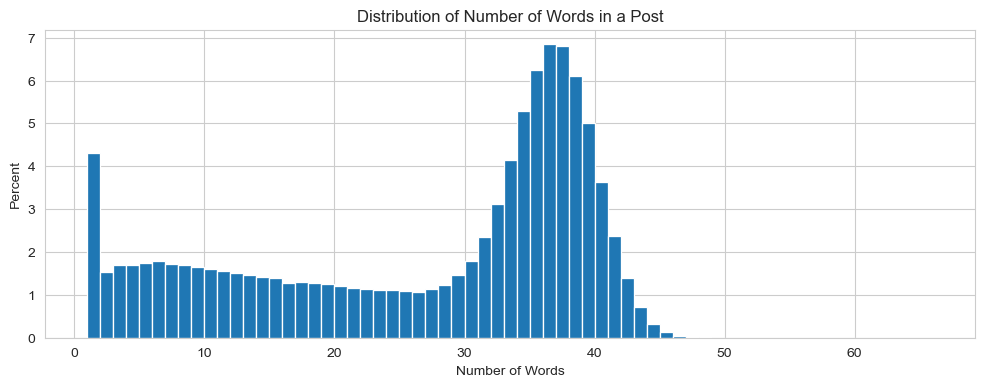

In [ ]:
# create a column that counts the number of words per post
train = train.withColumn("words_num", F.size(F.split(F.col("cleaned_post"), " ")))

# convert a part of the data to pandas for visualization
words_type_pd = train.select("words_num", "type").toPandas()

sns.set_style("whitegrid")

plt.figure(figsize=(12, 4))
sns.histplot(words_type_pd.words_num, stat="percent", binwidth=1, alpha=1);
plt.title("Distribution of Number of Words in a Post");
plt.xlabel("Number of Words");

Most of the posts consist of **30 to 40 words**. There is also a relatively **large proportion of posts that contain only a single word**. We **filter these out later**, as they carry too little information and cannot be considered full sentences. Most of these single-word posts are simple links.

We will see later that **we only received approximately the first 200 characters per post in the original dataframe**, so we should not overinterpret the sharp decline at the right tail; it represents an artifact.

For modeling, we need to know how well we can infer a user's type from the number of words, so we analyze this relationship a bit further.

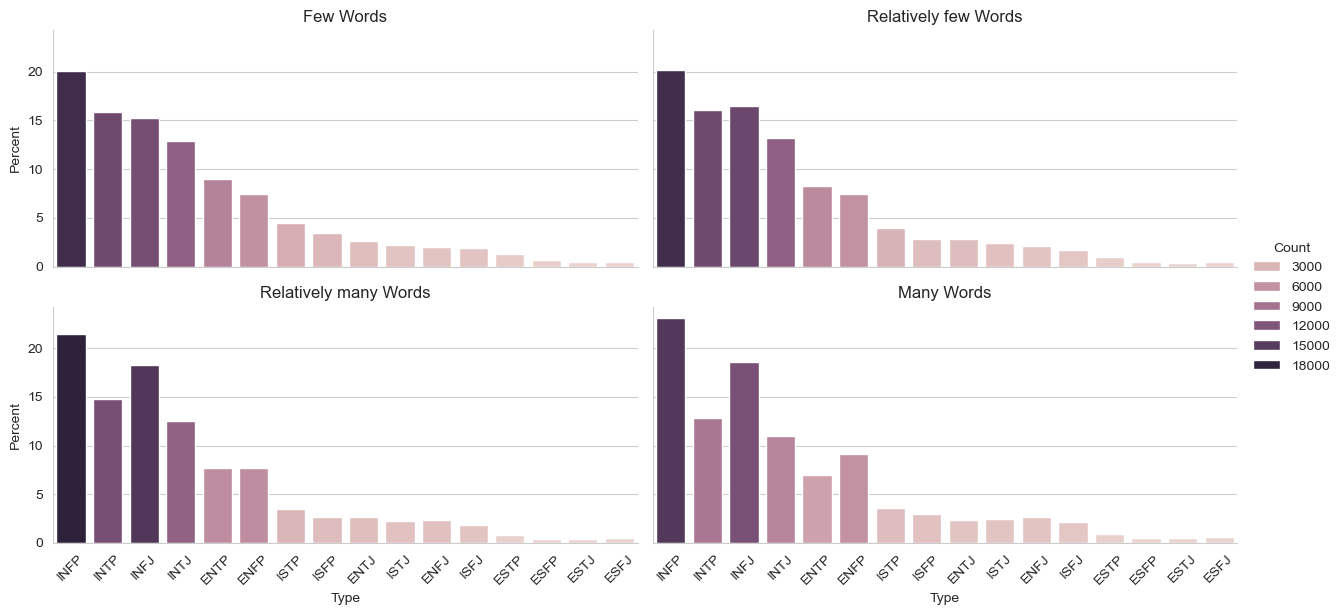

In [ ]:
# create a pandas dataframe for visualization
words_type_pd = train.select("words_num", "type").toPandas()

# define the labels for the cut feature
words_num_bins_labels = ["Few Words", "Relatively few Words", "Relatively many Words", "Many Words"]

# define a helper function to create a categorised series, as we will use this a couple of times
def make_conditional_histplots(df: pd.DataFrame, bin_col: str, bin_labels: list) -> pd.Series:
    bins = df[bin_col].describe().loc["min":"max"].values
    new_col = bin_col + "_cut"
    df = df.copy()
    df[new_col] = pd.cut(df[bin_col], bins=bins, labels=bin_labels, include_lowest=True)

    # use our helper function from before
    plot_df = conditional_types_dist(df[[new_col, "type"]], new_col)
    labels_order = df[new_col].cat.categories.values

    g = sns.catplot(plot_df,
                    x="type",
                    y="Percent",
                    hue="Count",
                    col=new_col,
                    col_wrap=2,
                    col_order=labels_order,
                    kind="bar",
                    height=3,
                    aspect=2.1
                   );

    for (ax, label) in zip(g.axes, labels_order):
        ax.set_title(label, size=12)
        ax.set_xlabel("Type")
        ax.tick_params(axis="x", labelrotation=45)

make_conditional_histplots(words_type_pd.loc[words_type_pd.words_num >= 3],
                           "words_num",
                           words_num_bins_labels)

There is a **steady decline in the plot for posts with few words**, but this pattern breaks as the number of words increases, resulting in a **zigzag decline for longer posts among the first six types**. Therefore, using the number of words may help to predict these types. The probability for INFJ increases with longer posts, as it does for ESFJ (the type in the right corner), while the probability for INTP decreases slightly for longer posts. The pattern is not always linear, and the effect does not appear to be strong, especially for the last ten types (which are also relatively rare). However, we will test various models and check whether this variable contributes to predictive performance.

For now, we create a Pipeline Transformer to count the number of words.

In [ ]:
class WordsNumTransformer(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, F.size(F.split(F.col(self.inputCol), " ")))

And then a transformer for the pipeline to filter out posts that are too short

In [ ]:
class WordFilterTransformer(Transformer):
    def __init__(self, inputCol, minWords):
        super().__init__()
        self.inputCol = inputCol
        self.minWords = minWords

    def _transform(self, dataset):
        return dataset.filter(F.col(self.inputCol) >= self.minWords)

### Number of Characters

In [ ]:
# count the number of characters
train = train.withColumn("chars_num", F.length(F.col("cleaned_post")))

# create a small pandas dataframe for visualization
chars_type_pd = train.select("chars_num", "type").toPandas()

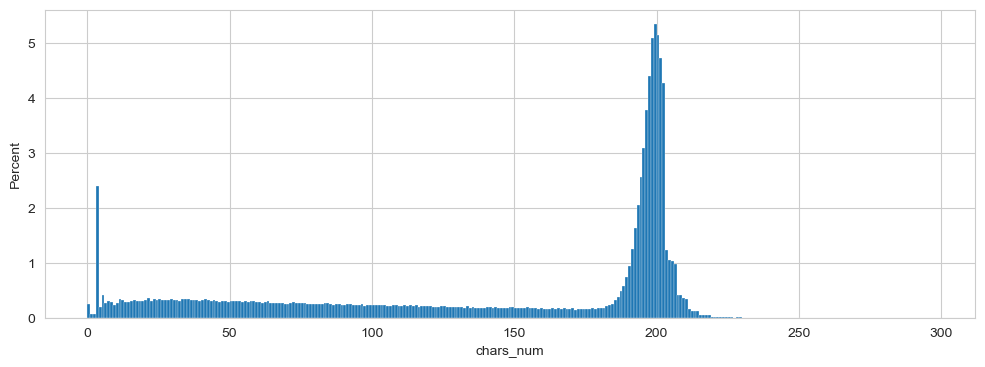

In [ ]:
plt.figure(figsize=(12, 4))
sns.histplot(chars_type_pd.chars_num, binwidth=1, stat="percent", alpha=1);

This distribution strongly **resembles the one of the number of words** of a post. This is no coincidence, as the number of characters increases with increasing numbers of words. There is a **peak at the lower end** which is because of the **links' placeholder "WWW"**. 

When we analyze the posts with 190+ characters, it seems that the number of characters was limited to 200 and when the post exceeded this limit it was cut to the last word within the 200 chars limit and the rest was omitted, adding three dots at the post's end to indicate the omission. This suggestion is based on the fact that the frequency of the 3 dots at the end gets smaller the lower the number of characters is under 200.

However the posts with over 230 characters become more and more cryptic and end up in lists of the types of characters and persons:

In [ ]:
train.filter((F.col("chars_num") >= 231)).orderBy("chars_num").select("cleaned_post", "chars_num").show(20, truncate=120)

+------------------------------------------------------------------------------------------------------------------------+---------+
|                                                                                                            cleaned_post|chars_num|
+------------------------------------------------------------------------------------------------------------------------+---------+
|Mother (MBTITYPE) + Father (MBTITYPE) = Me (MBTITYPE) Maternal side: grandmother (MBTITYPE) + grandfather (MBTITYPE) ...|      231|
|preferences for romance: MBTITYPE, MBTITYPE, MBTITYPE, MBTITYPE. but MBTITYPE way out in front . Friends: as above bu...|      231|
|Your type: MBTITYPE Mom's type: MBTITYPE Dad's type: MBTITYPE Siblings' type(s): MBTITYPE Best friends' type(s): I ha...|      231|
|Your type: MBTITYPE Mom's type: MBTITYPE Dad's type: MBTITYPE Siblings' type(s): MBTITYPE Best friends' type(s): MBTI...|      232|
|Best Friends: MBTITYPE, MBTITYPE, MBTITYPE, MBTITYPE, MBTITYPE Dad: 

In [ ]:
train.select("cleaned_post", "chars_num").filter((F.col("chars_num") >= 231)).count()

46

So we will filter out these rows to reduce some noise.

Similar to the number of words, we also want to analyze the relationship between the number of characters and the types:

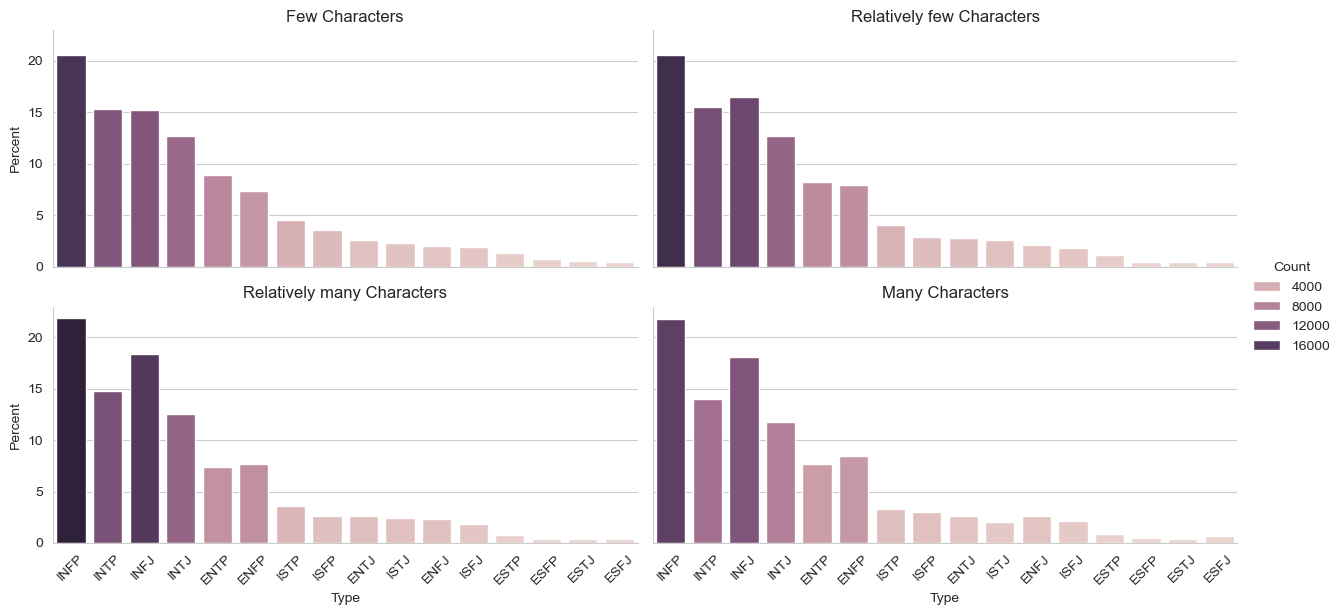

In [ ]:
# the procedure is the same as the one for the word count
chars_num_bin_labels = ["Few Characters", "Relatively few Characters", "Relatively many Characters", "Many Characters"]

make_conditional_histplots(chars_type_pd.loc[chars_type_pd.chars_num > 3],  # filter the peak out
                           "chars_num",
                           chars_num_bin_labels)

This **does resemble the distribution of the conditioned distribution of the types on the binned numbers of words**. We will have to check later which of these features holds more information.

Here comes the corresponding transformer:

In [ ]:
class CharsNumTransformer(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, F.length(F.col(self.inputCol)))

In [ ]:
class CharsFilterTransformer(Transformer):
    def __init__(self, inputCol, maxChars):
        super().__init__()
        self.inputCol = inputCol
        self.maxChars = maxChars

    def _transform(self, dataset):
        return dataset.filter(F.col(self.inputCol) <= self.maxChars)

### Characters per Word Ratio

Some types may prefer longer words. For example, Latin or Greek words tend to be longer than English words:

In [ ]:
# calculate the ratio
train = train.withColumn("chars_per_word", F.col("chars_num") / F.col("words_num"))

# create a pandas df for visualization
chars_per_word_type_pd = train.select("type", "chars_per_word").toPandas()

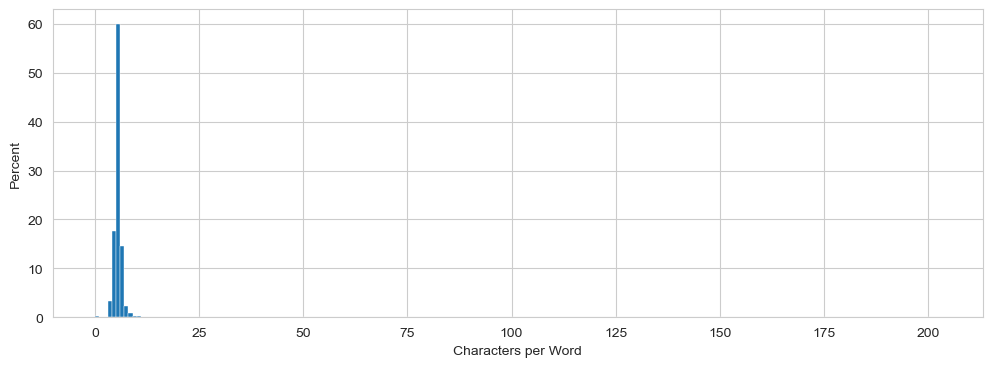

In [ ]:
plt.figure(figsize=(12, 4))
sns.histplot(chars_per_word_type_pd.chars_per_word, binwidth=1, stat="percent", alpha=1);
plt.xlabel("Characters per Word");

The majority of the posts contain **5 to 7 characters per word**. However, there are also very small counts for posts consisting of a single word with up to 200 characters, which is why the x-axis ticks extend up to 200.

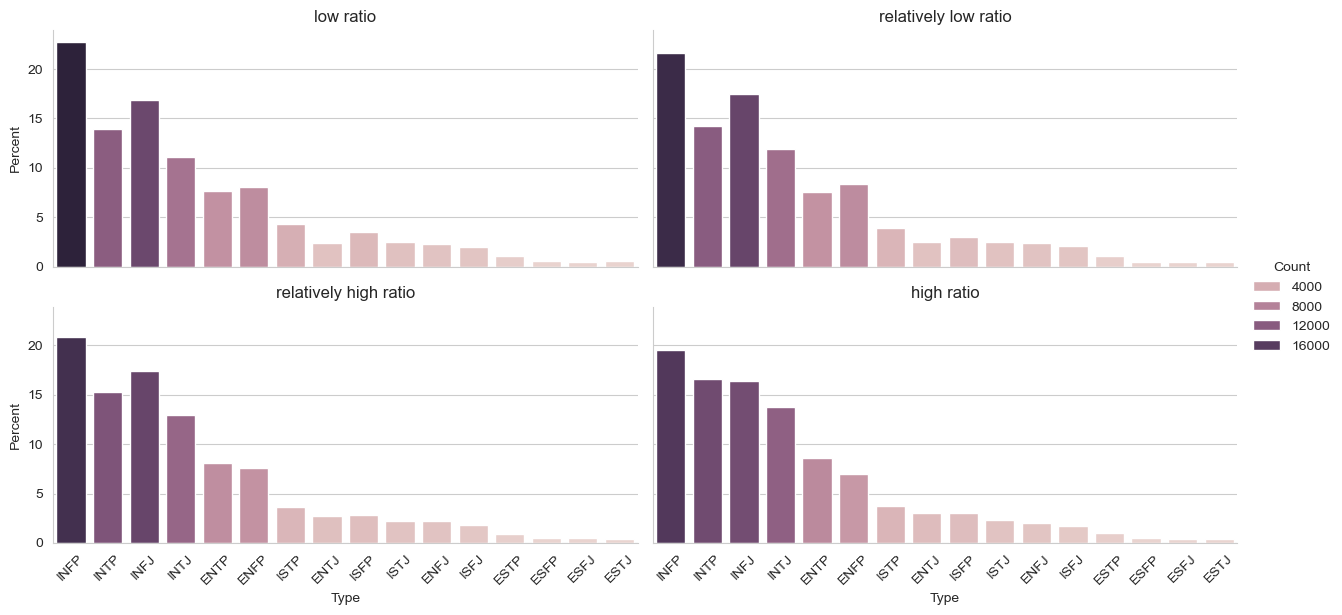

In [ ]:
char_word_ratio_bin_labels = ["low ratio", "relatively low ratio", "relatively high ratio", "high ratio"]

make_conditional_histplots(chars_per_word_type_pd,
                           "chars_per_word",
                           char_word_ratio_bin_labels)

These distributions **show more of a zigzag pattern, except when the ratio is high**. All three features (number of words, number of characters, and the character-word ratio) may be redundant, as they could carry similar information, but we will test that later.

Here is the transformer class for the ratio:

In [ ]:
class RatioTransformer(Transformer):
    def __init__(self, inputNumeratorCol, inputDenominatorCol, outputCol):
        super().__init__()
        self.inputNumeratorCol = inputNumeratorCol
        self.inputDenominatorCol = inputDenominatorCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, F.col(self.inputNumeratorCol) / F.col(self.inputDenominatorCol))

Now that we have stored some information about the raw posts, we normalize the data to make it easier for classical machine learning models to detect patterns.

## Text Normalization

### Punctuation Removal

We remove most punctuation, as it adds noise that models based on word frequencies could pick up. But we want to keep some: the apostrophe (as in I'm) and the hyphen between two words, to make lemmatization easier.

In [ ]:
# we want to keep the apostroph in "I'm" or the hyphen in "self-esteem" for correct lemmatization but we want to remove
# hyphens that are repeated, separate sentences or at the beginning of a sentence
punctuation_pattern = r"[^a-zA-Z0-9\s'-]|\s*-\s+|\s+-\s*|-{2,}"

train = (train
         # we need " " as replacement. "" would wrongly concatenate the first and last word of two sentences separated by "-"
         .withColumn("punctuation_removed",
                     F.regexp_replace(F.col("cleaned_post"), F.lit(punctuation_pattern), " "))
         # as we might introduce multiple spaces we have to remove them, also at the start or end of sentences
         .withColumn("punctuation_removed",
                     F.trim(F.regexp_replace(F.col("punctuation_removed"), F.lit(r"\s+"), " ")))
         # we also want to remove heading or trailing whitespaces at the beginning or end of a sentence
         #.withColumn("punctuation_removed",
         #            F.regexp_replace(F.col("punctuation_removed"), F.lit(r"^\s+|\s+$"), ""))
        )

train.select("cleaned_post", "punctuation_removed").show(truncate=60)

+------------------------------------------------------------+------------------------------------------------------------+
|                                                cleaned_post|                                         punctuation_removed|
+------------------------------------------------------------+------------------------------------------------------------+
|When boxing up your books is both a joke and a game. Here...|When boxing up your books is both a joke and a game Here'...|
|Dear Bellerose We are right here in front of you xP best ...|Dear Bellerose We are right here in front of you xP best ...|
|I think there are many groups trying to manipulate whatev...|I think there are many groups trying to manipulate whatev...|
|Try something crazy, out of your comfort-zone, to shake t...|Try something crazy out of your comfort-zone to shake thi...|
|I'm a broken human being. I have lost every single friend...|I'm a broken human being I have lost every single friend ...|
|exact s

In [ ]:
class PunctuationRemovalTransformer(Transformer):
    def __init__(self, inputCol):
        super().__init__()
        self.inputCol = inputCol

    def _transform(self, dataset):
        return (dataset
                .withColumn(self.inputCol,
                            F.regexp_replace(F.col(self.inputCol), F.lit(punctuation_pattern), " "))
                .withColumn(self.inputCol,
                            F.trim(F.regexp_replace(F.col(self.inputCol), F.lit(r"\s+"), " ")))
                #.withColumn(self.inputCol,
                 #           F.regexp_replace(F.col(self.inputCol), F.lit(r"^\s+|\s+$"), ""))
               )
        # we overwrite inputCol in the transformer to avoid too many columns

### Tokenization, Lemmatization, Stopword Removal, Lower Case

Traditional machine learning algorithms benefit from standardized text inputs, so we lemmatize the posts (reduce them to their basic form: singular, infinitive, etc.). It was a bit tricky to find a solution that doesn’t slow things down, but the `pandas_udf` works great because it uses vectorization and ensures that each worker only processes a manageable subset of the data.

We use spaCy's **default stop word list** and **add only "mbtitype" and "mbtitypes"**, which result from the masking of the MBTI type names. We also set all lemmas to lower case to avoid breaking up words into different lemmas depending on case.


In [ ]:
import spacy
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import ArrayType, StringType


# define a Pandas UDF
@F.pandas_udf(ArrayType(StringType()))
def lemmatize_series(texts: pd.Series) -> pd.Series:
    import spacy  # importing within the function ensures that the worker's context is the same

    # we do not need "parser" nor "ner"
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    # the mentions of "mbtitype" are not generalizable for other contexts, so we remove them
    stopwords = list(nlp.Defaults.stop_words) + ["mbtitype", "mbtitypes"]

    return texts.apply(lambda text: [token.lemma_.lower()
                                     for token in nlp(text)
                                     # stopwords are in lower case but some tokens are not (like I)
                                     if token.text.lower() not in stopwords
                                     and not token.is_punct]
                       )

train = train.withColumn("lemmatized", lemmatize_series(train.punctuation_removed))

# redistribute the data and store the computations so far in a cache to free resources
train = train.repartition(24).cache()

# show some lemmatized posts and force the cache to materialize
train.select("punctuation_removed", "lemmatized").show(truncate=60)

+------------------------------------------------------------+------------------------------------------------------------+
|                                         punctuation_removed|                                                  lemmatized|
+------------------------------------------------------------+------------------------------------------------------------+
|I thrive on pressure I handle it just fine just don't tal...|[thrive, pressure, handle, fine, talk, work, try, avoid, ...|
|How I pursue I usually don't do anything besides being fr...|[pursue, usually, friendly, sign, interest, sign, start, ...|
|You're right I was thinking about the trait with the bigg...|[right, think, trait, big, gender, difference, agreeablen...|
|Wow after reading all who have posted before me I have ve...|[wow, read, post, little, add, totally, suffer, social, a...|
|Hitlers wife died from cyanide poisoning Just thought I'd...|[hitler, wife, die, cyanide, poisoning, think, subject, w...|
|       

And here comes the corresponding Pipeline Transformer:

In [ ]:
class LemmatizeTransformer(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, lemmatize_series(dataset[self.inputCol]))

Now that we have finished data cleaning and preprocessing, we can build the PySpark pipeline and deploy it. However, before that, we further split the training data into a training and a validation set. This way, we can fit the pipeline on the resulting training data and apply the fitted transformations to both dataframes.

## Classical Machine Learning

### Prepare the Data for Machine Learning

In [ ]:
# reset train to ensure that train and test underlie the same transformations via the pipeline only
train_origin_spark = train.select("type",
                                  "type_num",
                                  "post",
                                  "post_id",
                                  "user_id")

# for experimenting we use a much smaller dataframe and reduce the training set to 20%
def stratified_sampling(df, frac, label, seed=14):
    # Calculate exact row count for each label
    label_counts = df.groupBy(label).count().withColumnRenamed("count", "label_count")
    sample_counts = label_counts.withColumn("sample_count", (F.col("label_count") * frac).cast("int"))

    # join counts back to the original dataframe
    df = df.join(sample_counts.select(label, "sample_count"), on=label)

    # assign row numbers within each label
    window = Window.partitionBy(label).orderBy(
        F.rand(seed))  # creates subsets of the frame by label and orders those by a random number
    df = df.withColumn("row_num", F.row_number().over(window))

    # filter rows to meet the sample count
    df_sampled = df.filter(F.col("row_num") <= F.col("sample_count")).drop("row_num", "sample_count")

    return df_sampled

small_train = stratified_sampling(train_origin_spark, 0.2, "type_num")

# split the remaining data into a training and validation set
tr, val = stratified_split(small_train, 0.8, "type_num")  # stratified_split defined at the beginning

#### Building the Pipeline for Classical Machine Learning

We want to provide the models with a bit more context, so we introduce n-grams that create combinations of *n* words occurring in succession. Since we also want to count these word combinations but only consider the most frequent ones, regardless of how many words the combination contains, we concatenate them into a single vector (instead of creating separate vectors for 1-grams, 2-grams, and so on):

In [ ]:
class NgramConcatenateTransformer(Transformer):
    def __init__(self, inputCols: list, outputCol: str):
        super().__init__()
        self.inputCols = inputCols
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, 
                                  F.split(F.concat_ws(", ", *self.inputCols), ", ")
                                  )

Now it is time to define the transformers:

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, IDF, VectorAssembler, MinMaxScaler, StopWordsRemover, CountVectorizer, NGram

# Now we can use all the transformer classes defined so far
count_links_transformer = CountLinksTransformer(inputCol="post", outputCol="links_num")
replace_links_transformer = ReplaceLinksTransformer(inputCol="post", outputCol="cleaned_post")
clean_encoding_html_transformer = CleanEncodingHtmlTransformer(inputCol="cleaned_post")  # input and output are the same

# to not destroy the encoding cleaning, we remove the punctuation now but before lemmatization and word counts
punctuation_removal_transformer = PunctuationRemovalTransformer(inputCol="cleaned_post")
words_num_transformer = WordsNumTransformer(inputCol="cleaned_post", outputCol="words_num")

# first filter to reduce dataset size before lemmatizing
word_filter_transformer = WordFilterTransformer(inputCol="words_num",
                                                minWords=3)  # this is very low but we start with it

chars_num_transformer = CharsNumTransformer(inputCol="cleaned_post", outputCol="chars_num")
chars_filter_transformer = CharsFilterTransformer(inputCol="chars_num", maxChars=230)
chars_per_word_transformer = RatioTransformer(inputNumeratorCol="chars_num", inputDenominatorCol="words_num",
                                              outputCol="chars_per_word")
lemmatize_transformer = LemmatizeTransformer(inputCol="cleaned_post",
                                             outputCol="normalized_post")

# scale the numerical features to boundaries 0-1:
scaling_stages = []
columns_to_scale = ["links_num", "words_num", "chars_num", "chars_per_word"]

# Create a vector assembler for each column, so that MinMaxScaler can transform them and add them to scaling_stages
for column in columns_to_scale:
    assembler = VectorAssembler(inputCols=[column], outputCol=f"{column}_vector")
    scaler = MinMaxScaler(inputCol=f"{column}_vector", outputCol=f"{column}_scaled")
    scaling_stages.extend([assembler, scaler])

# create n-gram features
ngram_stages = []
ngrams = ["unigrams", "bigrams", "trigrams"]
for i, ngram in enumerate(ngrams, 1):
    ngram_transformer = NGram(n=i, inputCol="normalized_post", outputCol=ngram)
    ngram_stages.extend([ngram_transformer])

# combine the resulting n-gram columns into one
ngram_concatenate_transformer = NgramConcatenateTransformer(inputCols=ngrams, outputCol="all_ngrams")

# now we can get the `vocabSize` most frequent features no matter which n-gram they belong to:
count_vectorizer = CountVectorizer(inputCol="all_ngrams", outputCol="raw_features", vocabSize=1200)
vec_assembler = VectorAssembler(
    inputCols=["raw_features", "links_num_scaled", "words_num_scaled", "chars_num_scaled", "chars_per_word_scaled"],
    outputCol="features")

You might wonder why I only use direct n-gram counts and do not scale them. I **did try tf-idf** (term frequency–inverse document frequency), but it **did not improve accuracy** — in some cases, it even lowered it. A likely explanation is that, after removing stopwords, **most of the remaining n-grams already have similarly low inverse document frequencies**. This means the IDF component does not contribute much additional information and might even introduce a bit of noise.

Now we can assemble all the defined transformers into one pipeline:

In [ ]:
preprocessing_pipeline = Pipeline(stages=[
    count_links_transformer,
    replace_links_transformer,
    clean_encoding_html_transformer,
    punctuation_removal_transformer,
    words_num_transformer, 
    chars_num_transformer,
    chars_per_word_transformer,
    word_filter_transformer,
    lemmatize_transformer
] + scaling_stages + ngram_stages + [
    ngram_concatenate_transformer,
    count_vectorizer,
    vec_assembler
])

After `count_vectorizer`, **we could also add a PCA if we wanted to use a larger vocabulary size** in `count_vectorizer`, but this would come **at the cost of interpretabiblity**. Besides, XGBoost already discards some of the features due to its own feature selection rules. Consequently, we fit the pipeline as shown on the training set and apply the same transformations to the validation set.

In [ ]:
preprocessing_pipeline_model = preprocessing_pipeline.fit(tr)
train_out = preprocessing_pipeline_model.transform(tr)
val_out = preprocessing_pipeline_model.transform(val)

However, we still have to address the highly unbalanced distribution of the MBTI types. Therefore, I compute various kinds of weights:

#### Facing the Unbalanced Class Distribution

In [ ]:
# simple weights
class_distribution = train_out.groupBy("type_num").count().collect()
total_samples = train_out.count()
num_classes = len(class_distribution)

class_weights = {
    row["type_num"]: total_samples / (num_classes * row["count"])
    for row in class_distribution
}
class_weights_mapping = F.create_map([F.lit(x) for x in chain(*class_weights.items())])

# scale the weights for easier comparisons
max_weight = np.max(list(class_weights.values()))
class_weights_scaled = {key: value / max_weight for key, value in class_weights.items()}
class_weights_scaled_mapping = F.create_map([F.lit(x) for x in chain(*class_weights_scaled.items())])

# create weights that take the logarithm of the simple class weights and scale them
max_weight_log = np.max(np.log(np.array(list(class_weights.values())) + 1))  # +1 to avoid negative weights
class_weights_maxlogscaled = {key: np.log(value + 1) / max_weight_log for key, value in class_weights.items()}
class_weights_maxlogscaled_mapping = F.create_map([F.lit(x) for x in chain(*class_weights_maxlogscaled.items())])

# inverse probability weights
class_weights_inv = {
    row["type_num"]: total_samples / row["count"]
    for row in class_distribution
}

# apply the logarithm on the inverse probabilty weights and scale them
max_weight_inv_log = np.max(np.log(np.array(list(class_weights_inv.values()))))
class_weights_inv_maxlogscaled = {key: np.log(value) / max_weight_inv_log for key, value in class_weights_inv.items()}
class_weights_inv_maxlogscaled_mapping = F.create_map([F.lit(x) for x in chain(*class_weights_inv_maxlogscaled.items())])

# map the weights to train
train_out = train_out.withColumns({"class_weights": class_weights_mapping[F.col("type_num")],
                           "class_weights_scaled": class_weights_scaled_mapping[F.col("type_num")],
                           "class_weights_maxlogscaled": class_weights_maxlogscaled_mapping[F.col("type_num")],
                           "class_weights_inv_maxlogscaled": class_weights_inv_maxlogscaled_mapping[F.col("type_num")]
                           })

(train_out.select("type", "class_weights", "class_weights_scaled", "class_weights_maxlogscaled", "class_weights_inv_maxlogscaled")
 .distinct()
 .orderBy("type")
 .show())

+----+------------------+--------------------+--------------------------+------------------------------+
|type|     class_weights|class_weights_scaled|class_weights_maxlogscaled|class_weights_inv_maxlogscaled|
+----+------------------+--------------------+--------------------------+------------------------------+
|ENFJ| 2.787686240140228| 0.19982471516213848|        0.4923755355531903|            0.7022410572463986|
|ENFP|0.7939965052421368|0.056914628057913134|        0.2160808463835395|            0.4700181707646573|
|ENTJ|2.3456858407079646| 0.16814159292035397|       0.44649943188228647|            0.6703197489570745|
|ENTP|0.7776894865525672| 0.05574572127139364|       0.21270481612472975|            0.4661810239374515|
|ESFJ|13.364495798319327|  0.9579831932773109|        0.9852128166161397|            0.9920628459973394|
|ESFP|12.002830188679246|  0.8603773584905661|        0.9483915368061611|            0.9721928645787987|
|ESTJ|13.950657894736842|                 1.0|         

The unscaled simple class weights show the highest highest range (reaching from 0.3 to 14), which is why we scale them. However, even the scaled ones still have a range amplitude (defined as the maximum weight divided by the minimum) of around 47, whereas for the maxlogscaled weights it is about 5, and for the inverse maxlogscaled ones only about 3.

##### Visualising the Outcome of the Weighting

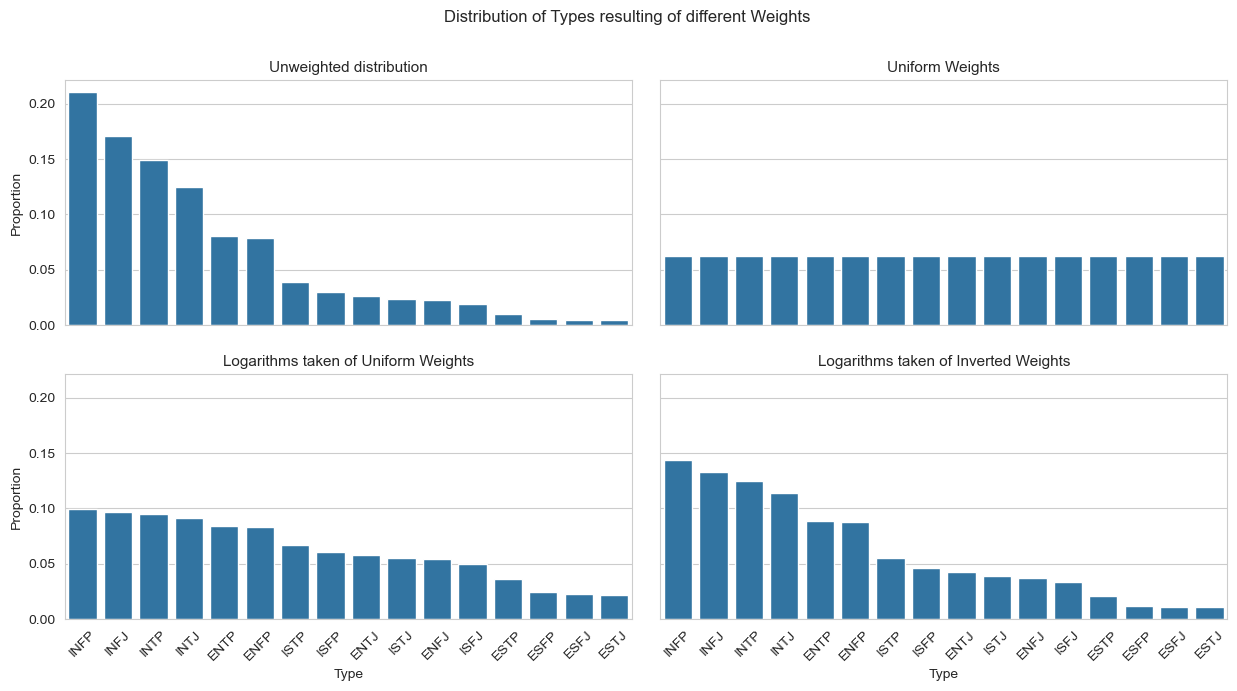

In [ ]:
# create a pandas dataframe for visualization
weights_pd = (train_out.select("type", "class_weights_scaled", "class_weights_maxlogscaled", "class_weights_inv_maxlogscaled")
              .distinct()
              .toPandas())

# create a dataframe with the type distributions in the training set
type_dist_pd = (train_out.select("type").groupby("type").count()
                .withColumn("proportion", F.col("count")/train_out.count())
                .toPandas())

# get the percentages column from type_distribution_pd and create proportions from it
weights_pd = weights_pd.merge(type_dist_pd[["type", "proportion"]], on="type", how="inner")

# calculate the resulting distribution of the types after applying the weights
for col in ["class_weights_scaled", "class_weights_maxlogscaled", "class_weights_inv_maxlogscaled"]:
    weighted_props = weights_pd.proportion * weights_pd[col] 
    rescaled_props = weighted_props / weighted_props.sum()  # ratio how much each weighted proportions falls into account
    weights_pd[col + "_props"] = rescaled_props

plot_df = weights_pd.sort_values("proportion", ascending=False)
proportion_cols = ["proportion", "class_weights_scaled_props", "class_weights_maxlogscaled_props", "class_weights_inv_maxlogscaled_props"]
titles = ["Unweighted distribution", "Uniform Weights", "Logarithms taken of Uniform Weights", "Logarithms taken of Inverted Weights"]

fig, axs = plt.subplots(2, 2, figsize=(15, 7), sharey=True, sharex=True)

for ax, col, title in zip(axs.flatten(), proportion_cols, titles):
    sns.barplot(plot_df, x="type", y=col, ax=ax)
    ax.set_xlabel("Type")
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_ylabel("Proportion")
    ax.set_title(title, size=11)

plt.suptitle("Distribution of Types resulting of different Weights", size=12)

fig.subplots_adjust(wspace=0.05)

This plot shows the resulting distributions after applying no weights (unweighted distribution) and the three scaled weights shown in the table above. We see that despite the high range amplitude of **class_weights_scaled**, they return the desired uniform distribution. I initially feared that these large differences might make training unstable, but **in practice, they work quite well — even in their unscaled version**.

The weights used for the plots at the bottom still lead to models that heavily rely on the most frequent classes, INFP and INFJ, rather than actually learning patterns to predict the MBTI type, as the corresponding plots suggest. Therefore, I **only use the simple weights or their scaled version**, as it does not really matter which one I choose.

The **baseline is simply 1/16, which equals 6.25%**, for all following models. Any performance above this on the validation set indicates that the model performs better than random guessing.

In addition to weighting, I also **experimented with oversampling** the classes with lower frequencies until each class had approximately the same number of rows as the most frequent class. Naturally, this increased the dataset size substantially. Since oversampling is not natively implemented in PySpark, I developed a custom solution to achieve this. However, **oversampling did not lead to better results than weighting**, and the dataset became too large. For this reason, I **ultimately chose weighting over oversampling**.

Before training the models, we define a generic function that returns the predictions, the true values, and the metrics a model achieves on a given dataset, as well as a function to nicely print the resulting accuracy (as one of these metrics) for the training and validation sets, in order to avoid repetitive code.

#### Creating an Evaluation Function for the Prediction

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import IntegerType

def get_pred_metrics(df, model) -> tuple:
    """Returns the predicted labels and the evaluation metrics of the Prediction"""
    pred_df = model.transform(df)

    preds_and_labels = (pred_df.select(['prediction', 'type_num'])
                        .withColumn('label', F.col('type_num').cast("float"))
                        .orderBy('prediction'))

    # select only prediction and label columns
    preds_and_labels = (preds_and_labels.select(['prediction', 'label']))

    return preds_and_labels, MulticlassMetrics(preds_and_labels.rdd.map(tuple))

def print_accuracies(train_metrics, val_metrics):
    print(f"Training accuracy: {np.round(train_metrics.accuracy, 4)}\n"
          f"Validation accuracy: {np.round(val_metrics.accuracy, 4)}")

We are now fully equipped and can start the training.

### XGBoost

In [ ]:
from xgboost.spark import SparkXGBClassifier

spark.conf.set("spark.sql.shuffle.partitions", "200")

# define xgb with the xgb_params
xgb = SparkXGBClassifier(features_col="features",
                         label_col="type_num",
                         weight_col="class_weights_scaled",
                         num_class=16,
                         eta=0.3,  # default
                         tree_method="hist",
                         max_bin=256,
                         max_depth=6,  # default
                         min_child_weight=1  # default
                         )
xgb_model = xgb.fit(train_out)

2025-05-19 10:32:51,422 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_bin': 256, 'max_depth': 6, 'min_child_weight': 1, 'tree_method': 'hist', 'num_class': 16, 'eta': 0.3, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-05-19 10:33:54,184 INFO XGBoost-PySpark: _train_booster Training on CPUs
[10:33:55] Task 0 got rank 0
2025-05-19 10:34:55,305 INFO XGBoost-PySpark: _fit Finished xgboost training!


Now it is time to use the created helper functions for evaluation:

In [ ]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1000")

tr_boost_pred, tr_boost_metrics = get_pred_metrics(train_out, xgb_model)
val_boost_pred, val_boost_metrics = get_pred_metrics(val_out, xgb_model)

print_accuracies(tr_boost_metrics, val_boost_metrics)

2025-05-19 11:53:38,990 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-19 11:54:36,978 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-19 11:55:34,127 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-19 11:55:50,028 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Training accuracy: 0.1483
Validation accuracy: 0.0734


This is a very low validation accuracy, as it is only slightly better than the baseline of 1/16 = 0.0625. Therefore, we move on and try other models.

### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features",
                            labelCol="type_num",
                            weightCol="class_weights_scaled")
rf_model = rf.fit(train_out)

tr_rf_pred, tr_rf_metrics = get_pred_metrics(train_out, rf_model)
val_rf_pred, val_rf_metrics = get_pred_metrics(val_out, rf_model)

print_accuracies(tr_rf_metrics, val_rf_metrics)

Training accuracy: 0.0596
Validation accuracy: 0.0519


The performance is even worse than that of the XGBoost model. Tree-based models might simply not be the right choice for this data, so we finally train a logistic regression model.

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features",
                        labelCol="type_num",
                        weightCol="class_weights_scaled",
                        )
lr_model = lr.fit(train_out)

tr_logReg_pred, tr_logReg_metrics = get_pred_metrics(train_out, lr_model)
val_logReg_pred, val_logReg_metrics = get_pred_metrics(val_out, lr_model)

print_accuracies(tr_logReg_metrics, val_logReg_metrics)

Training accuracy: 0.1504
Validation accuracy: 0.0704


As we can see the **classical models perform quite poorly** with the best of them only being slightly exceeding our baseline of 0.0625. **Perhaps word counts cannot capture the connection between posts and MBTI types well**, or **the sentences are simply too short to provide enough information** for this approach. Therefore, we try a completely different method: using Embeddings from an LLM (BERT in this case) in combination with a PyTorch neural network.

## Approach with BERT Embeddings

### Adjusting the PySpark Pipeline

BERT ignores case, but for uniformity, we introduce a transformer class to convert all words to lowercase:

In [ ]:
class LowerTransformer(Transformer):
    def __init__(self, inputCol):
        super().__init__()
        self.inputCol = inputCol
        #self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.inputCol, F.lower(F.col(self.inputCol)))

Now we can start creating a pipeline which shapes the data into the correct format for the PyTorch model. Since I want to reuse the engineered features, we first need to convert the resulting scaled features from Spark vectors to regular floats. Afterwards, we can define the final pipeline.

In [ ]:
vec2float_udf = F.udf(lambda vec: float(vec[0]), "float")

class Vec2FloatTransformer(Transformer):
    def __init__(self, inputCols):
        super().__init__()
        self.inputCols = inputCols

    def _transform(self, dataset):
        return dataset.withColumns({column: vec2float_udf(F.col(column)) for column in self.inputCols})

# we also instantiate the transformer that sets everything in lower Case:
lower_transformer = LowerTransformer(inputCol="cleaned_post")

# we do not need anymore the number of words, as BERT covers that with the sequence length
cols_to_floats = ["links_num_scaled", "chars_num_scaled", "chars_per_word_scaled"]
vec2float_transformer = Vec2FloatTransformer(cols_to_floats)

# pipeline for the pytorch usage
torch_pipeline = Pipeline(stages=[count_links_transformer,
                                  replace_links_transformer,
                                  clean_encoding_html_transformer,
                                  lower_transformer,
                                  words_num_transformer,
                                  word_filter_transformer,  # at least 3 words per post
                                  chars_num_transformer,
                                  chars_per_word_transformer
                                  ] + scaling_stages + [vec2float_transformer]
                          )

# apply the pipeline on the small tr and val datasets
torch_pl_model = torch_pipeline.fit(tr)

tr_df = torch_pl_model.transform(tr).toPandas()
val_df = torch_pl_model.transform(val).toPandas()

The result is a pair of compatible training and validation pandas dataframes that we now just need to convert into PyTorch Datasets.

### Creating the Datasets

First, we assign the PyTorch device to the best available option:

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.set_default_device(device)
print(f"Using device: {device}")

Using device: mps


Now we have to determine the appropriate length of the input sequences for the model. Since very long input lengths would introduce a lot of padding for most sequences, we face a trade-off between capturing complete information and keeping training efficient.

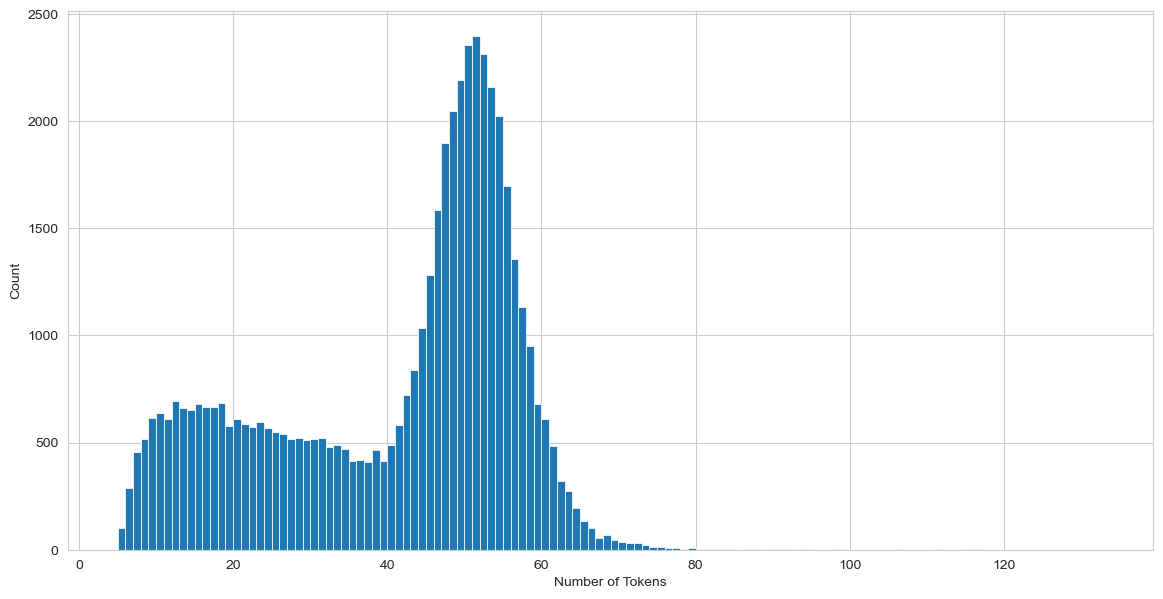

In [ ]:
from transformers import AutoTokenizer

# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", clean_up_tokenization_spaces=True)

# find the right number for max_length in the tokenize function
def count_tokens(post):
     tokens = tokenizer(post, truncation=False)
     return len(tokens["input_ids"])

token_lengths = np.array([count_tokens(post) for post in tr_df.cleaned_post])

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))

sns.histplot(token_lengths, binwidth=1, alpha=1);
plt.xlabel("Number of Tokens");

This plot resembles the number of words histogram, as we would have expected. There are only very few posts that contain more than 75 tokens. Since we do not want to cut off too much information, we check the percentiles of the number of tokens to determine an appropriate maximum length for the tokenizer:

In [ ]:
print("Maximal token length:", np.max(token_lengths))
print("95 percentile:", np.percentile(token_lengths, 95))
print("99 percentile:", np.percentile(token_lengths, 99))

Maximal token length: 133
95 percentile: 59.0
99 percentile: 65.0


The difference between the 95th and the 99th percentile is only 6 tokens, so we choose the 99th percentile with 65 tokens as the maximum length:

In [ ]:
max_len_tokenizer = np.percentile(token_lengths, 99).astype("int32")

Now we can define a dataset class to create PyTorch datasets and pass this value as the maximum sequence length when instantiating the class.

In [ ]:
from torch.utils.data import Dataset

class PostsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_length=512,
                 post_feature_col="cleaned_posts",
                 other_feature_cols=None,  # enables experimentation without engineered features
                 labels_col="type_num"):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.post_feature_col = post_feature_col
        self.other_feature_cols = other_feature_cols
        self.labels_col = labels_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row[self.post_feature_col]
        # Tokenize the text (return PyTorch tensors)
        tokens = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        # Squeeze out the batch dimension (from [1, seq_len] to [seq_len])
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)
        label = torch.tensor(row[self.labels_col]).long()

        # Engineered features converted to tensor
        if self.other_feature_cols:
            other_features = torch.tensor(row[self.other_feature_cols].values.astype(np.float32))
            return input_ids, attention_mask, other_features, label
        return input_ids, attention_mask, label

In [ ]:
# Create datasets
post_feature_col = "cleaned_post"
other_feature_cols = ["links_num_scaled", "chars_num_scaled", "chars_per_word_scaled"]
labels_col = "type_num"

train_dataset = PostsDataset(tr_df, tokenizer, max_length=max_len_tokenizer,
                             other_feature_cols=other_feature_cols,
                             post_feature_col=post_feature_col,
                             labels_col=labels_col)
val_dataset = PostsDataset(val_df, tokenizer, max_length=max_len_tokenizer,
                           other_feature_cols=other_feature_cols,
                           post_feature_col=post_feature_col,
                           labels_col=labels_col)

Here is what the first instance of the training set looks like:

In [ ]:
train_dataset[0]

(tensor([  101,  2748,  1010,  2021,  1045,  2123,  1005,  1056,  2215,  2000,
          2022,  1012,  1045,  2036,  2514,  2008,  1045,  1005,  2310,  5490,
         13860,  4063,  2098,  2055,  5585,  1003,  1997,  2026,  4022,  1012,
          2053,  2028,  2130,  4282,  2054,  1045,  2066,  1998,  2339,  1010,
          2030,  2040,  1045,  2572,  1010,  2130,  2295,  1045,  7887,  2572,
          4760,  1998,  9990,  2009,  2000,  1012,  1012,  1012,   102,     0,
             0,     0,     0,     0,     0], device='mps:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], device='mps:0'),
 tensor([0.0000, 0.8025, 0.0712], device='mps:0'),
 tensor(9, device='mps:0'))

We see four different tensors: 
* the input IDs (the words of the current post represented as integers),
* the attention masks for the input IDs, which enable handling posts with different lengths (1 tells the model to use the input ID with the same index; 0 tells the model to ignore it),
* the values of the scaled engineered features,
* and the MBTI type represented as a single integer

Of course, the validation set follows the same structure. Now we can pass the datasets to data loaders which conventiently handle batching and shuffling (only for `train_dataset`) during training.

In [ ]:
from torch.utils.data import DataLoader

# We set all tensors to the same device (mps) to avoid device mismatches:
generator = torch.Generator(device=device)
batch_size = 48

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          generator=generator)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        generator=generator)

This is the first batch of the train_loader:

In [ ]:
next(iter(train_loader))

[tensor([[  101,  4283,  2005,  ...,     0,     0,     0],
         [  101,  1045,  2109,  ...,     0,     0,     0],
         [  101,  2043,  1045,  ...,     0,     0,     0],
         ...,
         [  101,  4828,  2023,  ...,     0,     0,     0],
         [  101,  5259,  2075,  ...,     0,     0,     0],
         [  101, 10166,  1010,  ...,     0,     0,     0]], device='mps:0'),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='mps:0'),
 tensor([[0.0000, 0.3866, 0.0969],
         [0.0000, 0.8445, 0.0983],
         [0.0000, 0.7983, 0.0991],
         [0.0000, 0.8109, 0.0818],
         [0.0000, 0.7941, 0.0901],
         [0.0000, 0.5546, 0.0844],
         [0.0000, 0.8025, 0.0955],
         [0.0000, 0.1050, 0.1177],
         [0.0000, 0.8067, 0.0883],
         [0.0000, 0.7941, 0.0863],
         [0.0000, 0.77

### Defining a Model Class

Of course, the following model did not look like this from the very beginning. During local experimentation and later on Google Cloud, I kept adding features. \
To make the model flexible and tunable, I:
* enabled **optional usage of the engineered features**,
* made the model work with **any defined number of hidden layers (plus dropout)** following the BERT layers
* enabled **switching between `silu`and `relu`**,
* **stored the initialization arguments of the model** in an attribute allowing convenient model reconstruction when loading a checkpoint,
* and made the **predict method flexible** for various input types.

In [ ]:
from torch import nn
from typing import Literal
from transformers import AutoModel

class BertClassifier(nn.Module):
    """A flexible BERT-based classifier with optional engineered features, tunable hidden layers, and support for dynamic unfreezing."""

    def __init__(self, other_features_dim: int, hidden_num: int = 1, hidden_size: int = 128, num_classes: int = 16,
                 dropout_rate: float = 0.2, activation_name: Literal["silu", "relu"] = "silu",
                 use_additional_features=True, device: torch.device = device, **kwargs):
        super().__init__()

        self._init_args = {
            "other_features_dim": other_features_dim,
            "hidden_num": hidden_num,
            "hidden_size": hidden_size,
            "num_classes": num_classes,
            "dropout_rate": dropout_rate,
            "activation_name": activation_name,
            "use_additional_features": use_additional_features,
            **kwargs
        }

        self.use_additional_features = use_additional_features
        self.device = device

        # Load BERT and freeze its parameters
        self.bert = AutoModel.from_pretrained("bert-base-uncased").to(self.device)

        # freeze the bert layers initially:
        for param in self.bert.parameters():
            param.requires_grad = False

        bert_output_dim = self.bert.config.hidden_size  # typically 768 for bert-base

        # define layers to combine BERT output and engineered features
        if self.use_additional_features:
            combined_dim = bert_output_dim + other_features_dim
        else:
            combined_dim = bert_output_dim

        # self.fc1 = nn.Linear(combined_dim, hidden_size)

        # define activation function
        activations = {"silu": nn.SiLU(), "relu": nn.ReLU()}
        self.activation = activations[activation_name]

        # set the number of hidden layers
        basic_hidden_layers = [nn.Linear(combined_dim, hidden_size), self.activation, nn.Dropout(dropout_rate)]
        additional_hidden_layers = [nn.Linear(hidden_size, hidden_size), self.activation, nn.Dropout(dropout_rate)]
        all_hidden_layers = basic_hidden_layers.copy()  # to prevent overriding basic_hidden layers in the loop
        for _ in range(hidden_num - 1):
            all_hidden_layers.extend(additional_hidden_layers)
        self.hidden_layers = nn.Sequential(*all_hidden_layers)

        # self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, other_features=None):
        """Defines the order of the pass through the model"""
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use the pooler output (shape: [batch_size, hidden_size])
        pooled_output = bert_outputs.pooler_output

        # Concatenate BERT embedding with additional engineered features
        if self.use_additional_features and other_features is not None:
            combined_features = torch.cat([pooled_output, other_features], dim=1)
        else:
            combined_features = pooled_output
        hidden_output = self.hidden_layers(combined_features)  # this is a block of layers
        logits = self.output_layer(hidden_output)
        return logits

    def unfreeze_layers(self, num_layers_to_unfreeze, unfreeze_pooler=True):
        """Unfreezes the pooler and last `num_layers_to_unfreeze` layers of BERT."""

        if unfreeze_pooler:
            for param in self.bert.pooler.parameters():
                param.requires_grad = True

        for param in self.bert.encoder.layer[-num_layers_to_unfreeze:].parameters():
            param.requires_grad = True

    def unpack_batch(self, batch, has_labels=True, use_additional_features=True):
        """Helper method to avoid too many indents and branches in the predict method"""
        parts = list(batch)
        input_ids = parts[0]
        attention_mask = parts[1]

        if use_additional_features:
            other_features = parts[2]
            labels = parts[3] if has_labels else None
        else:
            other_features = None
            labels = parts[2] if has_labels else None

        return input_ids, attention_mask, other_features, labels

    def predict(self, input_ids=None, attention_mask=None, other_features=None, dataset=None, batch_size=48,
                device=device, return_labels=True, use_tqdm=True) -> tuple:
        """Returns the prediction probabilities for each type, the type number with the highest probability (e.g. the
        prediction) and if return_labels=True also the true type number in this order. Makes predictions flexible for
        any kind of input, whether it is a small or large dataset or just a single instance."""
        # ensure that the model and the input tensors are on the same device
        if next(self.parameters()).device.type != device.type:
            self.to(device)

        self.eval()

        with torch.no_grad():
            # for datasets smaller than batch_size
            if dataset is not None and len(dataset) <= batch_size:
                ordered_tuples = list(zip(*dataset))
                input_ids, attention_mask = [torch.stack(tup) for tup in ordered_tuples[:2]]

                if self.use_additional_features:
                    other_features = torch.stack(ordered_tuples[2])
                    if return_labels:
                        labels = torch.stack(ordered_tuples[3])
                else:
                    other_features = None
                    if return_labels:
                        labels = torch.stack(ordered_tuples[2])

                logits = self(input_ids, attention_mask, other_features)

            # for datasets bigger than batch_size
            elif dataset is not None:
                loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
                logits = []
                labels = [] if return_labels else None
                data_iterable = tqdm(loader, desc="Predicting", leave=False) if use_tqdm else loader

                for batch in data_iterable:
                    input_ids, attention_mask, other_features, batch_labels = self.unpack_batch(
                        batch, has_labels=return_labels, use_additional_features=self.use_additional_features
                    )

                    batch_logits = self(input_ids, attention_mask, other_features)
                    logits.append(batch_logits)
                    if return_labels:
                        labels.append(batch_labels)

                    if self.device.type == "mps":
                        torch.mps.empty_cache()
                        gc.collect()

                logits = torch.cat(logits, dim=0)
                if return_labels:
                    labels = torch.cat(labels, dim=0)

            # for predicting single instances
            else:
                if input_ids.dim() == 1:
                    input_ids = input_ids.unsqueeze(0)
                    attention_mask = attention_mask.unsqueeze(0)
                    if other_features is not None:
                        other_features = other_features.unsqueeze(0)

                logits = self(input_ids, attention_mask, other_features)

            probs = nn.functional.softmax(logits, dim=1)
            pred_class = probs.argmax(dim=1)

            if return_labels:
                return probs, pred_class, labels
            else:
                return probs, pred_class

Now we simply need to instantiate the model:

In [ ]:
bert_model = BertClassifier(other_features_dim=len(other_feature_cols),
                            hidden_num=2,
                            hidden_size=64,
                            num_classes=16,
                            dropout_rate=0.3,
                            activation_name="relu",
                            use_additional_features=True)

# move the model to the current device
bert_model.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Here we see the structure of the model. We can now start training the model. To keep everything clean, modular, and at one place, I defined a trainer class.

### Training the Model

Like the model class, I also adjusted the trainer over time. Here are the main points: 
* **Unfreezing Mode Option:** Enables switching between dynamic and static unfreezing of bert layers.
* **Faster Testing:** Allows using a maximum number of batches for testing.
* **Optional Use of Engineered/Additional Features:** Also Enables ablation studies.
* **Weight Restoring:** Uses early stopping and restores the best weights so far at unfreezing phase shifts.
* **Training Device Management:** Automatically switches the device from MPS to CPU when more than 2 BERT layers are unfrozen — MPS is much faster for shallow training but slows down substantially for deeper layers. It took some experimentation and debugging to get this to work smoothly.
* **Memory Mangagement:** Adds a routine to free memory when training on MPS, since it is not as optimized as on CPU or GPU/Cloud.
* **Warm-Up Epochs:** Defines a number of warmup epochs at the beginning where the counter for unfreezing does not increase.
* **History:** Tracks metrics, logs, and other training info in a history attribute.

In [ ]:
import torch.optim as optim
from pathlib import Path
import os
import time
import psutil
import copy
import gc
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

class Trainer:
    def __init__(self, model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, lr_schedule_list: list,
                 unfreeze_layers_list: list, patience: int, patience_last_phase: int, num_epochs: int,
                 optimizer_name: Literal["adamw", "adam", "sgd"] = "adamw", device: torch.device = device,
                 class_weights: torch.tensor = None, max_batches: int = None, use_additional_features: bool = True,
                 use_dynamic_unfreezing: bool = True, warmup_epochs: int = 10, restore_best_overall_weights: bool = True,
                 restore_best_weights_phase: bool = False, num_epochs_per_unfreeze_phase: int = None,
                 suppress_tokenizer_warning: bool = True, use_tqdm=True):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.starting_device = device  # to check if later a switch to another device is necessary
        self.device = device
        self.patience = patience
        self.patience_last_phase = patience_last_phase
        self.num_epochs = num_epochs
        self.lr_schedule_list = lr_schedule_list
        self.unfreeze_layers_list = unfreeze_layers_list
        self.last_index_unfreeze_layers_list = len(self.unfreeze_layers_list) - 1
        self.num_used_batches = max_batches
        self.suppress_tokenizer_warning = suppress_tokenizer_warning  # to stop forking
        self.use_additional_features = use_additional_features  # for the ablation study
        self.use_dynamic_unfreezing = use_dynamic_unfreezing  # for hypertuning
        self.warmup_epochs = warmup_epochs
        self.restore_best_overall_weights = restore_best_overall_weights
        self.restore_best_weights_phase = restore_best_weights_phase
        self.num_epochs_per_unfreeze_phase = num_epochs_per_unfreeze_phase

        self.class_weights = class_weights
        self.criterion = nn.CrossEntropyLoss(
            weight=self.class_weights.to(self.device) if self.class_weights is not None else None
        )

        # setting the optimizer
        self.optimizer_name = optimizer_name
        self.optimizers = {"adamw": lambda lr: optim.AdamW(self.model.parameters(), lr=lr),
                           "adam": lambda lr: optim.Adam(self.model.parameters(), lr=lr),
                           "sgd": lambda lr: optim.SGD(self.model.parameters(), lr=lr)}
        self.learning_rate = lr_schedule_list[0]  # we start with the first entry of our the lr_list
        self.optimizer = self.optimizers[self.optimizer_name](self.learning_rate)

        self.idx_unfreeze = 0  # index of our unfreeze_layers_list, starting with 0
        self.num_layers_to_unfreeze = self.unfreeze_layers_list[0]  # start with first entry of the list

        self.best_val_acc_total = 0.0
        self.best_val_acc_phase = 0.0
        self.best_model_state = None
        self.best_optimizer_state = None
        self.epochs_without_improve = 0
        self.epochs_in_current_phase = 0  # to count the number of epochs in the current unfreezing phase
        self.epoch_times = []
        self.epoch = 0
        self.cloud_run = self.is_cloud_env()

        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "unfrozen_layers": [],
            "learning_rate": [],
            "logs": [],
            "grad_norms": [],
            "restore_best_weights": self.restore_best_weights_phase
        }
        self.setup_environment()
        self.model.to(self.device)
        self.use_tqdm = use_tqdm
        # self.log_memory("Initial state")

    def is_cloud_env(self):
        """Checks if training is running on the cloud or locally. When running on the cloud it returns True if there is
        a subdir in the container, that stores the bucket (and so starts with "gcs") or an AIP_JOB_NAME is set in the
        environment (which Vertex AI custom Jobs do automatically). Otherwise it returns false meaning that the run is
        local"""
        return Path("/gcs").exists() or "AIP_JOB_NAME" in os.environ

    def setup_environment(self):
        """Checks if the environment runs on MPS and disables tokenizer parallelism to avoid forking warnings, which
        are harmless here."""
        if self.suppress_tokenizer_warning and self.device.type == "mps":
            os.environ["TOKENIZERS_PARALLELISM"] = "false"

    def tensors_to_device(self, batch):
        """Checks the type of the current batch and builds an iterable of the same type with all tensors moved to the
        current device."""
        return type(batch)(tensor.to(self.device) for tensor in batch)

    def log(self, message: str, always_print: bool = True):
        """Ensures that the current epoch of logs is always shown and added to the history, even if the log is not
        printed.
        Handles clean logging during cloud runs that prints only every fifth epoch per current unfreezing phase or in
        the unlikely event that the last epoch is reached (which is usual set to a high number like 200).
        If we use tqdm during local training the unformatted log is also printed with tqdm.write() for consistency"""
        # Always store in history
        # we want to know at which epoch special loggings occur:
        log = f"Epoch {self.epoch + 1}/{self.num_epochs}: {message}"
        formatted_log = f"[Trainer] {log}"
        self.history["logs"].append(formatted_log)

        # Only print based on condition (meaning that at least one must be true)
        if (always_print  # by default True must be set manually to False
                or not self.cloud_run  # False when training on cloud
                or self.epochs_in_current_phase % 5 == 0  # when conds above are both false it depends on this...
                or self.epoch == self.num_epochs - 1):  # ...and this
            if self.use_tqdm:
                tqdm.write(log)
            else:
                print(log, flush=True)

    def log_memory(self, label):
        """Helper function only for debugging. Was useful to find out, how many unfrozen BERT layers MPS can handle
        and when the bottleneck occurred"""
        self.log(f"\n[Memory @ {label}]")
        self.log(f"RAM used: {psutil.virtual_memory().percent}%")
        if torch.backends.mps.is_available():
            self.log(f"MPS allocated: {torch.mps.current_allocated_memory() / 1024 ** 2:.2f} MB")
            self.log(f"MPS reserved:  {torch.mps.driver_allocated_memory() / 1024 ** 2:.2f} MB")

    def free_memory(self):
        """While training on MPS, memory accumulates with every epoch and must be freed manually"""
        if self.device.type == "mps":
            torch.mps.empty_cache()
            gc.collect()

    def get_gradients_norm(self, model, epoch, batch_idx):
        """Helper to check when gradient explosion or shrinkage happens during training on the cloud"""
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        self.history["grad_norms"].append({
            "epoch": epoch + 1,
            "batch": batch_idx,
            "norm": total_norm ** 0.5
        })

    def move_optimizer_to_device(self, optimizer, device):
        """Helper to ensure that all optimizer params are on the same device as the model params and the data after
        switching to cpu"""
        for state in optimizer.state.values():
            for key, value in state.items():
                if isinstance(value, torch.Tensor):
                    state[key] = value.to(device)

    def unfreeze_and_maybe_switch_device(self):
        """Unfreezes the next Bert layers and when training on mps switches everything to cpu. Further it updates the
        learning rate to the value prescribed for that unfreezing stage"""
        self.model.unfreeze_layers(self.num_layers_to_unfreeze)

        # switch to cpu, when more than one bert layer is unfrozen and training on "mps"
        if self.num_layers_to_unfreeze > 1 and self.device.type == "mps":
            self.device = torch.device("cpu")
            self.model.to(self.device)
            #self.class_weights = self.class_weights.to(self.device) if self.class_weights is not None else None
            #self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
            # check if this worked properly as it does not throw an error by itself:
            #assert self.criterion.weight.device == self.device, "Loss weight device mismatch!"
            self.move_optimizer_to_device(self.optimizer, self.device)
            self.log(f"Moved model, data and optimizer params to {self.device}") 

        self.learning_rate = self.lr_schedule_list[self.idx_unfreeze]
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = self.learning_rate

        self.criterion = nn.CrossEntropyLoss(
            weight=self.class_weights.to(self.device) if self.class_weights is not None else None)  # remove here for debugging

        self.log(f"Adjusted Learning Rate to {self.learning_rate:.1e}")
        self.free_memory()

    def unfreeze_next_phase(self):
        """When the defined patience of epochs is reached during dynamic unfreezing or the final epoch was
        reached during static unfreezing.
        Checks if more BERT layers should be unfrozen (based on the defined schedule), and either starts
        the next phase or signals the end of training.
        Note: best_val_acc_phase is reset to 0 at the start of each unfreezing phase, so the first epoch
        after unfreezing usually counts as an 'improvement'. This means that patience=2 results in 3 epochs
        before the next unfreeze and so on."""
        # check if we are not already at the last phase of unfreezing layers
        if self.idx_unfreeze < self.last_index_unfreeze_layers_list:
            self.idx_unfreeze += 1
            self.num_layers_to_unfreeze = self.unfreeze_layers_list[self.idx_unfreeze]  # get next value from the list
            self.unfreeze_and_maybe_switch_device()  # Unfreeze more layers and switch to "cpu" if necessary

            self.log(f"Unfroze {self.num_layers_to_unfreeze} layers due to "
                     f"{'plateau' if self.use_dynamic_unfreezing else 'schedule'}")

            if self.restore_best_weights_phase:  # reset the parameters for the phase
                self.model.load_state_dict(self.best_model_state)
                self.optimizer.load_state_dict(self.best_optimizer_state)
                self.log("Restored weights to best epoch so far")
                self.best_val_acc_phase = self.best_val_acc_total  # to keep the patience counter equal
            else:
                self.best_val_acc_phase = 0
            self.epochs_without_improve = 0
            self.epochs_in_current_phase = 0
        else:
            self.log(f"""{'No improvement, but all layers already unfrozen:' if self.use_dynamic_unfreezing
            else 'All scheduled layers unfrozen:'} """
                f"Stopping.")
            return True  # signal for stopping the training
        return False

    def train_one_epoch(self):
        """The method where the actual training takes place and the loss and accuracy on the training set are
        calculated.
        Breaks the training when the assigned maximum number of batches was reached. When training starts on
        MPS the tensors of the current batch are pushed to the current device.
        Also handles whether to include additional (engineered) features depending on config."""
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0
        batch_times = []

        data_iterable = tqdm(self.train_loader,
                             desc=f"Train Epoch {self.epoch + 1}",
                             leave=False,
                             disable=not self.use_tqdm)  # when false returns loader as is

        for batch_idx, batch in enumerate(data_iterable):
            # check if there was a limit on the number of batches to use
            if self.num_used_batches and batch_idx >= self.num_used_batches:
                break

            start = time.time()

            if self.starting_device.type == "mps":
                batch = self.tensors_to_device(batch)  # else tensors stay on default device

            if self.use_additional_features:
                input_ids, attention_mask, other_features, labels = batch
            else:
                input_ids, attention_mask, labels = batch
                other_features = None  # guarantees flexibility

            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask, other_features)

            loss = self.criterion(outputs, labels)
            loss.backward()
            self.get_gradients_norm(self.model, self.epoch, batch_idx)  # for model inspecting
            self.optimizer.step()

            running_loss += loss.item() * input_ids.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_times.append(time.time() - start)

            avg_loss = running_loss / total
            accuracy = correct / total

            del input_ids, attention_mask, other_features, labels, outputs, loss
            self.free_memory()  # happens only on mps device

            if self.use_tqdm:
                data_iterable.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{accuracy:.4f}")

        return avg_loss, accuracy, sum(batch_times) / len(batch_times)

    def validate(self):
        """Evaluates the learned model weights during train_one_epoch on the validation dataset, calculating the loss 
        and accuracy. 
        Similar setup to train_one_epoch when it comes to maximum batch number and the usage of other features"""
        self.model.eval()
        running_loss, correct, total = 0.0, 0, 0
        batch_times = []

        with ((torch.no_grad())):

            data_iterable = tqdm(self.val_loader,
                                 desc=f"Val Epoch {self.epoch + 1}",
                                 leave=False,
                                 disable=not self.use_tqdm)  # when false returns loader as is

            for batch_idx, batch in enumerate(data_iterable):
                # check if there was a limit on the number of batches to use
                if self.num_used_batches and batch_idx >= self.num_used_batches:
                    break

                start = time.time()

                if self.starting_device.type == "mps":
                    batch = self.tensors_to_device(batch)  # else tensors stay on default device

                if self.use_additional_features:
                    input_ids, attention_mask, other_features, labels = batch
                else:
                    input_ids, attention_mask, labels = batch
                    other_features = None  # guarantees flexibility

                #self.optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask, other_features)

                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * input_ids.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                batch_times.append(time.time() - start)

                avg_loss = running_loss / total
                accuracy = correct / total

                del input_ids, attention_mask, other_features, labels, outputs, loss
                self.free_memory()  # happens only on mps device
        return avg_loss, accuracy

    def train(self):
        """Main method that orchestrates training and validation.
        Checks how long the model is supposed to be warmed up and increases the learning rate with every warm-up epoch.
        Adjusts the patience for the last unfreezing epoch if defined differently.
        Also compares the validation accuracy of the current epoch with the best achieved one so far and the one in the
        current unfreezing phase. Saves the current model_state if it is the best in this epoch or in the whole training
        in two different variables. If use_dynamic_unfreezing set to True and depending on the result of this comparison
        and the defined patience also decides if the next layer should be unfrozen. If use_dynamic_unfreezing set to
        False unfreezing the next phase depends only on num_epochs_per_unfreeze_phase.
        At the end, restores the model to the best state found during training."""        
        if self.warmup_epochs > 0:
            self.log(f"Warming up for {self.warmup_epochs} epochs:", always_print=True)

        for epoch in range(self.num_epochs):
            self.epoch = epoch

            if self.epoch <= self.warmup_epochs and self.warmup_epochs > 0:
                warmup_start = 1e-6
                target_lr = self.lr_schedule_list[0]
                # we increase the learning rate with each epoch till it reaches the first value of our schedule
                self.learning_rate = warmup_start + (target_lr - warmup_start) * (self.epoch / self.warmup_epochs)
                for param_group in self.optimizer.param_groups:
                    param_group["lr"] = self.learning_rate

            # give the model a bit more time to adapt on the last phase
            if self.idx_unfreeze == self.last_index_unfreeze_layers_list:
                self.patience = self.patience_last_phase

            start_time = time.time()

            train_loss, train_acc, avg_train_time = self.train_one_epoch()
            val_loss, val_acc = self.validate()

            # assign new values to history, same order as keys in history!
            new_values = (train_loss,
                          train_acc,
                          val_loss,
                          val_acc,
                          self.num_layers_to_unfreeze,
                          self.learning_rate)

            for key, new_value in zip(self.history.keys(), new_values):
                self.history[key].append(new_value)

            epoch_duration = time.time() - start_time
            self.epoch_times.append(epoch_duration)

            epoch_summary = f"Time: {epoch_duration:.2f}s | " \
                            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | " \
                            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} "

            if self.epoch < self.warmup_epochs - 1:
                self.log(epoch_summary +
                         f"LR: {self.learning_rate:.1e}", True)
            elif self.epoch == self.warmup_epochs - 1:
                self.log(epoch_summary +
                         f"LR: {self.learning_rate:.1e}\n"
                         f"Warm-up finished after epoch {self.epoch + 1}. LR schedule starts now.",
                         True)
            else:
                self.log(epoch_summary, always_print=False)  # only relevant for training on the cloud

            # Track the best accuracy during this phase but only when the warmup phase has finished
            if self.epoch >= self.warmup_epochs:
                if val_acc > self.best_val_acc_phase:
                    self.best_val_acc_phase = val_acc
                    self.epochs_without_improve = 0
                    if val_acc > self.best_val_acc_total:
                        self.best_val_acc_total = val_acc
                        # to decouple self.best_model_state from the current one
                        self.best_model_state = copy.deepcopy(self.model.state_dict())
                        self.best_optimizer_state = copy.deepcopy(self.optimizer.state_dict())
                        self.log(f"Saved best model state: train acc = {train_acc:.4f}, val acc = {val_acc:.4f}")
                else:
                    self.epochs_without_improve += 1
            else:
                self.epochs_without_improve = 0

            self.epochs_in_current_phase += 1

            # Decide whether to unfreeze next
            # dynamic unfreezing
            if self.use_dynamic_unfreezing and self.epochs_without_improve >= self.patience:
                if self.unfreeze_next_phase():
                    break
            # static unfreezing after fixed number of epochs
            elif not self.use_dynamic_unfreezing and (
                    self.epoch + 1) % self.num_epochs_per_unfreeze_phase == 0:
                if self.unfreeze_next_phase():
                    break

        self.log(f"Training completed after {sum(self.epoch_times) / 60:.1f} minutes - "
                 f"Best Val Accuracy: {self.best_val_acc_total:.4f}")

        # we always want to be able to restore the final epoch's state in case of lucky jumps at the beginning
        self.last_epoch_state = copy.deepcopy(self.model.state_dict())
        self.last_epoch_optimizer_state = copy.deepcopy(self.optimizer.state_dict())

        if self.restore_best_overall_weights and self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            self.optimizer.load_state_dict(self.best_optimizer_state)

We need the balancing class weights in the form of a PyTorch tensor, so we calculate them again for the new training set. Since scaling them did not lead to better results, I stick with the raw weights. I also experimented with logarithmized and inverted weights, but they still caused the model to rely too much on the most frequent classes. 

In [ ]:
label_counts = train_dataset.df[labels_col].value_counts().sort_index()
total = len(train_dataset.df)
num_classes = len(label_counts)
class_weights = total / (num_classes * label_counts)
class_weights_torch = torch.tensor(class_weights.values, dtype=torch.float32)

class_weights_torch

tensor([ 2.7854,  0.7949,  2.3496,  0.7782, 13.2656, 12.0142, 13.8424,  6.1462,
         0.3653,  0.2959,  0.5014,  0.4183,  3.2958,  2.0932,  2.6487,  1.6186],
       device='mps:0')

Now let us instantiate the trainer class and train the model:

In [ ]:
# here is the list, how many bert layers (+ the pooling layer) are trained during each unfreezing phase
unfreeze_layers_list = [0, 1, 3]  # at 0 it is the defined default above

# this schedule defines the learning rates for each unfreezing phase
lr_schedule_list = [1e-4, 1e-5, 5e-6]

trainer = Trainer(bert_model,
                  train_loader,
                  val_loader,
                  lr_schedule_list,
                  unfreeze_layers_list,
                  optimizer_name="adam",
                  class_weights=class_weights_torch,
                  use_additional_features=True,  # we start with using the engineered features
                  use_dynamic_unfreezing=True,  # dynamic unfreezing
                  num_epochs_per_unfreeze_phase=None,
                  use_tqdm=False,  # for cleaner output
                  patience=2,
                  patience_last_phase=2,
                  warmup_epochs=0,
                  num_epochs=20,
                  )

trainer.train()

Epoch 1/20: Time: 1067.55s | Train Loss: 2.7721, Train Acc: 0.1176 | Val Loss: 2.7698, Val Acc: 0.1391 
Epoch 1/20: Saved best model state: train acc = 0.1176, val acc = 0.1391
Epoch 2/20: Time: 1112.46s | Train Loss: 2.7711, Train Acc: 0.1347 | Val Loss: 2.7700, Val Acc: 0.1418 
Epoch 2/20: Saved best model state: train acc = 0.1347, val acc = 0.1418
Epoch 3/20: Time: 1127.02s | Train Loss: 2.7702, Train Acc: 0.1406 | Val Loss: 2.7684, Val Acc: 0.1923 
Epoch 3/20: Saved best model state: train acc = 0.1406, val acc = 0.1923
Epoch 4/20: Time: 1134.68s | Train Loss: 2.7694, Train Acc: 0.1208 | Val Loss: 2.7684, Val Acc: 0.1450 
Epoch 5/20: Time: 1157.43s | Train Loss: 2.7702, Train Acc: 0.1318 | Val Loss: 2.7690, Val Acc: 0.0962 
Epoch 5/20: Adjusted Learning Rate to 1.0e-05
Epoch 5/20: Unfroze 1 layers due to plateau
Epoch 6/20: Time: 1342.11s | Train Loss: 2.7690, Train Acc: 0.1367 | Val Loss: 2.7685, Val Acc: 0.1278 
Epoch 7/20: Time: 1328.43s | Train Loss: 2.7671, Train Acc: 0.1342 

In every epoch, this deep learning model performs better than the classic machine learning baselines.  
The highest validation accuracy (**0.1923**) was already reached in epoch 3, but the model kept improving slightly during the second unfreezing phase — almost reaching that level again in epoch 14 (**0.1885**).  
That suggests BERT’s ability to pick up not just the words but also the *style and context* of the sentences helps it make better predictions compared to models based on word counts. While these accuracies are still not stellar, they represent a clear improvement over our weighted baseline of **0.0625**, which reflects a uniform class distribution when using class weights — as we have done here.

Since this is our best model so far, it is worth looking at it more closely.  
But before that, we set up a checkpointing function to save:

- the model’s **initialization arguments** (so we can easily recreate it),
- both the **best and most recent model state**,
- the **optimizer state** (in case we want to resume training),
- and the **full training history** with all logs and metrics.


In [ ]:
def save_torch_checkpoint(model, trainer, path):
    save_items = {"_init_args": model._init_args,  # to recreate the model easily
                  "model_state_dict": model.state_dict(),  # best weights
                  "optimizer_state_dict": trainer.optimizer.state_dict(),  # optimizer state in epoch with best weights
                  "model_last_state_dict": trainer.last_epoch_state,  # the state at last raining epoch
                  "optimizer_last_state_dict": trainer.last_epoch_optimizer_state,  # optimizer state at last training epoch
                  "history": trainer.history,
                  }
    torch.save(save_items, path)
    print(f"Saved checkpoint for {save_items.keys()} to {path}")

In [ ]:
PATH = "PytorchModel_DynamicUnfreezingSinglePosts.pth"
save_torch_checkpoint(bert_model, trainer, PATH)

Saved checkpoint for dict_keys(['_init_args', 'model_state_dict', 'optimizer_state_dict', 'model_last_state_dict', 'optimizer_last_state_dict', 'history']) to PytorchModel_DynamicUnfreezingSinglePosts.pth


Saving the model allows reusing it without retraining:

In [ ]:
model_checkpoint = torch.load(PATH, weights_only=True)

# instantiate a new model from the checkpoint with the same arguments like the saved one
best_model = BertClassifier(**model_checkpoint["_init_args"])

# load the weights
best_model.load_state_dict(model_checkpoint["model_state_dict"])

<All keys matched successfully>

### Model Evaluation

The training accuracy shown in the logs may differ from the one obtained by using the model's predict method due to the dropout layers, which randomly deactivate weight connections during training but not during inference when using `model.eval()`. To obtain the **true training accuray**, it is best to run inference on the training set after training, with the model in evaluation mode, where all weights are active and deterministic behavior is restored:

In [ ]:
from sklearn.metrics import accuracy_score

def get_acc_from_tensors(y_true: torch.tensor, y_pred: torch.tensor, dataset_type: str):
    score = accuracy_score(y_true.to("cpu"), y_pred.to("cpu"))
    print(f"Accuracy on the {dataset_type}: {score*100:.2f}%")

In [ ]:
tr_probs, tr_preds, tr_trues = best_model.predict(dataset=train_dataset, use_tqdm=False)
get_acc_from_tensors(tr_trues, tr_preds, "training set")

Accuracy on the training set: 19.16%


The training accuracy **is actually higher than the one obtained during training mode** (0.1406 at epoch 3). Let us inspect which classes were correctly predicted and which were not:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def PlotConfusionMatrix(true, pred):

    sns.set_style("white")
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    cm1 = ConfusionMatrixDisplay.from_predictions(true, pred, ax=axs[0]);
    cm1.ax_.set_xticks(range(len(classes)), labels=classes, rotation=45, ha="center")
    cm1.ax_.set_yticks(range(len(classes)), labels=classes),
    cm1.ax_.set_title("Confusion Matrix")
    
    cm2 = ConfusionMatrixDisplay.from_predictions(true, pred,
                                                  normalize="true",
                                                  values_format=".0%",
                                                  ax=axs[1])
    cm2.ax_.set_xticks(range(len(classes)), labels=classes, rotation=45, ha="center")
    cm2.ax_.set_yticks(range(len(classes)), labels=classes)
    cm2.ax_.set_title("CM normalized by row")
    
    plt.subplots_adjust(wspace=0.1)

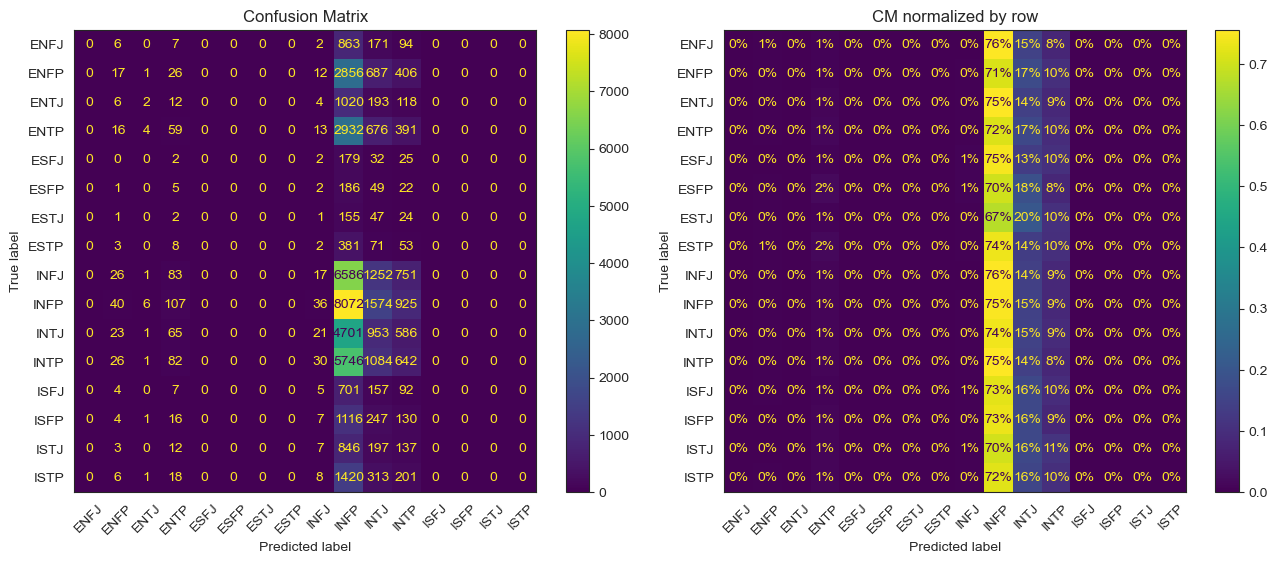

In [ ]:
PlotConfusionMatrix(tr_trues.to("cpu"), tr_preds.to("cpu"))

These confusion matrices are sobering.  
The **most frequent class (INFP) clearly dominates the predictions**. However, since the current model state corresponds to epoch 3 (due to best weights restoration), it appears that the provided class weights have not yet sufficiently influenced the model toward a more balanced prediction pattern.

If the weights had been completely ignored or ineffective, the model would likely predict INFP almost exclusively — a shortcut to reaching a relatively high accuracy of around **0.21**, which corresponds to INFP’s proportion in the data.

This suggests that the **weighted baseline of 0.0625 may be too optimistic (i.e., too low) for this early stage of training**.  
It’s possible that, despite lower validation accuracy in the final epochs, the model may have learned to distinguish the classes better.

To explore this, we deepcopy the model and load the weights from the final training epoch for comparison.

In [ ]:
last_epoch_model = copy.deepcopy(best_model)
last_epoch_model.load_state_dict(model_checkpoint["model_last_state_dict"])
last_tr_probs, last_tr_preds, last_tr_trues = last_epoch_model.predict(dataset=train_dataset)
get_acc_from_tensors(last_tr_trues, last_tr_preds, "training set")

Accuracy on the training set: 13.17%


This also slightly better than the logged value (11.1%), but let us take a look at the corresponding confusion matrices here as well:

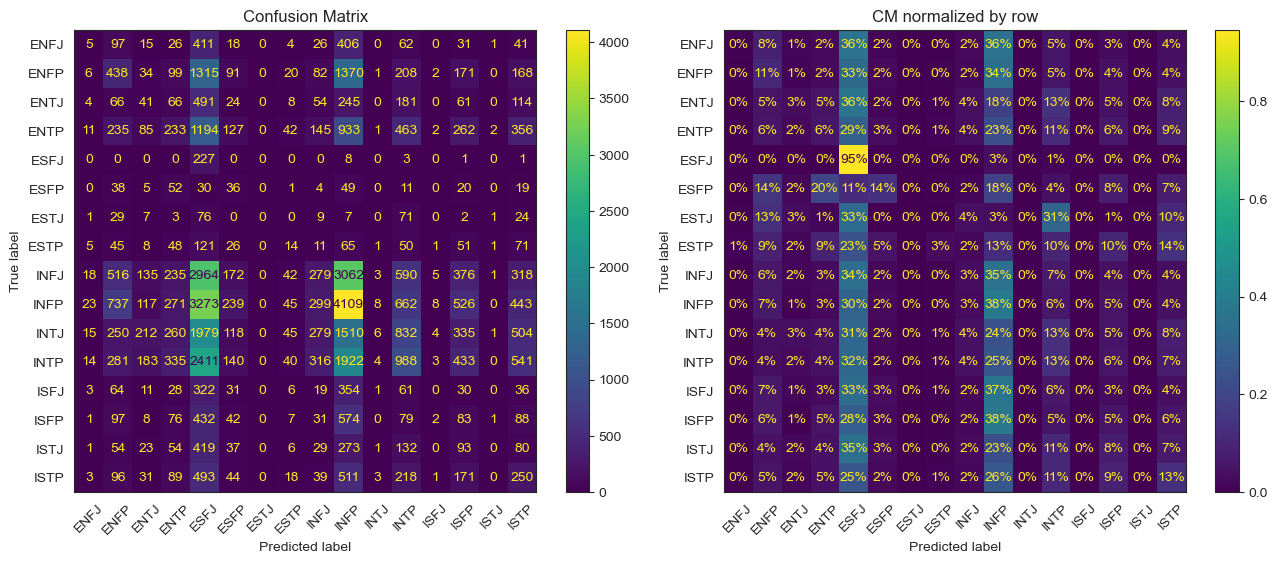

In [ ]:
PlotConfusionMatrix(last_tr_trues.to("cpu"), last_tr_preds.to("cpu"))

The effect of the class weights is now clearer, though still not ideal.  
The model continues to rely heavily on the most frequent class (INFP) and also, interestingly, on the least frequent class (ESFJ) — likely due to its high class weight.  
However, there is more "chaos" in the matrix: other classes are now being predicted as well.  
In fact, **this confusion matrix looks better** than the one with higher validation accuracy.

One possible solution to the problem of restoring weights from an early epoch — where the model overrelies on dominant classes — might be to use another metric that better reflects class balance.

Let $C$ be the number of classes, $p_i$ the proportion of class $i$, and $a_i$ the proportion of correctly predicted examples belonging to class $i$ relative to the full dataset. Then the *normalized accuracy* could be defined as:

$$
\text{Normalized Accuracy} = \frac{1}{C} \sum_{i=1}^{C} \frac{a_i}{p_i}
$$

This formulation simplifies to the average per-class recall, which is equivalent to **macro recall** (or **macro accuracy** in this single-label classification setting and equals $\frac{1}{C} \sum_{i=1}^{C} \frac{TP_i}{n_i}$ with $TP_i$ as the true positives and $n_i$ as all instances belonging to class $i$).  
Although this is a standard metric, it emerged here independently as a diagnostic response to the limitations of raw accuracy in early training phases.

Using this metric, yields:

In [ ]:
def compute_na(y_true, y_pred, num_classes=16):
    total = y_true.numel()
    props = torch.bincount(y_true, minlength=num_classes).float() / total
    correct = (y_true == y_pred)
    correct_per_class = torch.bincount(y_true[correct], minlength=num_classes).float()
    acc_per_class = correct_per_class / total  # a_i = TP_i / N
    na = (acc_per_class / props.clamp(min=1e-8)).mean()  # a_i / p_i
    return na.item()

In [ ]:
print(f"Normalized/Macro Accuracy (Epoch 3): {compute_na(tr_trues, tr_preds):.4f}")
print(f"Normalized/Macro Accuracy (Final Epoch): {compute_na(tr_trues, last_tr_preds):.4f}")

Normalized/Macro Accuracy (Epoch 3): 0.0629
Normalized/Macro Accuracy (Final Epoch): 0.1272


This shows clearly that the model learned to distinguish between classes better in later training, even though the raw validation accuracy was slightly lower. \
However, we **do not use macro accuracy as the criterion for early stopping or model selection** as it tends to be unstable, especially at the beginning of training, and it gives equal weight to all classes — even very rare ones. Instead, we attempt to address the class imbalance by increasing the patience setting — or later, by using a warmup phase during training. This gives the class weights more time to influence learning.
**Macro accuracy (or macro recall) is used only as a diagnostic metric** for evaluation, helping us understand how well the model distinguishes between all classes.

There is also a separate issue with the single-post approach that we have only briefly addressed so far: \
**Each user contributes around 50 posts**, which means the samples are not truly independent.  
The model may learn individual writing styles, making it easier to recognize other posts from the same user — but harder to generalize to new users. \
We could address this by aggregating predictions per user and assigning the most frequently predicted class across their posts.

Finally, I noticed only recently that there is **data leakage in the current training/validation split**.  
Initially, I correctly split the dataset by user into training and test sets. However, within the training set, I exploded the posts into individual rows and then split again at the post level — unintentionally mixing posts from the same users across both sets.\
This can be resolved by splitting the training set at the user level (with each user’s posts grouped in a single row), ensuring that each user is exclusive to either the training or validation set.


The simplest and most robust solution to both issues is to **train models directly on the user-level data**.
This is what we explore in the next section.

## User Level Approach

### Classical Machine Learning

First, we have to clean and prepare the user-level data for classical machine learning, similar to the single-post level approach. Remember that the column `posts` consists of all posts of one user as a long string, separated by triple pipes "|||".

#### Pipeline for User Level

In [ ]:
train_user = train_user.withColumn("words_num", F.size(F.split("posts", " ")))
train_user.select("words_num").summary().show()

+-------+------------------+
|summary|         words_num|
+-------+------------------+
|  count|              6934|
|   mean|1260.2999711566194|
| stddev|  318.059699747531|
|    min|                 4|
|    25%|              1079|
|    50%|              1313|
|    75%|              1497|
|    max|              1946|
+-------+------------------+



While there are also users who have written only a few words, they typically wrote about 1300 words. This becomes even clearer when looking directly at the distribution:

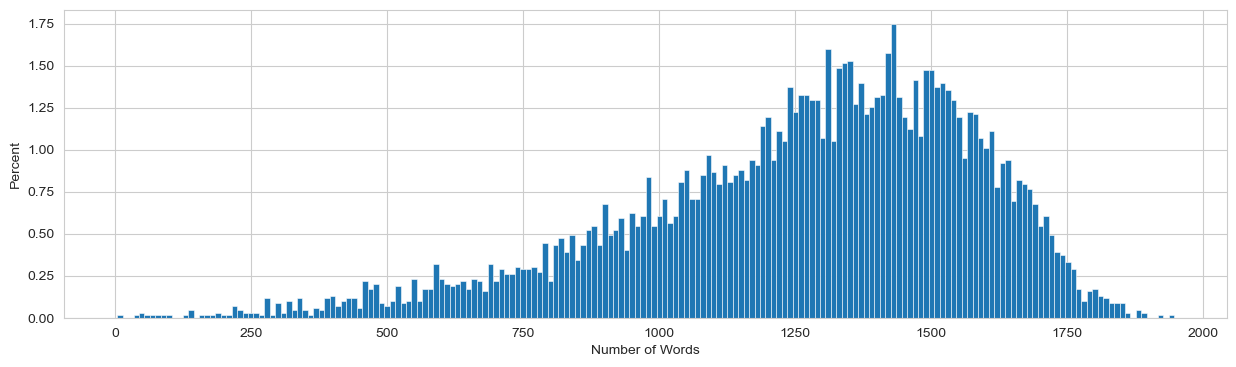

In [ ]:
user_words_num_pd = train_user.select("words_num").toPandas()

plt.figure(figsize=(15, 4))
sns.histplot(user_words_num_pd.words_num, stat="percent", binwidth=10, alpha=1);
plt.xlabel("Number of Words");

In [ ]:
print(f"{len(user_words_num_pd.loc[user_words_num_pd.words_num<250]) / len(user_words_num_pd)*100:.4f}%")

0.4615%


Not even 0.5% of the users have written fewer than 249 words, so we can exclude those users to reduce noise and ensure that the model has enough tokens to learn from. We could even consider removing users with higher word counts if we wanted the sequence lengths to be distributed more evenly (remember that 512 is the maximum token sequence length for standard BERT).

In [ ]:
# split the remaining data into a training and validation set
tr_user, val_user = stratified_split(
    train_user.select("user_id", "type_num", "posts"),  # resetting train_user to the original
    0.8,
    "type_num"
)

Since the datasets on the user level are not split by posts, triple pipes "|||" separating the posts of each user are still present. Therefore, we need a transformer class to remove them.

In [ ]:
class remove_triple_pipes(Transformer):
    def __init__(self, inputCol, outputCol):
        super().__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        return dataset.withColumn(self.outputCol, F.regexp_replace(F.col(self.inputCol), r"\|\|\|", " "))

We have to slightly adjust the pipeline, instantiate the transformers, use the different column names for the inputs (e.g., `posts` instead of just `post`), and fit this new pipeline. 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, CountVectorizer, NGram

remove_triple_pipes_transformer = remove_triple_pipes(inputCol="posts", outputCol="cleaned_posts")
count_links_transformer = CountLinksTransformer(inputCol="cleaned_posts", outputCol="links_num")
replace_links_transformer = ReplaceLinksTransformer(inputCol="cleaned_posts", outputCol="cleaned_posts")
clean_encoding_html_transformer = CleanEncodingHtmlTransformer(inputCol="cleaned_posts")
punctuation_removal_transformer = PunctuationRemovalTransformer(inputCol="cleaned_posts")
words_num_transformer = WordsNumTransformer(inputCol="cleaned_posts", outputCol="words_num")
word_filter_transformer = WordFilterTransformer(inputCol="words_num", minWords=250)
chars_num_transformer = CharsNumTransformer(inputCol="cleaned_posts", outputCol="chars_num")
chars_filter_transformer = CharsFilterTransformer(inputCol="chars_num", maxChars=230)
chars_per_word_transformer = RatioTransformer(inputNumeratorCol="chars_num", inputDenominatorCol="words_num",
                                              outputCol="chars_per_word")

# tokenization, stopword removal & lower casing:
lemmatize_transformer = LemmatizeTransformer(inputCol="cleaned_posts",
                                             outputCol="normalized_posts")

# scale the numerical features to boundaries 0-1:
scaling_stages = []
columns_to_scale = ["links_num", "words_num", "chars_num", "chars_per_word"]

# Create a vector assembler for each column, so that MinMaxScaler can transform them and add them to scaling_stages
for column in columns_to_scale:
    assembler = VectorAssembler(inputCols=[column], outputCol=f"{column}_vector")
    scaler = MinMaxScaler(inputCol=f"{column}_vector", outputCol=f"{column}_scaled")
    scaling_stages.extend([assembler, scaler])

# create n-gram features
ngram_stages = []
ngrams = ["unigrams", "bigrams", "trigrams"]
for i, ngram in enumerate(ngrams, 1):
    ngram_transformer = NGram(n=i, inputCol="normalized_posts", outputCol=ngram)
    ngram_stages.extend([ngram_transformer])

# combine the resulting n-gram columns into one
ngram_concatenate_transformer = NgramConcatenateTransformer(inputCols=ngrams, outputCol="all_ngrams")

# now we can get the vocabSize most frequent features no matter which n-gram they are:
count_vectorizer = CountVectorizer(inputCol="all_ngrams", outputCol="raw_features", vocabSize=1200)

vec_assembler = VectorAssembler(
    inputCols=["raw_features", "links_num_scaled", "words_num_scaled", "chars_num_scaled", "chars_per_word_scaled"],
    outputCol="features")

user_pipeline_classic = Pipeline(stages=[
    remove_triple_pipes_transformer,
    count_links_transformer,
    replace_links_transformer,
    clean_encoding_html_transformer,
    punctuation_removal_transformer,
    words_num_transformer, 
    chars_num_transformer,
    chars_per_word_transformer,
    word_filter_transformer,
    lemmatize_transformer
] + scaling_stages + ngram_stages + [
    ngram_concatenate_transformer,
    count_vectorizer,
    vec_assembler
])

user_pl_classic_model = user_pipeline_classic.fit(tr_user)
tr_user_out = user_pl_classic_model.transform(tr_user)
val_user_out = user_pl_classic_model.transform(val_user)

We compute class weights to address the imbalanced class distribution:

In [ ]:
class_distribution = tr_user_out.groupBy("type_num").count().collect()
total_samples = tr_user_out.count()
num_classes = len(class_distribution)

class_weights_user = {
    row["type_num"]: total_samples / (num_classes * row["count"])
    for row in class_distribution
}

class_weights_user_map = F.create_map([F.lit(x) for x in chain(*class_weights_user.items())])

tr_user_out = tr_user_out.withColumn("class_weights", class_weights_user_map[F.col("type_num")])

Now we train an XGBoost model. We could also fit a logistic regression or a random forest, and given the reduced dataset size, even a support vector machine with a nonlinear kernel would be an option, yielding results quite close to XGBoost. However, for simplicity and conciseness, **we focus on training an XGBoost model**, as it performs best among these models.

#### XGBoost

In [ ]:
from xgboost.spark import SparkXGBClassifier

spark.conf.set("spark.sql.shuffle.partitions", "200")

# define xgb with the xgb_params
xgb = SparkXGBClassifier(features_col="features",
                         label_col="type_num",
                         weight_col="class_weights",
                         num_class=16,
                         eta=0.3,
                         tree_method="hist",
                         max_bin=256,
                         max_depth=6,
                         min_child_weight=1
                         )
xgb_model = xgb.fit(tr_user_out)

2025-05-13 09:51:43,021 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_bin': 256, 'max_depth': 6, 'min_child_weight': 1, 'tree_method': 'hist', 'num_class': 16, 'eta': 0.3, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-05-13 09:53:41,908 INFO XGBoost-PySpark: _train_booster Training on CPUs
[09:53:42] Task 0 got rank 0
2025-05-13 09:53:58,930 INFO XGBoost-PySpark: _fit Finished xgboost training!


Here, we can reuse our helper functions for evaluation:

In [ ]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1000")

tr_boost_pred, tr_boost_metrics = get_pred_metrics(tr_user_out, xgb_model)
val_boost_pred, val_boost_metrics = get_pred_metrics(val_user_out, xgb_model)

print(f"Training accuracy: {np.round(tr_boost_metrics.accuracy, 4)}\n"
      f"Validation accuracy: {np.round(val_boost_metrics.accuracy, 4)}")

2025-05-13 10:47:16,023 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-13 10:48:55,281 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
/Users/moritzgrimm/miniforge3/envs/MBTI/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
2025-05-13 10:49:46,522 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-05-13 10:50:16,097 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Training accuracy: 1.0
Validation accuracy: 0.3009


Although we achieved a much higher validation accuracy of 30% compared to training on single posts, we are also facing **severe overfitting** as indicated by the perfect 100% accuracy on the training set. This means the model memorized the training patterns perfectly but **did not really learn general patterns from the data**, suggesting that the high validation accuracy might not hold up when tested on another third dataset.

We could try stricter regularization (like reducing tree depth or tweaking other hyperparameters) or using a smaller vocabulary to make the model generalize better, though this would likely lower the validation accuracy a bit too.

However, if we wanted to deploy this model in a real-world setting, we **would need fairly long texts** from each user (around 1500 words) to get decent results since the model relies heavily on n-gram counts. Shorter texts would likely lack enough frequent n-grams for accurate predictions, even though it is less likely with texts of this length.

Before putting more effort into this classic approach, let us see how a model using BERT embeddings performs as it does not just rely on frequency counts but also considers context and different writing styles, which might help with generalization. Plus the standard BERT model only accepts sequence lengths up to 512 tokens, so if it generalizes better, we would only need even smaller texts.

Since tree-based models make it easy to extract feature importance scores, we will also take a quick look at the key features from this model.

#### Feature Importance

Therefore, we create a dataframe with two columns: The feature names of the actually used features (since XGBoost only keeps features with a certain level of importance), and their corresponding importance scores:

In [ ]:
# create a list with the feature namesTherefore, we need to create dataframe with two columns on
# get all n-grams names of all n-gram Count Vectorizer Stages
vocab_user = [ngram for stage in user_pl_classic_model.stages if str(stage).startswith("CountVectorizer")
              for ngram in stage.vocabulary]
feature_names_user = vocab_user + ["links_num_scaled", "words_num_scaled", "chars_num_scaled", "chars_per_word_scaled"]

# get the underlying booster from the model
booster_user = xgb_model.get_booster()

# get the average improvement of prediction quality when a given feature is used
importance_user = booster_user.get_score(importance_type='gain')

# xgboost only uses relevant features, so the number of the actually used features is smaller than feature_names_user
# the keys of the importance_user dict tell us the index of the originally created vocabulary like "f0", "f12", etc.
importance_user_pd = pd.DataFrame({"Feature Names": [feature_names_user[int(key[1:])] for key in importance_user],
                                   "Importance Value": importance_user.values()})

Let us take a brief look at the distribution of the importance scores.

In [ ]:
importance_user_pd["Importance Value"].describe()

count    1195.000000
mean        1.866987
std         2.102765
min         0.099042
25%         0.884737
50%         1.311322
75%         2.075896
max        26.830957
Name: Importance Value, dtype: float64

The range is quite large, but very high values are rare, as the third quartile is only at 2.08, while the maximum reaches 26.83. Accordingly, the mean and the standard deviation remain very low. This is not uncommon when using many features, as we do here.

Even more interesting is **which n-grams achieved the highest importance scores**. The following plot shows the 20 most important ones:

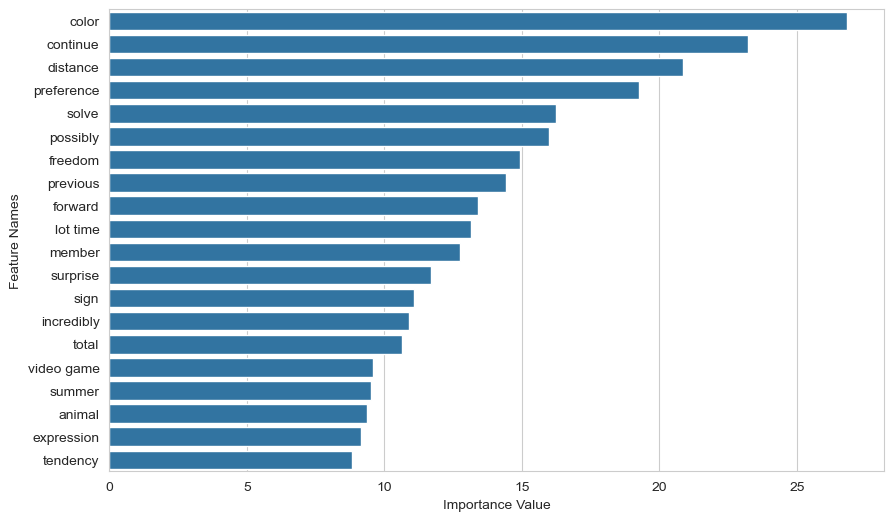

In [ ]:
importance_user_sorted = importance_user_pd.sort_values("Importance Value", ascending=False)

# plot the first 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(importance_user_sorted[:20], x="Importance Value", y="Feature Names");

There seems **to be nothing wrong with these features**. My first thought was that "color" might be connected to some types (you can find color attributions for the different types on the internet), but when I inspected the contexts, where this word appears, they seemed quite diverse. So, there is no need to be concerned about that.

However, despite masking the type names, **we still find some typical MBTI vocabulary** such as "si" and "fe" in the feature names scoring above the median, which are highly unlikely to occur in everyday language and might correlate with certain types and introduce additional bias in word-based models (however, the validity of these concepts, known as functions, is even inside the MBTI community highly debated). \
Therefore, masking or removing these words might be beneficial if we continued to pursue this classical approach with word counts. Since BERT embeddings focus more on contextual information and are therefore less sensitive to such isolated tokens, **we can leave them as they are for now**.

Finally, before proceeding to the BERT embedding approach, we want to check how important the engineered features are.

In [ ]:
engineered_features = ["links_num_scaled", "words_num_scaled", "chars_num_scaled", "chars_per_word_scaled"]

importance_user_sorted.loc[importance_user_pd["Feature Names"].isin(engineered_features)]

,Feature Names,Importance Value
1191,links_num_scaled,2.595660
1193,chars_num_scaled,2.182144
1194,chars_per_word_scaled,1.879731
1192,words_num_scaled,1.520033


All of these features have importance values above the median, with the **number of links in a post as being the most important one**. However this is a feature that is bound **closely to online posts rather than everyday communication**, as we expect online media users to share a higher number of links. \
Interestingly, the number of characters used is more important than the number of words, probably because this more precisely captures the length of posts. The average length of words (chars_per_word_scaled) ranks in between these two measures.

Now we prepare the data to build a neural net based on BERT embeddings.

### BERT Embeddings

#### Data Preprocessing in Pyspark

For the pipeline, I added the **number of words** as an additional feature this time, since it carries some **raw information across all posts** of the user. However, I **discarded the number of links**, as it seemed too strongly tied to social media talk and not beneficial for everyday communication (as mentioned above).

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# instantiate transformers
replace_links_transformer = ReplaceLinksTransformer(inputCol="posts", outputCol="cleaned_posts")
lower_transformer = LowerTransformer(inputCol="cleaned_posts")
words_num_transformer = WordsNumTransformer(inputCol="cleaned_posts", outputCol="words_num")
word_filter_transformer = WordFilterTransformer(inputCol="words_num",
                                                minWords=250)  # only 0.5% of the users' posts wrote fewer words
chars_num_transformer = CharsNumTransformer(inputCol="cleaned_posts", outputCol="chars_num")
chars_per_word_transformer = RatioTransformer(inputNumeratorCol="chars_num", inputDenominatorCol="words_num",
                                              outputCol="chars_per_word")
clean_encoding_html_transformer = CleanEncodingHtmlTransformer(inputCol="cleaned_posts")

# scale the numerical features to boundaries 0-1:
scaling_stages = []
columns_to_scale = ["words_num", "chars_num", "chars_per_word"]

# Create a vector assembler for each column, so that MinMaxScaler can transform them and add them to scaling_stages
for column in columns_to_scale:
    assembler = VectorAssembler(inputCols=[column], outputCol=f"{column}_vector")
    scaler = MinMaxScaler(inputCol=f"{column}_vector", outputCol=f"{column}_scaled")
    scaling_stages.extend([assembler, scaler])

# As the number of links is tied closely to online media posts we do not use it anymore:
cols_to_floats = ["words_num_scaled", "chars_num_scaled", "chars_per_word_scaled"]
vec2float_transformer = Vec2FloatTransformer(cols_to_floats)

# pipeline for the pytorch usage
user_pipeline_torch = Pipeline(stages=[replace_links_transformer,
                                       lower_transformer,
                                       words_num_transformer,
                                       word_filter_transformer,
                                       chars_num_transformer,
                                       chars_per_word_transformer,
                                       clean_encoding_html_transformer
                                       ] + scaling_stages + [vec2float_transformer]
                               )

# apply the pipeline on the small tr and val datasets
user_pl_model_torch = user_pipeline_torch.fit(tr_user)

tr_user_pd = user_pl_model_torch.transform(tr_user).toPandas()
val_user_pd = user_pl_model_torch.transform(val_user).toPandas()
test_user_pd = user_pl_model_torch.transform(test_user).toPandas()

Here is the resulting training dataframe as an example:

In [ ]:
tr_user_pd

,type_num,user_id,posts,cleaned_posts,words_num,chars_num,chars_per_word,words_num_vector,words_num_scaled,chars_num_vector,chars_num_scaled,chars_per_word_vector,chars_per_word_scaled
0,8,8589935243,'You are 92% HSP. - I'm not surprised..|||Sun:...,'you are 92% hsp. - i'm not surprised..|||sun:...,1301,7179,5.518063,[1301.0],0.615155,[7179.0],0.660644,[5.518063028439662],0.355856
1,9,25769804184,Trying to figure out a long-term career goal h...,trying to figure out a long-term career goal h...,1257,7034,5.595863,[1257.0],0.588902,[7034.0],0.643740,[5.595863166268894],0.390332
2,10,60129542276,"'Put it this way, my parents have been married...","'put it this way, my parents have been married...",1343,7349,5.472077,[1343.0],0.640215,[7349.0],0.680462,[5.4720774385703645],0.335479
3,13,249,'I am married to an ISTJ. We get on really wel...,'i am married to an MBTITYPE. we get on really...,1677,9378,5.592129,[1677.0],0.839499,[9378.0],0.916997,[5.5921288014311274],0.388677
4,3,34359739174,"'Just by using the terms before and after, we ...","'just by using the terms before and after, we ...",1174,7028,5.986371,[1174.0],0.539379,[7028.0],0.643040,[5.986371379897785],0.563379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,11,51539607812,"'Ultimately, my ideal day wouldn't be about do...","'ultimately, my ideal day wouldn't be about do...",1401,7945,5.670949,[1401.0],0.674821,[7945.0],0.749942,[5.67094932191292],0.423605
5508,10,51539608426,"'INJ, same as now. Though I do think I was sli...","'inj, same as now. though i do think i was sli...",1411,7751,5.493267,[1411.0],0.680788,[7751.0],0.727326,[5.49326718639263],0.344869
5509,9,42949673969,'I Never Find Perfection.|||ExFP would be my g...,'i never find perfection.|||exfp would be my g...,1512,8980,5.939153,[1512.0],0.741050,[8980.0],0.870599,[5.939153439153439],0.542455
5510,10,42949673083,"62337 Excuse the baggy eyes, I'm a little bit...","62337 excuse the baggy eyes, i'm a little bit ...",693,3982,5.746032,[693.0],0.252387,[3982.0],0.287946,[5.746031746031746],0.456877


With the data in the proper format, we can now proceed with the Pytorch preprocessing.

#### Pytorch Preprocessing

##### Data Preparation

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

post_feature_col = "cleaned_posts"
other_feature_cols = ["words_num_scaled", "chars_num_scaled", "chars_per_word_scaled"]
labels_col = "type_num"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", clean_up_tokenization_spaces=True)


# Create datasets
train_user_dataset = PostsDataset(tr_user_pd, tokenizer, max_length=512,
                             other_feature_cols=other_feature_cols,
                             post_feature_col=post_feature_col,
                             labels_col=labels_col)
val_user_dataset = PostsDataset(val_user_pd, tokenizer, max_length=512,
                           other_feature_cols=other_feature_cols,
                           post_feature_col=post_feature_col,
                           labels_col=labels_col)

# Create DataLoaders
generator = torch.Generator(device=device)

batch_size = 48

train_user_loader = DataLoader(train_user_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True,
                               generator=generator)  # 0 as it interferes with tokenizer
val_user_loader = DataLoader(val_user_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

And we need also class weights again:

In [ ]:
user_label_counts = tr_user_pd[labels_col].value_counts().sort_index()
user_total = len(tr_user_pd)
user_num_classes = len(user_label_counts)
user_class_weights = user_total / (user_num_classes * user_label_counts)
user_class_weights_torch = torch.tensor(user_class_weights.values, dtype=torch.float32)

We instantiate the model and move it to the defined device:

In [ ]:
user_bert_model = BertClassifier(other_features_dim=len(other_feature_cols),
                                 hidden_num=2,
                                 hidden_size=64,
                                 num_classes=16,
                                 dropout_rate=0.3,
                                 activation_name="relu",
                                 use_additional_features=True)

# move the model to the current device
user_bert_model.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Now we can train the model on the user level data.

#### Model Training

In [ ]:
# list, how many bert layers (+ the pooling layer) are trained during each unfreezing phase
unfreeze_layers_list = [0, 1, 3]  # at 0 it is the defined default above

# this schedule defines the learning rates for each unfreezing phase
lr_schedule_list = [1e-4, 1e-5, 5e-6]

user_trainer = Trainer(user_bert_model,
                       train_user_loader,
                       val_user_loader,
                       lr_schedule_list,
                       unfreeze_layers_list,
                       optimizer_name="adam",
                       class_weights=user_class_weights_torch,
                       use_additional_features=True,  # we start with using the engineered features
                       use_dynamic_unfreezing=True,  # dynamic
                       use_tqdm=False,
                       patience=2,
                       patience_last_phase=2,
                       warmup_epochs=0,
                       num_epochs=20
                       )

user_trainer.train()

Epoch 1/20: Time: 793.07s | Train Loss: 2.7818, Train Acc: 0.0517 | Val Loss: 2.7752, Val Acc: 0.0842 
Epoch 1/20: Saved best model state: train acc = 0.0517, val acc = 0.0842
Epoch 2/20: Time: 830.10s | Train Loss: 2.7773, Train Acc: 0.0835 | Val Loss: 2.7721, Val Acc: 0.1403 
Epoch 2/20: Saved best model state: train acc = 0.0835, val acc = 0.1403
Epoch 3/20: Time: 847.82s | Train Loss: 2.7736, Train Acc: 0.1090 | Val Loss: 2.7699, Val Acc: 0.1683 
Epoch 3/20: Saved best model state: train acc = 0.1090, val acc = 0.1683
Epoch 4/20: Time: 859.16s | Train Loss: 2.7720, Train Acc: 0.0936 | Val Loss: 2.7701, Val Acc: 0.1547 
Epoch 5/20: Time: 886.03s | Train Loss: 2.7695, Train Acc: 0.1083 | Val Loss: 2.7689, Val Acc: 0.1525 
Epoch 5/20: Adjusted Learning Rate to 1.0e-05
Epoch 5/20: Unfroze 1 layers due to plateau
Epoch 6/20: Time: 1679.19s | Train Loss: 2.7721, Train Acc: 0.1107 | Val Loss: 2.7683, Val Acc: 0.1719 
Epoch 6/20: Saved best model state: train acc = 0.1107, val acc = 0.1719

Before evaluating the model, we save it:

In [ ]:
PATH = "PytorchModel_DynamicUnfreezing.pth"
save_torch_checkpoint(user_bert_model, user_trainer, PATH)

Saved checkpoint for dict_keys(['_init_args', 'model_state_dict', 'optimizer_state_dict', 'model_last_state_dict', 'optimizer_last_state_dict', 'history']) to PytorchModel_DynamicUnfreezing.pth


Saving the model allows to reuse it without retraining it:

In [ ]:
PATH = "PytorchModel_DynamicUnfreezing.pth"

model_checkpoint = torch.load(PATH, weights_only=True)

# instantiate a new model from the checkpoint with the same arguments like the saved one
loaded_model = BertClassifier(**model_checkpoint["_init_args"])

# load the weights 
loaded_model.load_state_dict(model_checkpoint["model_state_dict"])

<All keys matched successfully>

We check the training accuracy during inference again:

In [ ]:
tr_user_probs, tr_user_preds, tr_user_trues = loaded_model.predict(dataset=train_user_dataset, use_tqdm=False)

get_acc_from_tensors(tr_user_trues, tr_user_preds, "user training set")

Accuracy on the user training set: 16.94%


This value is again higher than the highest training accuracy during training due to the Dropout layers and higher than our weighted baseline of 6.25%. We also want to know how well the model distinguishes the different classes:

In [ ]:
def formatted_na(trues, preds):
    print(f"{compute_na(trues, preds) * 100:.2f}%")

formatted_na(tr_user_trues, tr_user_preds)

6.75%


This is **only slightly better than the baseline** indicating that the model is probably relying on only one or few classes. A glance on the confusion matrices confirms this. Nevertheless, the weights worked (otherwise the most frequent class in the dataset (INFP) would also be the most frequent predicted class):

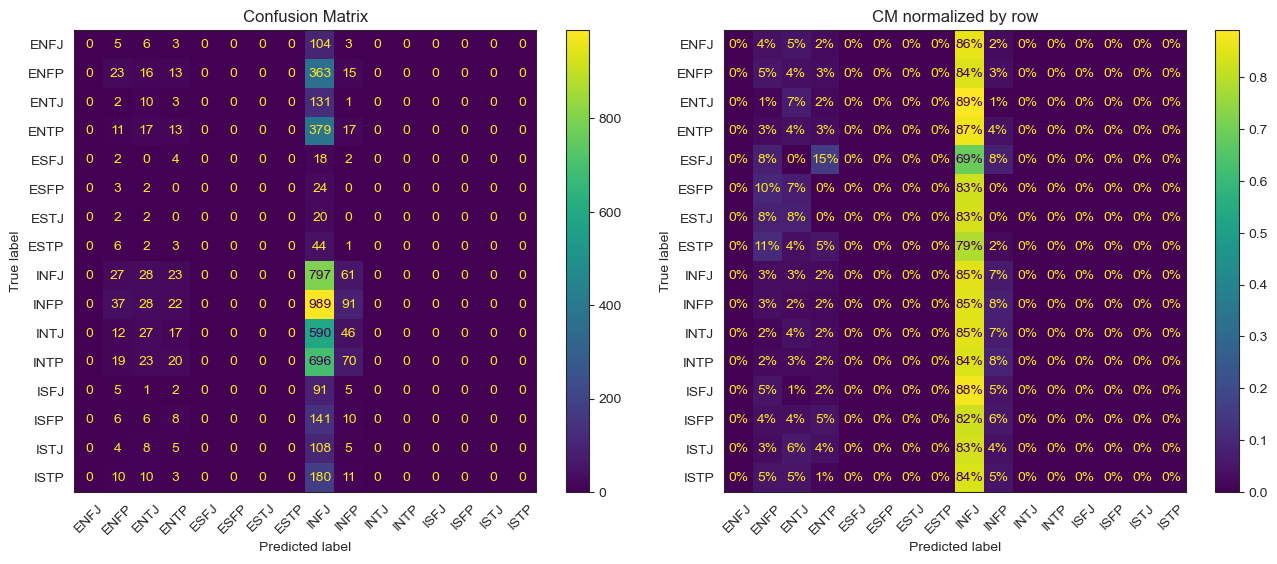

In [ ]:
PlotConfusionMatrix(tr_user_trues.to("cpu"), tr_user_preds.to("cpu"))

We already know that the highest accuracy on the validation set is 17.2%, and we do not expect the model to distinguish the classes better than it does on the training set:

In [ ]:
val_user_probs, val_user_preds, val_user_trues = loaded_model.predict(dataset=val_user_dataset, use_tqdm=False)
formatted_na(val_user_trues, val_user_preds)

6.60%


A normalized (macro) accuracy of 6.6% is on the same level as on the training set, and the confusion matrices confirm that the model keeps predicting INFJ in that case as well. \
However, **when we load the model state from the end of training, we observe a lower accuracy** on the validation set, **but the model is capable to distinguish the classes better** — similar to what we saw at the single-post level:

In [ ]:
loaded_model_last_state = BertClassifier(**model_checkpoint["_init_args"])
loaded_model_last_state.load_state_dict(model_checkpoint["model_last_state_dict"])

_, tr_user_last_preds, tr_user_last_trues = loaded_model_last_state.predict(dataset=train_user_dataset, use_tqdm=False)

get_acc_from_tensors(tr_user_last_trues, tr_user_last_preds, "user training set")

Accuracy on the user training set: 10.40%


In [ ]:
formatted_na(tr_user_last_trues, tr_user_last_preds)

12.80%


The confusion matrix confirms that visually with a bit more "chaos" or more vertical stripes (the class weights were still influencing the model):

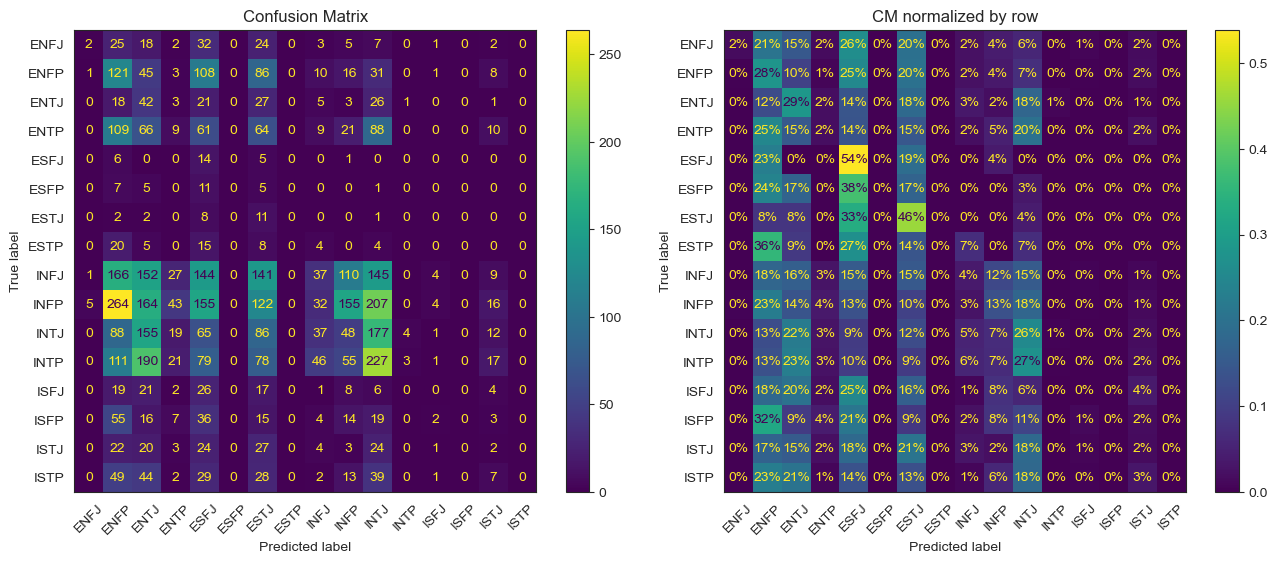

In [ ]:
PlotConfusionMatrix(tr_user_last_trues.to("cpu"), tr_user_last_preds.to("cpu"))

We can conclude that the **model also needs for the user-level data more epochs to adapt to the class weights properly**. \
However, before continuing training for more epochs, we first want to find the best hyperparameter configuration. At the same time, we also **want to check whether the engineered features** (word and character counts but also the character per word ratio) **are worth the effort to include them in the final training**. Therefore, we conduct an ablation study and **train the same model twice: Once with these features and once without them**. If training does not run substantially better when we include these featuers, we should consider omitting them from both the hyperparameter tuning and the final training.

### Ablation Study: Do We Need the Engineered Features?

First, we train the model with the engineered features.

##### With engineered features

In [ ]:
ablation_epochs=6

eng_featured_model = BertClassifier(other_features_dim=len(other_feature_cols),
                                    hidden_num=2,
                                    hidden_size=64,
                                    num_classes=16,
                                    dropout_rate=0.3,
                                    activation_name="relu",
                                    use_additional_features=True)

eng_featured_model.to(device)

ablation_lr_schedule_list = [1e-4,  # Fully frozen layers
                             1e-5,  # When first unfreezing 1 layer and pooler
                             5e-6   # When unfreezing the last 3 layers
                             ]

ablation_unfreeze_layers_list = [0, 1, 3]  # at 0 it is the defined default above

eng_feat_trainer = Trainer(eng_featured_model,
                           train_user_loader,
                           val_user_loader,
                           ablation_lr_schedule_list,
                           ablation_unfreeze_layers_list,
                           optimizer_name="adam",
                           class_weights=user_class_weights_torch,
                           use_additional_features=True,
                           use_dynamic_unfreezing=False,  # for better comparability we use static unfreezing
                           num_epochs_per_unfreeze_phase=2,
                           use_tqdm=False,
                           patience=0,  # static
                           patience_last_phase=0,  # static
                           warmup_epochs=0,
                           num_epochs=ablation_epochs
                           )

eng_feat_trainer.train()

Epoch 1/6: Time: 796.04s | Train Loss: 2.7761, Train Acc: 0.0521 | Val Loss: 2.7730, Val Acc: 0.0748 
Epoch 1/6: Saved best model state: train acc = 0.0521, val acc = 0.0748
Epoch 2/6: Time: 820.55s | Train Loss: 2.7768, Train Acc: 0.0599 | Val Loss: 2.7713, Val Acc: 0.0424 
Epoch 2/6: Adjusted Learning Rate to 1.0e-05
Epoch 2/6: Unfroze 1 layers due to schedule
Epoch 3/6: Time: 1668.19s | Train Loss: 2.7711, Train Acc: 0.0708 | Val Loss: 2.7710, Val Acc: 0.0676 
Epoch 4/6: Time: 1547.55s | Train Loss: 2.7697, Train Acc: 0.0671 | Val Loss: 2.7713, Val Acc: 0.0561 
Epoch 4/6: Moved model, data and optimizer params to cpu
Epoch 4/6: Adjusted Learning Rate to 5.0e-06
Epoch 4/6: Unfroze 3 layers due to schedule
Epoch 5/6: Time: 6201.91s | Train Loss: 2.7697, Train Acc: 0.0713 | Val Loss: 2.7701, Val Acc: 0.0906 
Epoch 5/6: Saved best model state: train acc = 0.0713, val acc = 0.0906
Epoch 6/6: Time: 6148.08s | Train Loss: 2.7704, Train Acc: 0.0767 | Val Loss: 2.7694, Val Acc: 0.1086 
Epoch

In [ ]:
# save model and parameters
eng_feat_PATH = "PytorchModel_StaticUnfreezing_ablation_with_engineeredFeatures.pth"
save_torch_checkpoint(eng_featured_model, eng_feat_trainer, eng_feat_PATH)

Saved checkpoint for dict_keys(['_init_args', 'model_state_dict', 'optimizer_state_dict', 'model_last_state_dict', 'optimizer_last_state_dict', 'history']) to PytorchModel_StaticUnfreezing_ablation_with_engineeredFeatures.pth


Now we check how a model with the same configuration but without the engineered features performs:

##### Without engineered features

In [ ]:
# Create datasets without the engineered features
train_user_embed_only_dataset = PostsDataset(tr_user_pd, tokenizer, max_length=512,
                                  other_feature_cols=None,  # we want to exclude the other/engineered features
                                  post_feature_col=post_feature_col,
                                  labels_col=labels_col)
val_user_embed_only_dataset = PostsDataset(val_user_pd, tokenizer, max_length=512,
                                other_feature_cols=None,  # we want to exclude the other/engineered features
                                post_feature_col=post_feature_col,
                                labels_col=labels_col)

# Create DataLoaders from the newly created datasets
train_user_embed_only_loader = DataLoader(train_user_embed_only_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True,
                               generator=generator)  # 0 as it interferes with tokenizer
val_user_embed_only_loader = DataLoader(val_user_embed_only_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

# instantiate a new model without using the engineered features
embed_only_model = BertClassifier(other_features_dim=0,  # as we do not use other features
                                  hidden_num=2,
                                  hidden_size=64,
                                  num_classes=16,
                                  dropout_rate=0.3,
                                  activation_name="relu",
                                  use_additional_features=False)

embed_only_model.to(device)

# instantiate a new trainer without using the engineered features
embed_only_trainer = Trainer(embed_only_model,
                             train_user_embed_only_loader,
                             val_user_embed_only_loader,
                             ablation_lr_schedule_list,
                             ablation_unfreeze_layers_list,
                             optimizer_name="adam",
                             class_weights=user_class_weights_torch,
                             use_additional_features=False,
                             use_dynamic_unfreezing=False,  # for better comparability we use static unfreezing
                             num_epochs_per_unfreeze_phase=2,
                             use_tqdm=False,
                             patience=0,  # static
                             patience_last_phase=0,  # static
                             warmup_epochs=0,
                             num_epochs=ablation_epochs)

embed_only_trainer.train()

Epoch 1/6: Time: 896.05s | Train Loss: 2.7741, Train Acc: 0.1177 | Val Loss: 2.7701, Val Acc: 0.1288 
Epoch 1/6: Saved best model state: train acc = 0.1177, val acc = 0.1288
Epoch 2/6: Time: 943.35s | Train Loss: 2.7746, Train Acc: 0.1089 | Val Loss: 2.7698, Val Acc: 0.1705 
Epoch 2/6: Saved best model state: train acc = 0.1089, val acc = 0.1705
Epoch 2/6: Adjusted Learning Rate to 1.0e-05
Epoch 2/6: Unfroze 1 layers due to schedule
Epoch 3/6: Time: 2082.39s | Train Loss: 2.7698, Train Acc: 0.1277 | Val Loss: 2.7690, Val Acc: 0.1676 
Epoch 4/6: Time: 2032.96s | Train Loss: 2.7702, Train Acc: 0.1230 | Val Loss: 2.7682, Val Acc: 0.1662 
Epoch 4/6: Moved model, data and optimizer params to cpu
Epoch 4/6: Adjusted Learning Rate to 5.0e-06
Epoch 4/6: Unfroze 3 layers due to schedule
Epoch 5/6: Time: 6188.27s | Train Loss: 2.7735, Train Acc: 0.1254 | Val Loss: 2.7683, Val Acc: 0.1676 
Epoch 6/6: Time: 6193.33s | Train Loss: 2.7698, Train Acc: 0.1410 | Val Loss: 2.7677, Val Acc: 0.1719 
Epoch

In [ ]:
embed_only_PATH = "PytorchModel_StaticUnfreezing_ablation_embed_only.pth"
save_torch_checkpoint(embed_only_model, embed_only_trainer, embed_only_PATH)

Saved checkpoint for dict_keys(['_init_args', 'model_state_dict', 'optimizer_state_dict', 'model_last_state_dict', 'optimizer_last_state_dict', 'history']) to PytorchModel_StaticUnfreezing_ablation_embed_only.pth


This looks already better for the run without the engineered features, but for clarity let us visualize it:

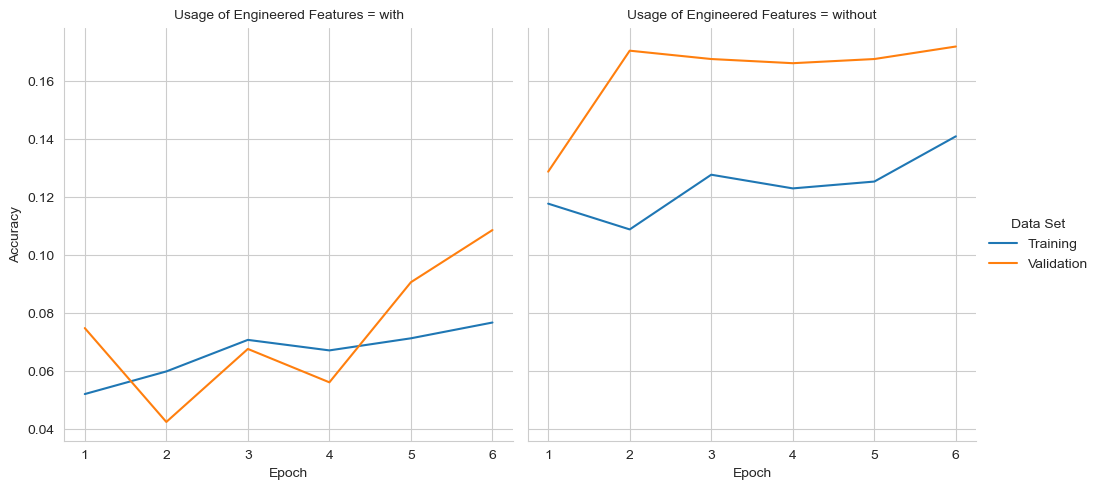

In [ ]:
ablation_pd = pd.DataFrame(
    {"Epoch": list(range(1, 7)) * 2,
     "Usage of Engineered Features": ["with"] * 6 + ["without"] * 6,
     "Training": eng_feat_trainer.history["train_acc"] + embed_only_trainer.history["train_acc"],
     "Validation": eng_feat_trainer.history["val_acc"] + embed_only_trainer.history["val_acc"]})


# reshape the data, that the columns that start with "train" or "val" are stacked in one column
ablation_pd_melted = ablation_pd.melt(id_vars=["Epoch", "Usage of Engineered Features"],
                                      var_name="Data Set",
                                      value_name="Accuracy")
ablation_pd_melted

sns.relplot(ablation_pd_melted,
            x="Epoch",
            y="Accuracy",
            hue="Data Set",
            col="Usage of Engineered Features",
            kind="line",
            aspect=1);

When examining the two plots, both runs achieved their best results in the last epoch. It is **obvious that the run without the engineered features performed much better** — both on the training and the validation set. While training accuracy converged similarly in both runs, it did so on a clearly higher level when the engineered features were not used.

Of course, with only six epochs, this could still be due to some lucky initialization of the weights. But given how clear the difference is, there is really no strong reason to keep the engineered features. **Not using them makes the pipeline, training, and prediction leaner and faster** — and that is always a plus.

Before making our final decision, we also want to take a look on the normalized accuracy (or macro accuracy/recall), starting with the model that includes the engineered features:

In [ ]:
_, val_feat_eng_user_preds, val_feat_eng_user_trues = eng_featured_model.predict(
    dataset=val_user_dataset,
    use_tqdm=False)

formatted_na(val_feat_eng_user_trues, val_feat_eng_user_preds)

6.90%


We check the macro accuracy for the run without the engineered features:

In [ ]:
_, val_embed_only_user_preds, val_embed_only_user_trues = embed_only_model.predict(
    dataset=val_user_embed_only_dataset,
    use_tqdm=False)

formatted_na(val_embed_only_user_trues, val_embed_only_user_preds)

6.50%


The value for the run with engineered features is **only slightly higher than that of the run without them**. Both runs likely still rely on the modal class to some extent.

However, since the difference is small and the version without engineered features is overall more efficient and performs better in terms of standard accuracy, **we will continue with hyperparameter tuning and the final model training _without_ the engineered features**.

### Hyperparameter Tuning

#### The Tuning

We use a slightly smaller dataset to speed up the hyperparameter tuning process:

In [ ]:
from sklearn.model_selection import train_test_split

# we do not all the training data for a fast hypertuning overview, so we reduce it to 100 batches
train_hp_pd = train_test_split(tr_user_pd,
                               train_size=(48 * 100),  # resulting 100 batches of size 48
                               random_state=14,
                               stratify=tr_user_pd["type_num"])[0]
train_hp_dataset = PostsDataset(train_hp_pd, tokenizer, other_feature_cols=other_feature_cols)
train_hp_loader = DataLoader(train_hp_dataset, batch_size=48, shuffle=True, generator=generator)

for name, tensor in zip(["Input_id", "Attention_mask", "Other features", "Label"], next(iter(train_hp_loader))):
    print(f"{name}: {tensor.shape[:]}")
print("Length dataloader: ", len(train_hp_loader))

Input_id: torch.Size([48, 512])
Attention_mask: torch.Size([48, 512])
Other features: torch.Size([48, 3])
Label: torch.Size([48])
Length dataloader:  100


Now we define our hyperparameter tuning function with `optuna`, which employs Bayesian hyperparameter optimization:

In [ ]:
import optuna

def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128, 256])
    hidden_num = trial.suggest_int("hidden_num", 1, 2)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    activation = trial.suggest_categorical("activation", ["relu", "silu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adamw", "adam", "sgd"])
    lr_phase_1 = trial.suggest_float("lr_phase_1", 1e-5, 5e-4, log=True)
    lr_phase_2 = trial.suggest_float("lr_phase_2", 1e-6, 5e-5, log=True)
    lr_phase_3 = trial.suggest_float("lr_phase_3", 1e-6, 1e-5, log=True)

    # instantiate the model
    model = BertClassifier(other_features_dim=len(other_feature_cols),
                           hidden_num=hidden_num,
                           hidden_size=hidden_size,
                           dropout_rate=dropout_rate,
                           activation_name=activation,
                           use_additional_features=False)

    # learning rate schedule and unfreezing plan
    lr_schedule = [lr_phase_1, lr_phase_2, lr_phase_3]
    unfreeze_layers_list = [0, 1, 3]  # static unfreeze plan

    # instantiate the trainer
    trainer = Trainer(model=model,
                      train_loader=train_hp_loader,
                      val_loader=val_loader,
                      class_weights=class_weights_torch,
                      lr_schedule_list=lr_schedule,
                      unfreeze_layers_list=unfreeze_layers_list,
                      patience=2,   # irrelevant here, because we use static unfreezing
                      patience_last_phase=2,
                      num_epochs=6,
                      optimizer_name=optimizer_name,
                      use_additional_features=False,  # only Bert Embeddings
                      use_dynamic_unfreezing=False,  # static unfreezing for better comparability of the trials
                      num_epochs_per_unfreeze_phase=2, 
                      warmup_epochs=0
                      )

    trainer.train()

    # Store metrics/logs with the trial
    trial.set_user_attr("history", trainer.history)  # holds the loss and accuracy of train and val for each epoch
    trial.set_user_attr("val_acc", trainer.best_val_acc_total)  # holds the overall best validation accuracy

    return trainer.best_val_acc_total

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-04-02 16:18:22,099] A new study created in memory with name: no-name-8cdaef48-904a-4810-976f-9dc2e2c660d1


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 779.09s | Train Loss: 2.7785, Train Acc: 0.0612 | Val Loss: 2.7710, Val Acc: 0.1644
Saved best model state with val acc: 0.1644


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 806.37s | Train Loss: 2.7749, Train Acc: 0.1017 | Val Loss: 2.7713, Val Acc: 0.1344
Adjusted Learning Rate to 3.4e-05
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1889.58s | Train Loss: 2.7719, Train Acc: 0.1288 | Val Loss: 2.7677, Val Acc: 0.1286


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 1787.04s | Train Loss: 2.7612, Train Acc: 0.1271 | Val Loss: 2.7561, Val Acc: 0.1442
Move model and data to cpu
Adjusted Learning Rate to 2.8e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5747.17s | Train Loss: 2.7446, Train Acc: 0.1531 | Val Loss: 2.7550, Val Acc: 0.0952


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5736.41s | Train Loss: 2.7439, Train Acc: 0.1073 | Val Loss: 2.7512, Val Acc: 0.1148
All scheduled layers unfrozen: Stopping.

Training completed after 279.1 minutes - Best Val Accuracy: 0.1644


[I 2025-04-02 20:57:33,389] Trial 0 finished with value: 0.1643598615916955 and parameters: {'hidden_size': 256, 'hidden_num': 2, 'dropout_rate': 0.1881812503086153, 'activation': 'relu', 'optimizer': 'adamw', 'lr_phase_1': 0.00019878155289095503, 'lr_phase_2': 3.396811375668842e-05, 'lr_phase_3': 2.8298125397704225e-06}. Best is trial 0 with value: 0.1643598615916955.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 869.80s | Train Loss: 2.7782, Train Acc: 0.0571 | Val Loss: 2.7704, Val Acc: 0.1534
Saved best model state with val acc: 0.1534


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 845.49s | Train Loss: 2.7796, Train Acc: 0.0942 | Val Loss: 2.7689, Val Acc: 0.1390
Adjusted Learning Rate to 2.2e-06
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1836.67s | Train Loss: 2.7669, Train Acc: 0.1365 | Val Loss: 2.7686, Val Acc: 0.1442


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 2083.96s | Train Loss: 2.7694, Train Acc: 0.1398 | Val Loss: 2.7683, Val Acc: 0.1574
Saved best model state with val acc: 0.1574
Move model and data to cpu
Adjusted Learning Rate to 2.1e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5751.70s | Train Loss: 2.7672, Train Acc: 0.1321 | Val Loss: 2.7673, Val Acc: 0.1448


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5765.83s | Train Loss: 2.7663, Train Acc: 0.1462 | Val Loss: 2.7669, Val Acc: 0.1534
All scheduled layers unfrozen: Stopping.

Training completed after 285.9 minutes - Best Val Accuracy: 0.1574


[I 2025-04-03 01:43:37,584] Trial 1 finished with value: 0.157439446366782 and parameters: {'hidden_size': 128, 'hidden_num': 2, 'dropout_rate': 0.26654448161822014, 'activation': 'silu', 'optimizer': 'adamw', 'lr_phase_1': 0.00031269656949996417, 'lr_phase_2': 2.242879553681524e-06, 'lr_phase_3': 2.0931862373397734e-06}. Best is trial 0 with value: 0.1643598615916955.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 823.99s | Train Loss: 2.7756, Train Acc: 0.0696 | Val Loss: 2.7763, Val Acc: 0.0519
Saved best model state with val acc: 0.0519


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 825.34s | Train Loss: 2.7740, Train Acc: 0.0646 | Val Loss: 2.7763, Val Acc: 0.0519
Adjusted Learning Rate to 1.8e-05
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1545.85s | Train Loss: 2.7747, Train Acc: 0.0673 | Val Loss: 2.7762, Val Acc: 0.0525
Saved best model state with val acc: 0.0525


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 2264.21s | Train Loss: 2.7748, Train Acc: 0.0690 | Val Loss: 2.7762, Val Acc: 0.0525
Move model and data to cpu
Adjusted Learning Rate to 1.2e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5772.35s | Train Loss: 2.7760, Train Acc: 0.0669 | Val Loss: 2.7762, Val Acc: 0.0525


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5730.06s | Train Loss: 2.7757, Train Acc: 0.0679 | Val Loss: 2.7762, Val Acc: 0.0525
All scheduled layers unfrozen: Stopping.

Training completed after 282.7 minutes - Best Val Accuracy: 0.0525


[I 2025-04-03 06:26:29,342] Trial 2 finished with value: 0.052479815455594 and parameters: {'hidden_size': 128, 'hidden_num': 2, 'dropout_rate': 0.13069582823113415, 'activation': 'relu', 'optimizer': 'sgd', 'lr_phase_1': 9.283955747711236e-05, 'lr_phase_2': 1.7603148590907435e-05, 'lr_phase_3': 1.1510710342134282e-06}. Best is trial 0 with value: 0.1643598615916955.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 825.33s | Train Loss: 2.7749, Train Acc: 0.0940 | Val Loss: 2.7758, Val Acc: 0.1275
Saved best model state with val acc: 0.1275


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 829.83s | Train Loss: 2.7737, Train Acc: 0.0898 | Val Loss: 2.7757, Val Acc: 0.1275
Adjusted Learning Rate to 1.6e-06
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1656.20s | Train Loss: 2.7741, Train Acc: 0.0827 | Val Loss: 2.7757, Val Acc: 0.1275


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 1627.45s | Train Loss: 2.7738, Train Acc: 0.0900 | Val Loss: 2.7757, Val Acc: 0.1275
Move model and data to cpu
Adjusted Learning Rate to 3.1e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5594.19s | Train Loss: 2.7746, Train Acc: 0.0890 | Val Loss: 2.7757, Val Acc: 0.1275


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5602.10s | Train Loss: 2.7732, Train Acc: 0.0873 | Val Loss: 2.7757, Val Acc: 0.1275
All scheduled layers unfrozen: Stopping.

Training completed after 268.9 minutes - Best Val Accuracy: 0.1275


[I 2025-04-03 10:55:35,525] Trial 3 finished with value: 0.12745098039215685 and parameters: {'hidden_size': 128, 'hidden_num': 1, 'dropout_rate': 0.18459209098517065, 'activation': 'silu', 'optimizer': 'sgd', 'lr_phase_1': 4.363468108011758e-05, 'lr_phase_2': 1.6372294715884427e-06, 'lr_phase_3': 3.129811480217139e-06}. Best is trial 0 with value: 0.1643598615916955.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 782.08s | Train Loss: 2.7886, Train Acc: 0.0910 | Val Loss: 2.7714, Val Acc: 0.0456
Saved best model state with val acc: 0.0456


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 831.24s | Train Loss: 2.7721, Train Acc: 0.0617 | Val Loss: 2.7783, Val Acc: 0.0104
Adjusted Learning Rate to 1.1e-06
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 2176.77s | Train Loss: 2.7781, Train Acc: 0.0537 | Val Loss: 2.7756, Val Acc: 0.0115


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 2719.54s | Train Loss: 2.7743, Train Acc: 0.0610 | Val Loss: 2.7744, Val Acc: 0.0133
Move model and data to cpu
Adjusted Learning Rate to 3.6e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5755.47s | Train Loss: 2.7729, Train Acc: 0.0719 | Val Loss: 2.7720, Val Acc: 0.0300


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5786.06s | Train Loss: 2.7714, Train Acc: 0.0671 | Val Loss: 2.7714, Val Acc: 0.0231
All scheduled layers unfrozen: Stopping.

Training completed after 300.9 minutes - Best Val Accuracy: 0.0456


[I 2025-04-03 15:56:38,204] Trial 4 finished with value: 0.04555940023068051 and parameters: {'hidden_size': 128, 'hidden_num': 1, 'dropout_rate': 0.21151775248223095, 'activation': 'relu', 'optimizer': 'adam', 'lr_phase_1': 0.0004230061278595811, 'lr_phase_2': 1.0741958457433094e-06, 'lr_phase_3': 3.646197560942489e-06}. Best is trial 0 with value: 0.1643598615916955.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 810.90s | Train Loss: 2.7843, Train Acc: 0.0431 | Val Loss: 2.7742, Val Acc: 0.0213
Saved best model state with val acc: 0.0213


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 920.32s | Train Loss: 2.7793, Train Acc: 0.0579 | Val Loss: 2.7721, Val Acc: 0.0254
Saved best model state with val acc: 0.0254
Adjusted Learning Rate to 1.2e-05
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1776.73s | Train Loss: 2.7681, Train Acc: 0.0531 | Val Loss: 2.7651, Val Acc: 0.0750
Saved best model state with val acc: 0.0750


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 2932.26s | Train Loss: 2.7607, Train Acc: 0.0942 | Val Loss: 2.7613, Val Acc: 0.0830
Saved best model state with val acc: 0.0830
Move model and data to cpu
Adjusted Learning Rate to 8.0e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5811.09s | Train Loss: 2.7522, Train Acc: 0.0925 | Val Loss: 2.7582, Val Acc: 0.1257
Saved best model state with val acc: 0.1257


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5804.20s | Train Loss: 2.7343, Train Acc: 0.0921 | Val Loss: 2.7439, Val Acc: 0.0928
All scheduled layers unfrozen: Stopping.

Training completed after 300.9 minutes - Best Val Accuracy: 0.1257


[I 2025-04-03 20:57:37,390] Trial 5 finished with value: 0.12572087658592848 and parameters: {'hidden_size': 128, 'hidden_num': 1, 'dropout_rate': 0.16373863599704727, 'activation': 'silu', 'optimizer': 'adamw', 'lr_phase_1': 0.00018933022899457922, 'lr_phase_2': 1.1703681266461775e-05, 'lr_phase_3': 7.968716830639749e-06}. Best is trial 0 with value: 0.1643598615916955.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 864.25s | Train Loss: 2.7786, Train Acc: 0.0956 | Val Loss: 2.7735, Val Acc: 0.0582
Saved best model state with val acc: 0.0582


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 827.20s | Train Loss: 2.7749, Train Acc: 0.1444 | Val Loss: 2.7702, Val Acc: 0.1811
Saved best model state with val acc: 0.1811
Adjusted Learning Rate to 1.8e-05
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 2671.43s | Train Loss: 2.7736, Train Acc: 0.1544 | Val Loss: 2.7696, Val Acc: 0.1903
Saved best model state with val acc: 0.1903


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 3616.28s | Train Loss: 2.7726, Train Acc: 0.1608 | Val Loss: 2.7693, Val Acc: 0.2053
Saved best model state with val acc: 0.2053
Move model and data to cpu
Adjusted Learning Rate to 1.3e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5806.03s | Train Loss: 2.7696, Train Acc: 0.1577 | Val Loss: 2.7687, Val Acc: 0.2116
Saved best model state with val acc: 0.2116


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5790.30s | Train Loss: 2.7713, Train Acc: 0.1527 | Val Loss: 2.7685, Val Acc: 0.2111
All scheduled layers unfrozen: Stopping.

Training completed after 326.3 minutes - Best Val Accuracy: 0.2116


[I 2025-04-04 02:23:59,160] Trial 6 finished with value: 0.2116493656286044 and parameters: {'hidden_size': 64, 'hidden_num': 2, 'dropout_rate': 0.28736897515976534, 'activation': 'relu', 'optimizer': 'adam', 'lr_phase_1': 0.0004016030402923394, 'lr_phase_2': 1.8269380605835166e-05, 'lr_phase_3': 1.2804130953631044e-06}. Best is trial 6 with value: 0.2116493656286044.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 862.43s | Train Loss: 2.7751, Train Acc: 0.1071 | Val Loss: 2.7747, Val Acc: 0.1194
Saved best model state with val acc: 0.1194


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 830.58s | Train Loss: 2.7748, Train Acc: 0.1129 | Val Loss: 2.7746, Val Acc: 0.1194
Adjusted Learning Rate to 1.7e-05
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1936.79s | Train Loss: 2.7742, Train Acc: 0.1073 | Val Loss: 2.7746, Val Acc: 0.1188


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 1764.95s | Train Loss: 2.7755, Train Acc: 0.1035 | Val Loss: 2.7746, Val Acc: 0.1176
Move model and data to cpu
Adjusted Learning Rate to 3.5e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5793.00s | Train Loss: 2.7750, Train Acc: 0.1021 | Val Loss: 2.7746, Val Acc: 0.1176


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5758.36s | Train Loss: 2.7756, Train Acc: 0.1069 | Val Loss: 2.7746, Val Acc: 0.1176
All scheduled layers unfrozen: Stopping.

Training completed after 282.4 minutes - Best Val Accuracy: 0.1194


[I 2025-04-04 07:06:35,457] Trial 7 finished with value: 0.11937716262975778 and parameters: {'hidden_size': 256, 'hidden_num': 2, 'dropout_rate': 0.12176924682129346, 'activation': 'relu', 'optimizer': 'sgd', 'lr_phase_1': 8.720063821953777e-05, 'lr_phase_2': 1.716591356085851e-05, 'lr_phase_3': 3.4691328834389176e-06}. Best is trial 6 with value: 0.2116493656286044.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 869.33s | Train Loss: 2.7865, Train Acc: 0.0633 | Val Loss: 2.7794, Val Acc: 0.0110
Saved best model state with val acc: 0.0110


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 843.41s | Train Loss: 2.7826, Train Acc: 0.0563 | Val Loss: 2.7681, Val Acc: 0.0819
Saved best model state with val acc: 0.0819
Adjusted Learning Rate to 1.0e-05
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 2447.99s | Train Loss: 2.7647, Train Acc: 0.1183 | Val Loss: 2.7640, Val Acc: 0.0854
Saved best model state with val acc: 0.0854


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 2725.99s | Train Loss: 2.7547, Train Acc: 0.1327 | Val Loss: 2.7581, Val Acc: 0.1188
Saved best model state with val acc: 0.1188
Move model and data to cpu
Adjusted Learning Rate to 1.1e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5798.18s | Train Loss: 2.7474, Train Acc: 0.1558 | Val Loss: 2.7566, Val Acc: 0.1361
Saved best model state with val acc: 0.1361


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5762.41s | Train Loss: 2.7443, Train Acc: 0.1481 | Val Loss: 2.7548, Val Acc: 0.1165
All scheduled layers unfrozen: Stopping.

Training completed after 307.5 minutes - Best Val Accuracy: 0.1361


[I 2025-04-04 12:14:05,191] Trial 8 finished with value: 0.13610149942329874 and parameters: {'hidden_size': 128, 'hidden_num': 1, 'dropout_rate': 0.14740399291398648, 'activation': 'silu', 'optimizer': 'adam', 'lr_phase_1': 0.00021912083810781698, 'lr_phase_2': 1.0242170028536685e-05, 'lr_phase_3': 1.0667606033808544e-06}. Best is trial 6 with value: 0.2116493656286044.


Train Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/6: Time: 860.96s | Train Loss: 2.7751, Train Acc: 0.0554 | Val Loss: 2.7734, Val Acc: 0.0323
Saved best model state with val acc: 0.0323


Train Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/6: Time: 821.50s | Train Loss: 2.7740, Train Acc: 0.0521 | Val Loss: 2.7733, Val Acc: 0.0323
Adjusted Learning Rate to 7.6e-06
Unfroze 1 layers due to schedule


Train Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/6: Time: 1775.88s | Train Loss: 2.7745, Train Acc: 0.0452 | Val Loss: 2.7733, Val Acc: 0.0323


Train Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/6: Time: 1800.70s | Train Loss: 2.7751, Train Acc: 0.0492 | Val Loss: 2.7733, Val Acc: 0.0323
Move model and data to cpu
Adjusted Learning Rate to 3.5e-06
Unfroze 3 layers due to schedule


Train Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/6: Time: 5717.38s | Train Loss: 2.7751, Train Acc: 0.0500 | Val Loss: 2.7733, Val Acc: 0.0323


Train Epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Val   Epoch 6:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/6: Time: 5741.56s | Train Loss: 2.7724, Train Acc: 0.0479 | Val Loss: 2.7733, Val Acc: 0.0323
All scheduled layers unfrozen: Stopping.

Training completed after 278.6 minutes - Best Val Accuracy: 0.0323


[I 2025-04-04 16:52:52,172] Trial 9 finished with value: 0.03229527104959631 and parameters: {'hidden_size': 128, 'hidden_num': 2, 'dropout_rate': 0.2681237312963453, 'activation': 'relu', 'optimizer': 'sgd', 'lr_phase_1': 0.00011977066208693073, 'lr_phase_2': 7.633307651474474e-06, 'lr_phase_3': 3.546428371584505e-06}. Best is trial 6 with value: 0.2116493656286044.


Do not worry about the "Error dsiplaying widget: model not found" lines. They are an artifact of using tqdm in the notebook, as we did not set use_tqdm=False this time.

We save the study results to a dataframe:

In [ ]:
study_results_pd = study.trials_dataframe()
study_results_pd.to_csv("study_results.csv", index=False)

#### Assemble the Dataframe with the Results 

Similar to the models, we can use the saved frame now and load them:

In [ ]:
study_pd = pd.read_csv("study_results.csv")
study_pd

,number,value,datetime_start,datetime_complete,duration,params_activation,params_dropout_rate,params_hidden_num,params_hidden_size,params_lr_phase_1,params_lr_phase_2,params_lr_phase_3,params_optimizer,user_attrs_history,user_attrs_val_acc,state
0,0,0.164360,2025-04-02 16:18:22.099777,2025-04-02 20:57:33.388546,0 days 04:39:11.288769,relu,0.188181,2,256,0.000199,0.000034,0.000003,adamw,"{'train_loss': [2.778537082672119, 2.774879426...",0.164360,COMPLETE
1,1,0.157439,2025-04-02 20:57:33.391600,2025-04-03 01:43:37.583182,0 days 04:46:04.191582,silu,0.266544,2,128,0.000313,0.000002,0.000002,adamw,"{'train_loss': [2.7781609582901, 2.77964561223...",0.157439,COMPLETE
2,2,0.052480,2025-04-03 01:43:37.586550,2025-04-03 06:26:29.341198,0 days 04:42:51.754648,relu,0.130696,2,128,0.000093,0.000018,0.000001,sgd,"{'train_loss': [2.7756358766555786, 2.77400156...",0.052480,COMPLETE
3,3,0.127451,2025-04-03 06:26:29.344421,2025-04-03 10:55:35.524479,0 days 04:29:06.180058,silu,0.184592,1,128,0.000044,0.000002,0.000003,sgd,"{'train_loss': [2.77488032579422, 2.7736835765...",0.127451,COMPLETE
4,4,0.045559,2025-04-03 10:55:35.527753,2025-04-03 15:56:38.203399,0 days 05:01:02.675646,relu,0.211518,1,128,0.000423,0.000001,0.000004,adam,"{'train_loss': [2.7885606050491334, 2.77206506...",0.045559,COMPLETE
5,5,0.125721,2025-04-03 15:56:38.206565,2025-04-03 20:57:37.389749,0 days 05:00:59.183184,silu,0.163739,1,128,0.000189,0.000012,0.000008,adamw,"{'train_loss': [2.7842611694335937, 2.77932434...",0.125721,COMPLETE
6,6,0.211649,2025-04-03 20:57:37.391087,2025-04-04 02:23:59.160279,0 days 05:26:21.769192,relu,0.287369,2,64,0.000402,0.000018,0.000001,adam,"{'train_loss': [2.7786254692077637, 2.77492193...",0.211649,COMPLETE
7,7,0.119377,2025-04-04 02:23:59.161254,2025-04-04 07:06:35.456548,0 days 04:42:36.295294,relu,0.121769,2,256,0.000087,0.000017,0.000003,sgd,"{'train_loss': [2.7750952410697938, 2.77483629...",0.119377,COMPLETE
8,8,0.136101,2025-04-04 07:06:35.458631,2025-04-04 12:14:05.190144,0 days 05:07:29.731513,silu,0.147404,1,128,0.000219,0.000010,0.000001,adam,"{'train_loss': [2.786472704410553, 2.782555954...",0.136101,COMPLETE
9,9,0.032295,2025-04-04 12:14:05.192037,2025-04-04 16:52:52.171110,0 days 04:38:46.979073,relu,0.268124,2,128,0.000120,0.000008,0.000004,sgd,"{'train_loss': [2.775133578777313, 2.773995344...",0.032295,COMPLETE


Since this model uses multiple unfreezing phases with separate learning rates, the **standard Optuna visualizations provide limited insight into stage-specific dynamics**. I therefore logged the full training history of each trial and exported it to CSV to **build custom plots that highlight trends across both learning stages and configurations**.

Due to a system crash during execution, I lost the persisted Optuna study object so I cannot rely at it for analysis at all. However, I had already exported the key results to the CSV file. Re-running the full tuning would have taken over two days, so this was a pragmatic workaround that still enables analysis and comparison of the trials. 

Nevertheless, **for the custom plots we need to assemble the data in a more cohesive style**:

In [ ]:
import ast

history_keys = list(eval(study_pd.user_attrs_history[0]).keys())

# create new columns in the dataframe with the history data as lists for each trial
for hist_key in history_keys:
    # use literal_eval although I could trust my own code and could use eval
    study_pd[hist_key] = [ast.literal_eval(row[1]["user_attrs_history"])[hist_key]
                          for row in study_pd.iterrows()]

# create lists of epoch numbers for each trial
study_pd["epoch_number"] = [list(range(1, len(history_keys) + 1)) for i in range(len(study_pd))]

# create a list of relevant columns: base identifier, model params (without learning rates) and history
relevant_param_cols = [col for col in study_pd.columns
                       if col.startswith("params")
                       and not col.startswith("params_lr")]  # we have the learning rate for each epoch in the history
relevant_cols = ["number", "epoch_number", "value"] + relevant_param_cols + history_keys

# select the relevant cols and explode history columns with lists at once
study_epochs_pd = study_pd[relevant_cols].explode(["epoch_number"] + history_keys)

# show the three best trials
study_epochs_pd.sort_values("value", ascending=False).head(18)

,number,epoch_number,value,params_activation,params_dropout_rate,params_hidden_num,params_hidden_size,params_optimizer,train_loss,train_acc,val_loss,val_acc,unfrozen_layers,learning_rate
6,6,5,0.211649,relu,0.287369,2,64,adam,2.769646,0.157708,2.768709,0.211649,3,0.000001
6,6,6,0.211649,relu,0.287369,2,64,adam,2.771259,0.152708,2.768525,0.211073,3,0.000001
6,6,4,0.211649,relu,0.287369,2,64,adam,2.77258,0.160833,2.769282,0.205306,1,0.000018
6,6,3,0.211649,relu,0.287369,2,64,adam,2.773604,0.154375,2.769617,0.190311,1,0.000018
6,6,2,0.211649,relu,0.287369,2,64,adam,2.774922,0.144375,2.770223,0.181084,0,0.000402
6,6,1,0.211649,relu,0.287369,2,64,adam,2.778625,0.095625,2.773502,0.058247,0,0.000402
0,0,2,0.164360,relu,0.188181,2,256,adamw,2.774879,0.101667,2.771293,0.134371,0,0.000199
0,0,1,0.164360,relu,0.188181,2,256,adamw,2.778537,0.06125,2.771018,0.16436,0,0.000199
0,0,6,0.164360,relu,0.188181,2,256,adamw,2.743887,0.107292,2.751172,0.114764,3,0.000003
0,0,5,0.164360,relu,0.188181,2,256,adamw,2.744592,0.153125,2.754974,0.095156,3,0.000003


We also want to check, how much the training and validation accuracy changed compared to the previous epoch for better analyses:

In [ ]:
# calculate the difference between the epochs of each run (this creates NAs for the first epoch):
study_epochs_pd[["train_acc_gain", "val_acc_gain"]] = study_epochs_pd.sort_values(["number", "epoch_number"])[["number", "train_acc", "val_acc"]].groupby(["number"]).diff()
baseline = 1/16  # as we used weighting we can assume a balanced training
mask_first_epoch = study_epochs_pd.epoch_number == 1

# now we assign the first epoch of each run the difference between the accuracy and the baseline:
study_epochs_pd.loc[mask_first_epoch, ["train_acc_gain", "val_acc_gain"]] = (
    study_epochs_pd.loc[mask_first_epoch, ["train_acc", "val_acc"]]
    - baseline
).values

# show results of first three trials
study_epochs_pd[["number", "epoch_number", "train_acc", "train_acc_gain", "val_acc", "val_acc_gain"]].head(18)

,number,epoch_number,train_acc,train_acc_gain,val_acc,val_acc_gain
0,0,1,0.06125,-0.00125,0.16436,0.10186
0,0,2,0.101667,0.040417,0.134371,-0.029988
0,0,3,0.12875,0.027083,0.128604,-0.005767
0,0,4,0.127083,-0.001667,0.144175,0.015571
0,0,5,0.153125,0.026042,0.095156,-0.04902
0,0,6,0.107292,-0.045833,0.114764,0.019608
1,1,1,0.057083,-0.005417,0.153403,0.090903
1,1,2,0.094167,0.037083,0.138985,-0.014418
1,1,3,0.136458,0.042292,0.144175,0.00519
1,1,4,0.139792,0.003333,0.157439,0.013264


Now that we have all the necessary metrics, we proceed with reshaping the data for proper visualization:

In [ ]:
id_vars = ["number", "epoch_number", "value", "unfrozen_layers", "learning_rate"] + relevant_param_cols

# reshape the data, that the columns that start with "train" or "val" are stacked in one column
study_pd_melted = study_epochs_pd.melt(id_vars=id_vars, var_name="metric_type", value_name="Value")

# extract from this new column columns that identify the set and the metric
study_pd_melted["set"] = study_pd_melted["metric_type"].str.extract(r"^(train|val)")
study_pd_melted["metric"] = study_pd_melted["metric_type"].str.extract(r"_(acc|acc_gain|loss)$")

# pivot the frame to create three new columns, one for each metric, distinguished by the set
study_pd_tidy = (study_pd_melted
                 .pivot_table(index=id_vars + ["set"], columns="metric", values="Value")
                 .reset_index()  # to get the id_vars back to columns
                 .rename_axis(None, axis=1))  # the row index was still named "metric"

# calculate the mean accuracy of every phase of unfrozen layers
study_pd_tidy["acc_gain_phase"] = (study_pd_tidy
                                   .groupby(["number", "unfrozen_layers", "set"])["acc_gain"]
                                   .transform("mean"))

# variable for epoch in phase of unfrozen_layers:
study_pd_tidy["epoch_in_phase"] = 2 - study_pd_tidy["epoch_number"] % 2

study_pd_tidy

,number,epoch_number,value,unfrozen_layers,learning_rate,params_activation,params_dropout_rate,params_hidden_num,params_hidden_size,params_optimizer,set,acc,acc_gain,loss,acc_gain_phase,epoch_in_phase
0,0,1,0.164360,0,0.000199,relu,0.188181,2,256,adamw,train,0.06125,-0.00125,2.778537,0.019583,1
1,0,1,0.164360,0,0.000199,relu,0.188181,2,256,adamw,val,0.16436,0.10186,2.771018,0.035936,1
2,0,2,0.164360,0,0.000199,relu,0.188181,2,256,adamw,train,0.101667,0.040417,2.774879,0.019583,2
3,0,2,0.164360,0,0.000199,relu,0.188181,2,256,adamw,val,0.134371,-0.029988,2.771293,0.035936,2
4,0,3,0.164360,1,0.000034,relu,0.188181,2,256,adamw,train,0.12875,0.027083,2.77191,0.012708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,9,4,0.032295,1,0.000008,relu,0.268124,2,128,sgd,val,0.032295,0.0,2.773301,0.0,2
116,9,5,0.032295,3,0.000004,relu,0.268124,2,128,sgd,train,0.05,0.000833,2.775123,-0.000625,1
117,9,5,0.032295,3,0.000004,relu,0.268124,2,128,sgd,val,0.032295,0.0,2.773299,0.0,1
118,9,6,0.032295,3,0.000004,relu,0.268124,2,128,sgd,train,0.047917,-0.002083,2.77245,-0.000625,2


Now we have all we need for creating an overall insight of the tuning.

#### General Overview of the Results

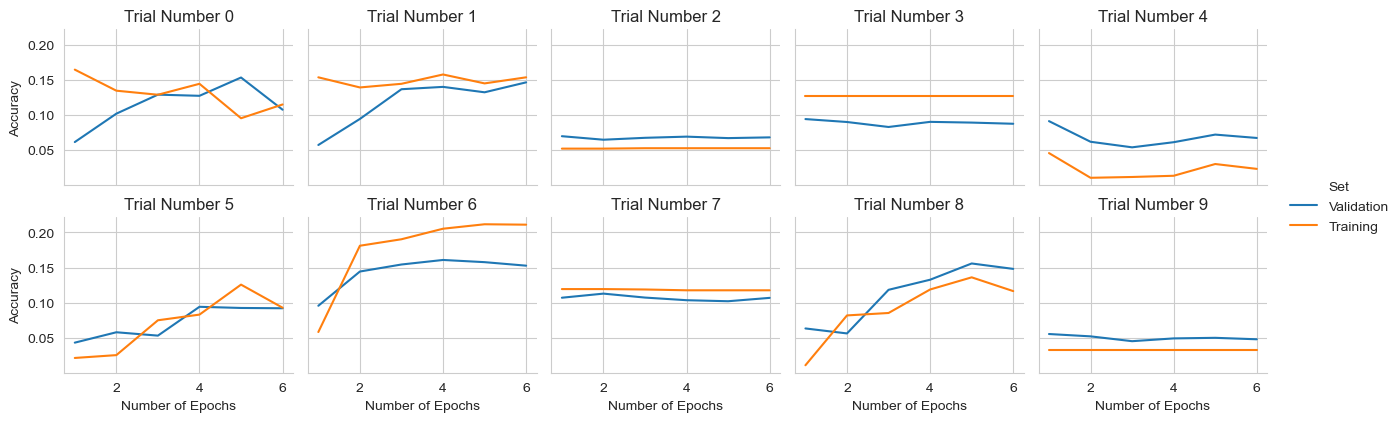

In [ ]:
sns.set_style("whitegrid");

g = sns.relplot(data=study_pd_tidy,
                x="epoch_number",
                y="acc",
                hue="set",
                col="number",
                col_wrap=5,
                height=2.15,
                aspect=1.2,
                kind="line");

# rename the color labels
for i, label in enumerate(["Validation", "Training"]):
    g._legend.texts[i].set_text(label);

g._legend.set_title("Set")
g._legend.set_bbox_to_anchor((1.025, 0.5))  # overlapped with plot

for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel("Number of Epochs");
    ax.set_ylabel("Accuracy");
    ax.set_title(f"Trial Number {i}");

When we look at this general overview there is a clear winner among this 10 trials: **Trial Number 6 does not only end up with the highest accuracy both on the validation and on the training set, but also converges best**. The training was still underfitting, so we could probably already use this configuration to train the final model on the cloud for more epochs. However, **it is wise to analyze the configurations across the trials to get the most of the tuning or confirm the configuration of Trial Number 6.** 

But first let us have a look at the **configuration of that trial**:

In [ ]:
study_pd_tidy.loc[study_pd_tidy.number==6]

,number,epoch_number,value,unfrozen_layers,learning_rate,params_activation,params_dropout_rate,params_hidden_num,params_hidden_size,params_optimizer,set,acc,acc_gain,loss,acc_gain_phase,epoch_in_phase
72,6,1,0.211649,0,0.000402,relu,0.287369,2,64,adam,train,0.095625,0.033125,2.778625,0.040938,1
73,6,1,0.211649,0,0.000402,relu,0.287369,2,64,adam,val,0.058247,-0.004253,2.773502,0.059292,1
74,6,2,0.211649,0,0.000402,relu,0.287369,2,64,adam,train,0.144375,0.04875,2.774922,0.040938,2
75,6,2,0.211649,0,0.000402,relu,0.287369,2,64,adam,val,0.181084,0.122837,2.770223,0.059292,2
76,6,3,0.211649,1,0.000018,relu,0.287369,2,64,adam,train,0.154375,0.01,2.773604,0.008229,1
77,6,3,0.211649,1,0.000018,relu,0.287369,2,64,adam,val,0.190311,0.009227,2.769617,0.012111,1
78,6,4,0.211649,1,0.000018,relu,0.287369,2,64,adam,train,0.160833,0.006458,2.77258,0.008229,2
79,6,4,0.211649,1,0.000018,relu,0.287369,2,64,adam,val,0.205306,0.014994,2.769282,0.012111,2
80,6,5,0.211649,3,0.000001,relu,0.287369,2,64,adam,train,0.157708,-0.003125,2.769646,-0.004062,1
81,6,5,0.211649,3,0.000001,relu,0.287369,2,64,adam,val,0.211649,0.006344,2.768709,0.002884,1


Now let us examine the patterns between mean accuracy gain per unfreezing phase and the hyperparameter configurations:

#### Results by Mean Accuracy Gain of Unfreezing Phases

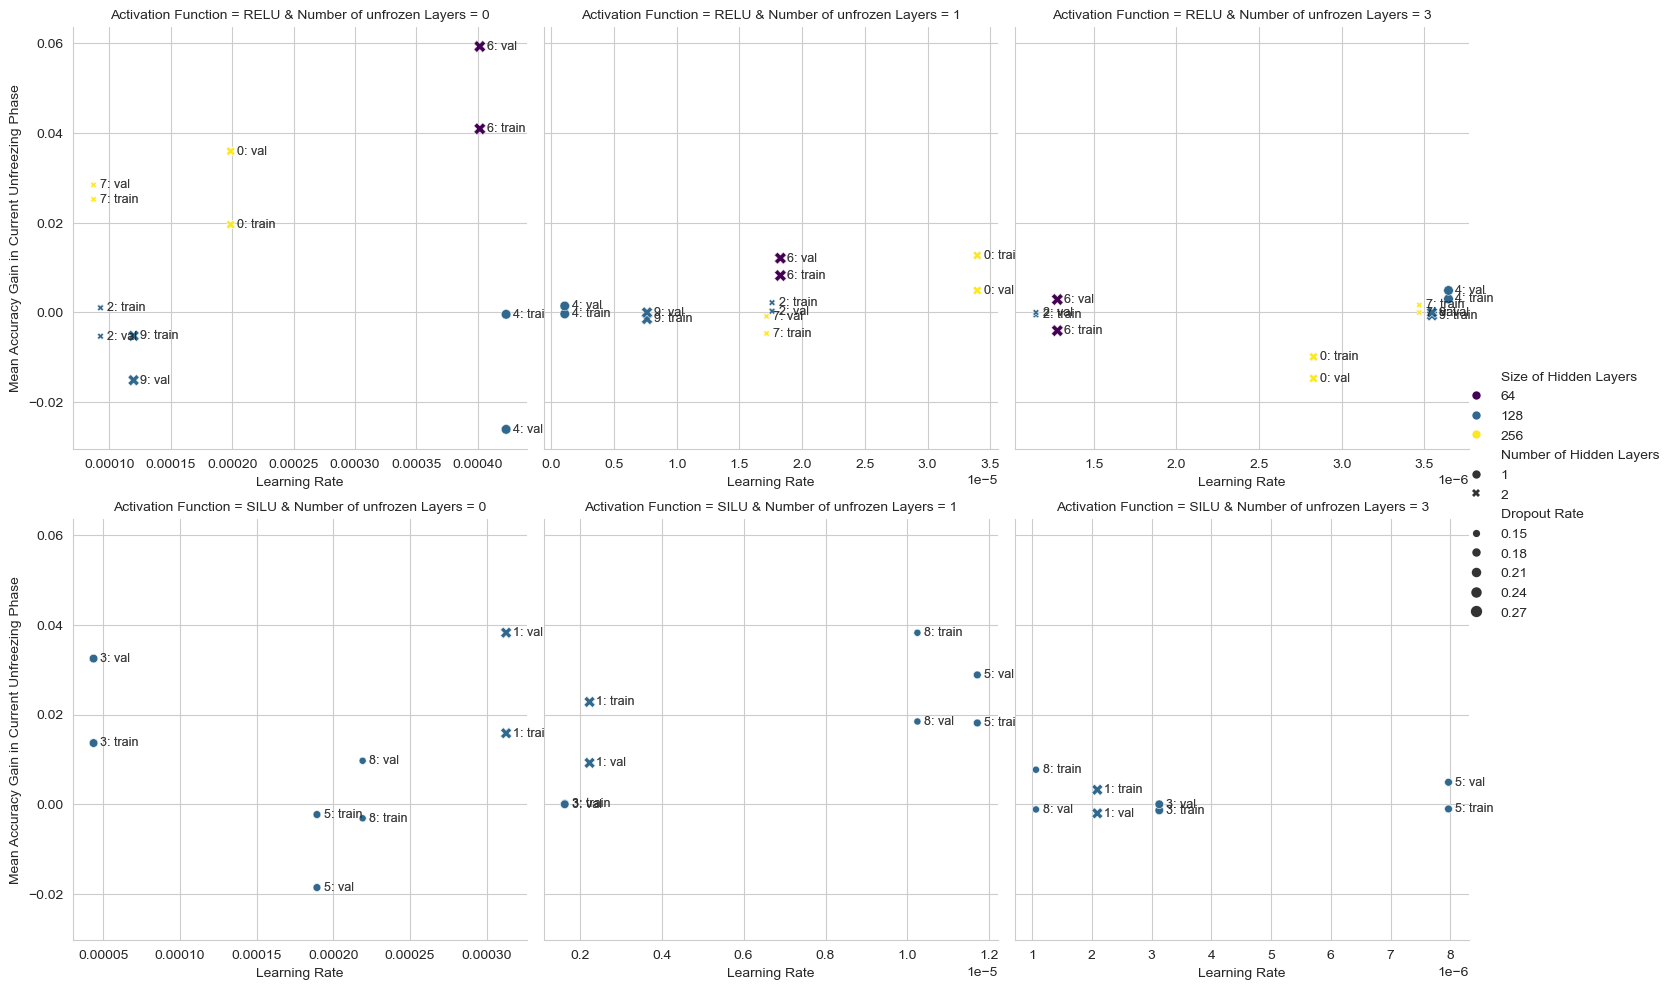

In [ ]:
g = sns.relplot(study_pd_tidy,
                x="learning_rate",
                y="acc_gain_phase",
                hue="params_hidden_size",
                style="params_hidden_num",
                size="params_dropout_rate",
                col="unfrozen_layers",
                row="params_activation",
                palette="viridis",
                facet_kws=dict(sharex=False));

# beautify the plot a bit
for (row_val, col_val), ax in g.axes_dict.items():
    # add the trial number and the set as annotations
    # Filter the data matching the current facet
    facet_data = study_pd_tidy[
        (study_pd_tidy["params_activation"] == row_val) &
        (study_pd_tidy["unfrozen_layers"] == col_val)
    ]

    # scale the annotations coordinates nicely:
    x_range = (ax.get_xlim()[1] - ax.get_xlim()[0])
    x_offset = 0.015 * (ax.get_xlim()[1] - ax.get_xlim()[0])
    for _, row in facet_data.iterrows():
        trial_number = row["number"]
        set_type = row["set"]
        ax.text(row["learning_rate"] + x_offset, row["acc_gain_phase"], f"{trial_number}: {set_type}",
                va="center", fontsize=9, alpha=0.7)

    # give nicer names and titles
    ax.title.set_text(f"Activation Function = {row_val.upper()} & Number of unfrozen Layers = {col_val}")
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Mean Accuracy Gain in Current Unfreezing Phase")

    new_legend_texts = {"params_hidden_size": "Size of Hidden Layers",
                        "params_hidden_num": "Number of Hidden Layers",
                        "params_dropout_rate": "Dropout Rate"}
    for text in g._legend.get_texts():
        if text.get_text() in new_legend_texts:
            text.set_text(new_legend_texts[text.get_text()])

While this plot is quite complex, it **confirms that the configuration of trial number 6 is one of the best**, especially for the phase where the bert layers are not yet unfrozen (top left plot), and also when only one layer is. At least when we do not want to switch from ReLu to SiLu and change the number of hidden layers to 1 during training, because only configurations with silu and only 1 hidden layer achieve better results (as the plot in the middle of the bottom shows). When we unfreeze 3 layers nearly no configuration showed good results, so we can also stick to that of number 6 and suppose it will converge with time.

The **results suggest that unfreezing additional layers beyond phase 2 (3 layers) does not provide consistent improvements**, possibly due to the learning rate being too high at that depth. **For final training, I cap unfreezing at this point and reduce the learning rate accordingly.**
While this training could be executed locally, I chose to run it on Vertex AI to demonstrate proficiency with cloud-based model development, aligning with common industry practices and allowing more guided experimentation as the model runs much faster when trained on the cloud.

### Training the Final Model on the Google Cloud

#### Preparing for Cloud Training

First we have to **write the training and the validation data to csv files** in order to make them available during cloud training without having to rerun the whole preprocessing pipeline again:

In [ ]:
from pathlib import Path
import os

parent_dir = Path("GCP/Datasets")

# export dataframes
tr_user_pd.to_csv(parent_dir/"train.csv", index=False)
val_user_pd.to_csv(parent_dir/"validation.csv", index=False)
test_user_pd.to_csv(parent_dir/"test.csv", index=False)

#### Cloud Training Adjustments

**Creating the Dataset and Training Script**

To prepare this model for cloud training and deployment (e.g., on Google Cloud Vertex AI), I slightly adjusted the dataset and added in the training script:
- **Simplification of the Dataset:** The dataset no longer calculates or returns engineered features (e.g., word count, character count).
- **Dataloader Flexibility:** A new `sampling` flag in the training script allows the dataloader to switch between random shuffling and balanced sampling. This adds another possiblity to address the imbalanced distribution of classes without relying on class weights.

**Cloud Training Adjustments of the Trainer Class**

I used nearly the same trainer class as it is shown above in the notebook. Here are the adjustments I developed for cloud training, offering more flexibility for experimentation, which became necessary to push the model's performance. The key features include:
- **Sampling Strategy Options:** The trainer now optionally ignores class weights, allowing for experimentation with the `WeightedRandomSampler` as an alternative strategy to tackle the high class imbalance. During hyperparameter tuning, I used only class weights to minimize sampling variability and ensuring a fair comparison across trials.
- **Restoring Best Weights per Unfreezing Phase:** An optional feature to restore the best weights so far was introduced, enabling the next training phase to start from the most optimal model state achieved up to that point.
- **Warm-Up Phase:** A warm-up phase can be configured for any number of epochs, helping stabilize the initial training period by ignoring best values within this phase.
- **Gradient Diagnostics:** A new method, `get_gradients_norm`, was added to monitor model diagnostics. The gradient norms for each batch are stored in the training history for analysis.
- **Efficient Memory Management:** Memory cleanup routines (`torch.mps.empty_cache()` and `gc.collect()`) are conditionally used only when the device is set to `mps`, as GPU/cloud environments typically manage memory more efficiently.
- **Improved Logging:** A dedicated `log` method was added for more concise and informative logging. While logs are stored in the history, they are printed every 5 epochs on the cloud by default. Logs with high importance (like unfreezing layers) are always printed.
- **Cloud Training Initialization:** For training on the cloud, I started with an initialization of the model using the results from the best hyperparameter tuning trial (trial number 6), as discussed earlier.

These adjustments made the trainer class more robust for cloud training while maintaining full compatibility with previous experiments. You can finde the complete `Training.py` script [here](https://github.com/Ryoshuu/Portfolio/blob/main/mbti-classification/GCP/Docker/Training.py).

#### Bash Pipeline for Automated Training on GCP

I created an automatic training pipeline composed of bash scripts, a Dockerfile, and a Python script. The pipeline ensures a smooth and efficient process for training on Google Cloud Vertex AI. Here’s an overview of the components:

- **pipeline.sh:** The main script that orchestrates the pipeline by running the subscripts. It also defines and exports the most important variables to be used by the subscripts.
- **upload_data.sh:** Creates a bucket in Google Cloud Storage and uploads the exported `train.csv` and `validation.csv` files to the data directory.
- **build_and_push_image.sh:** 
    - Creates an Artifact Repository, builds, and pushes the Docker container image to the repository. 
    - **Dockerfile:** Uses a lightweight base image for PyTorch and only installs essential packages (like `pandas`, `numpy`, `transformers`, and `google-cloud-storage`). It also includes the `Training.py` script within the container. This reduced the image size from nearly 10 GB (using the standard GCP PyTorch image) to just 3.5 GB.
    - **Training.py:** Optimized for training both on GCP (using CUDA) and locally (using MPS/CPU). It creates torch datasets from the uploaded `train.csv` and `validation.csv`, loads them into dataloaders, defines the model and trainer class, and generates a checkpoint containing the trained model and training history. The checkpoint is first saved in a temporary directory within the container and then uploaded to the Google Cloud Storage bucket in the `model-output` directory.
- **submit_training_job.sh:** Creates a training job on the Vertex AI Training Registry. The job utilizes one GPU (NVIDIA_TESLA_T4) and streams the training logs to print them in the notebook output. Depending on the job status, the pipeline either proceeds after training or breaks and logs an error if something goes wrong.
- **download_checkpoint.sh:** Downloads the checkpoint (created by `Training.py`) from the Google Cloud Storage bucket to the local `Checkpoints` directory, using a timestamp to ensure the checkpoint's uniqueness.
- **cleanup.sh:** 
    - First checks if the checkpoint exists in the `Checkpoints` directory. 
    - If found, it deletes the Google Cloud Storage bucket and the entire Artifact Registry to keep the cloud environment clean.
    - Note: If we wanted to create a prediction endpoint for continuous use (e.g., for an application or website), we would retain the checkpoint in Google Cloud Storage and develop a `Predict.py` script to handle model predictions.

I put extra care into clean, concise, yet informative logging, while also ensuring that my local home directory remains hidden for privacy when sharing this notebook.

You can find the cloud-specific training and evaluation code [here](https://github.com/Ryoshuu/Portfolio/tree/main/mbti-classification/GCP).

Now we run the bash pipeline and watch it perform in action. The following log includes information about each of the pipeline stages. I took great care to keep the outputs as concise as possible, while still retaining all relevant information for reproducibility, verification, and transparency.

In [ ]:
!bash GCP/bash_scripts/pipeline.sh  # lrs = [5e-5, 5e-6, 1e-6], last patience=10, adamw

Running script from ~/Documents/GitHub/MBTI/GCP/bash_scripts
=== Step 1: Data Upload to GCS ===
Creating gs://mbti-444713-bucket/...
Copying file://~/Documents/GitHub/MBTI/GCP/bash_scripts/../Datasets/train.csv [Content-Type=text/csv]...
/ [1 files][ 76.1 MiB/ 76.1 MiB]  619.4 KiB/s                                   
Operation completed over 1 objects/76.1 MiB.                                     
Copying file://~/Documents/GitHub/MBTI/GCP/bash_scripts/../Datasets/validation.csv [Content-Type=text/csv]...
/ [1 files][ 19.0 MiB/ 19.0 MiB]  610.8 KiB/s                                   
Operation completed over 1 objects/19.0 MiB.                                     
[OK] Data upload succeeded!
=== Step 2: Building and Pushing Docker Image ===
Creating Artifact Registry repository (if it doesn't exist)...
Create request issued for: [mbti-repo]
Waiting for operation [projects/mbti-444713/locations/europe-west3/operations/c
fd51971-7cb9-4d62-9162-62d2e0acb397] to complete...done.          

Wonderful — the bash pipeline, including the cloud training, finished successfully. Let us examine the resulting model. Since plots are often more informative than words, we create a function that plots the learning curves of accuracy and loss for both the training and the validation sets.

#### Evaluating the Final Model

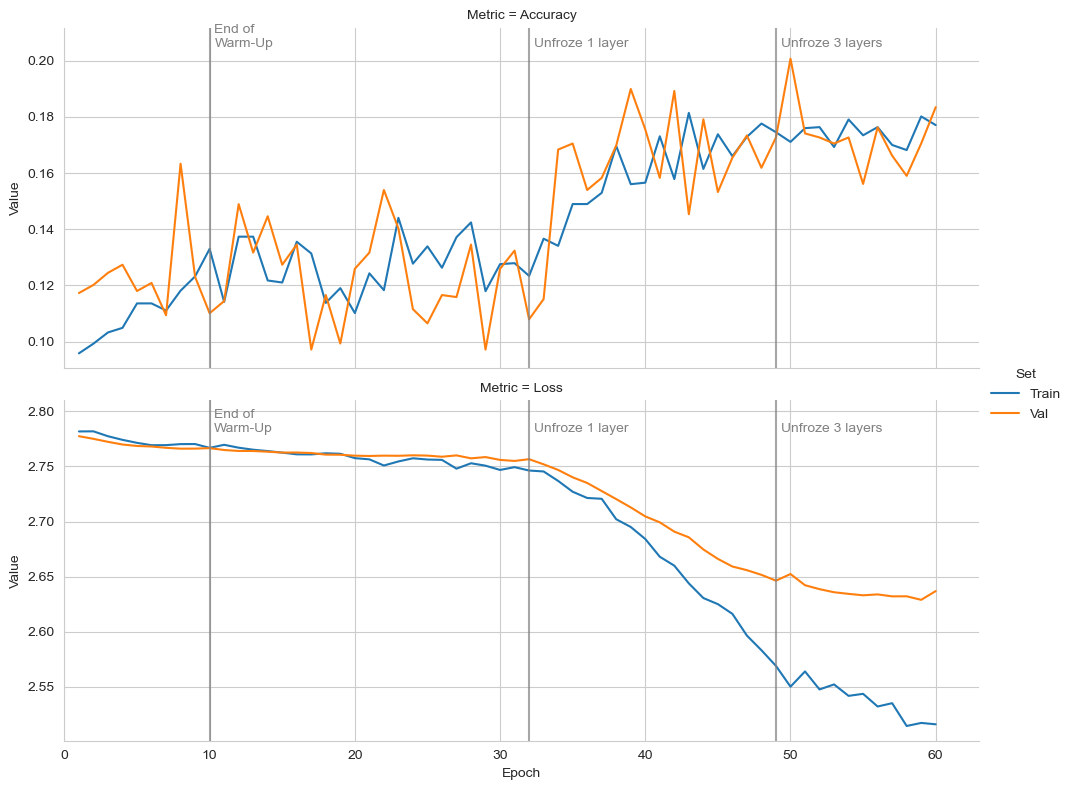

In [ ]:
def plot_learning_curves(checkpoint: str):
    PATH = Path("GCP/Checkpoints")

    model_checkpoint = torch.load(PATH/checkpoint, weights_only=True, map_location=device)

    hist = model_checkpoint["history"]

    df = pd.DataFrame({"Epoch": range(1, len(hist["train_acc"]) + 1),
                       "Accuracy_Train": hist["train_acc"], 
                       "Accuracy_Val": hist["val_acc"],
                       "Loss_Train": hist["train_loss"],
                       "Loss_Val": hist["val_loss"]})
    df_melted = df.melt("Epoch", var_name="Metric_Set", value_name="Value")
    df_melted[["Metric", "Set"]] = df_melted["Metric_Set"].str.split("_", expand=True)

    fig = sns.relplot(df_melted,
                      x="Epoch",
                      y="Value",
                      hue="Set",
                      col="Metric",
                      kind="line",
                      col_wrap=1,
                      facet_kws={"sharey": False},
                      height=4,
                      aspect=2.5);

    for ax in fig.axes.flat:
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        x_offset = 0.005 * (x_max - x_min)
        y_max_extended = y_max + (y_max - y_min) * 0.05

        y_text = y_max*0.995

        for log in hist["logs"]:
            if "Unfroze" in log:
                x = int(re.search(r"Epoch (\d*)/", log).group(1))
                ax.vlines(x, ymin=y_min, ymax=y_max_extended, color="grey", alpha=0.7)
                num_layers = re.search(r"Unfroze (\d) layer", log).group(1)
                note = f"Unfroze {num_layers} layer" if int(num_layers) == 1 else f"Unfroze {num_layers} layers"
                ax.annotate(text=note, xy=(x, y_max_extended), xytext=(x + x_offset, y_text), color="grey")
            elif "Warm-up finished" in log:
                x = int(re.search(r"after epoch (\d*)", log).group(1))
                ax.vlines(x, ymin=y_min, ymax=y_max_extended, color="grey", alpha=0.7)
                note = "End of\nWarm-Up"
                ax.annotate(text=note, xy=(x, y_max_extended), xytext=(x + x_offset, y_text), color="grey")

        ax.set_xlim(0, x_max)
        ax.set_ylim(y_min, y_max_extended)


plot_learning_curves("checkpoint-20250507-013210.pth")

We see that the training **benefits from the warm-up phase**: already at epoch 8 the model reached an **exceptionally high validation accuracy**, which it did not reach again before unfreezing the first BERT layer — suggesting that this early spike was most likely a "**lucky bump**". Not using a warm-up phase would have caused the trainer to unfreeze the next BERT layer too early, while the model was most likely still occupied with correctly applying the class weights in the phase with zero BERT layers unfrozen: In the upper plot we see the rough bumping around **0.12** while in the lower plot the class-weighted loss slowly but steadily and smoothly declines.

Nevertheless, from epoch 20 on, a **tiny bit of overfitting** started to show (but notice that the range in the lower plot is really small). The plots also reveal that the **staged unfreezing strategy successfully allowed BERT to gradually adapt while avoiding large gradient shocks early in training**: In the unfreezing phase where only one BERT layer was unfrozen the main part of the learning happened, but simultaneously the overfitting increased. This continued in the last unfreezing phase, but the model also achieved its **best validation accuracy** while the training loss became a bit bumpier. However, trying to fix this with lower learning rates for this final phase did not lead to smoother or better results.

We also observe a **short bump** both in validation accuracy and in validation loss after unfreezing the last layers. A possible explanation is that the model briefly shifted towards stronger majority class predictions, which improves accuracy, yielding the global maximum, but worsens class-weighted loss. **Looking back**, one could consider using validation loss as the dynamic unfreezing criterion to avoid such temporary effects. However, this might also lead to longer training and potentially stronger overfitting, given the relatively smooth overall loss convergence. The trainer used in this run restored the best weights based on validation accuracy; saving the full final model state might have allowed a closer inspection of this phase. **This option was not yet implemented in the trainer class at the time of cloud training.** Interestingly, in the very last epoch, the validation loss and accuracy spiked once more on a smaller scale, too.

Therefore, I selected this model as final: **validation loss shows good convergence, and overfitting remains limited.**

But we also want to examine the true training accuracy, the confusion matrices and the macro accuracy/recall for this last model.

In [ ]:
final_model_checkpoint = torch.load("GCP/Checkpoints/checkpoint-20250507-013210.pth",
                                    weights_only=True, 
                                    map_location=device)

# instantiate a new model from the checkpoint with the same arguments like the saved one
final_loaded_model = BertClassifier(**final_model_checkpoint["_init_args"])

# load the weights 
final_loaded_model.load_state_dict(final_model_checkpoint["model_state_dict"])

<All keys matched successfully>

For evaluation we have to use the exact data as the model was trained on, so we load that dataset from disk. We did not use other features and have to reload the dataset accordingly:

In [ ]:
cloud_train_pd = pd.read_csv("GCP/Datasets/train.csv")

cloud_train_dataset = PostsDataset(cloud_train_pd, tokenizer, max_length=512,
                                   other_feature_cols=None,
                                   post_feature_col=post_feature_col,
                                   labels_col=labels_col)

tr_probs, tr_preds, tr_trues = final_loaded_model.predict(dataset=cloud_train_dataset, use_tqdm=False)

get_acc_from_tensors(tr_trues, tr_preds, "training set")

Accuracy on the training set: 22.01%


This is noticeably higher than during training (0.17), due to the dropout layers. We want to check how the predictions are distributed across the classes, so we take a look at the confusion matrix.

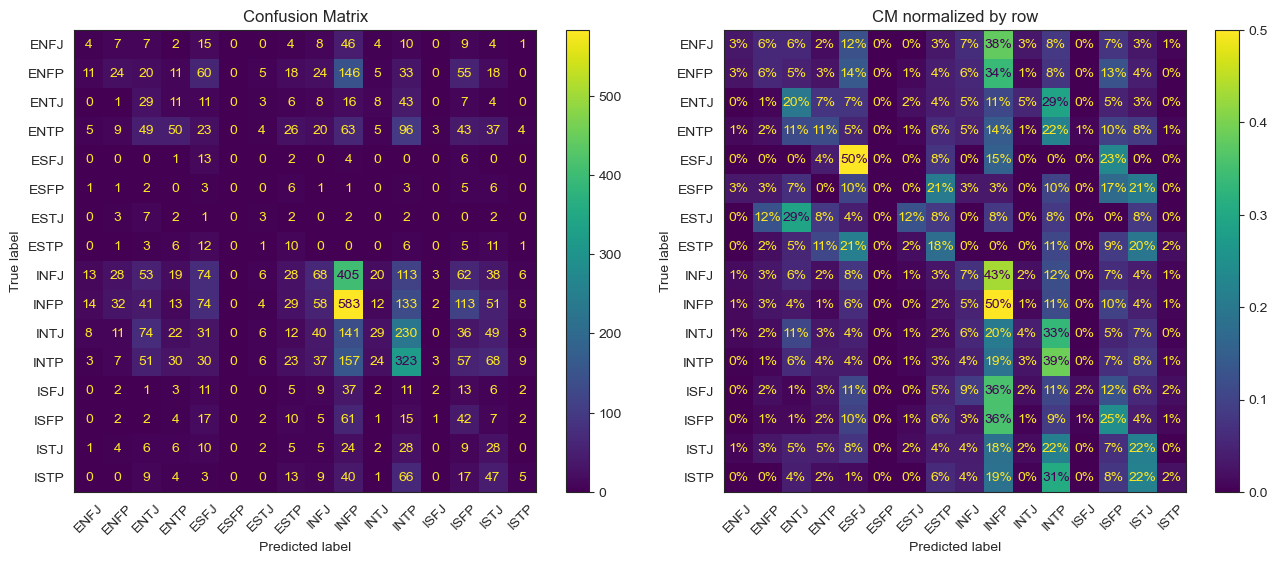

In [ ]:
PlotConfusionMatrix(tr_trues.to("cpu"), tr_preds.to("cpu"))

The most **frequent class still shows a vertical stripe, but there is also a slightly lighter diagonal line from the top left to the bottom right corner** in the plot on the right indicating that **the model could recognize the correct classes at least in some cases of all classes**. An exception to this is the type ESFP, which the model mostly confused with similar types like ESTP or ISFP (but also ISTJ). Intuitive and feeling types (N and F) were mostly confused with the most frequent class INFP, no matter if it was ENFJ, ENFP or INFJ. The same holds true for introverted and feeling (I and F) types ISFJ or ISFP.

In general, it is noticeable that **classes were often confused with minimal pairs** that differ in only one letter. ENFP, for example, with INFP or ENTP, or ESFP with ESTP and ISFP. This shows that the **model already had a good clue which type it could be**, but the **overlap between the classes makes it really tough to distinguish** them: each type shares 3 traits with 4 other types, 2 traits with 6 other types, and 1 trait with 4 other types. We can support that these overlaps are part of the difficulty to predict the correct type when we look at the opposite diagonal line from the top right to the bottom left corner, which represents the confusions of types with which a given type does not share any trait at all (for each type there is exactly one such opposite type): here we find a lot of zeros or only small numbers.

Reflecting on this one might **consider predicting the trait for each of the 4 preference pairs independently** and then combine the predictions for each preference pair to the whole type. While we can confidently expect that the model should learn the distinctions between the traits of each pair much better, we would **need relatively high accuracies for the correct prediction of each pair** to surpass the achieved validation accuracy of 20.1%: A (geometric) mean accuracy of 67% over the 4 types would be necessary and **if only one of these pairs is hard to predict, the overall prediction would become much worse**. For example, if three pairs could be predicted with a high accuracy of 0.8 and only one with an accuracy less than 0.39 the overall prediction would become worse. That is why **I did not follow that approach in this notebook**. However, of course, we could then directly identify the pair with the highest insecurity. So it could be worth a try but it also depends on the task at hand.

We quantify how well the classes could be distinguished in one number with our normalized accuracy (macro accuracy/recall):

In [ ]:
formatted_na(tr_trues, tr_preds)

16.95%


This is nearly 23% lower than the unweighted accuracy, so the impression from the confusion matrix is correct and **the most frequent classes (INFP and INTP) are still pulling the model in their direction**. We would **expect similar results for the validation set**. We already know the validation accuracy from the printed logs, but for completeness and as a small crosscheck I print it here again, as we need the predicted values for the confusion matrices anyway:

In [ ]:
cloud_val_pd = pd.read_csv("GCP/Datasets/validation.csv")

cloud_val_dataset = PostsDataset(cloud_val_pd, tokenizer, max_length=512,
                                 other_feature_cols=None,
                                 post_feature_col=post_feature_col,
                                 labels_col=labels_col)

val_probs, val_preds, val_trues = final_loaded_model.predict(dataset=cloud_val_dataset, use_tqdm=False)

get_acc_from_tensors(val_trues, val_preds, "validation set")

Accuracy on the validation set: 20.07%


This is a bit lower than the training accuracy of 22%, so we have a little bit of overfit here, but still in an acceptable range. We also want to check the confusion matrix for the validation set:

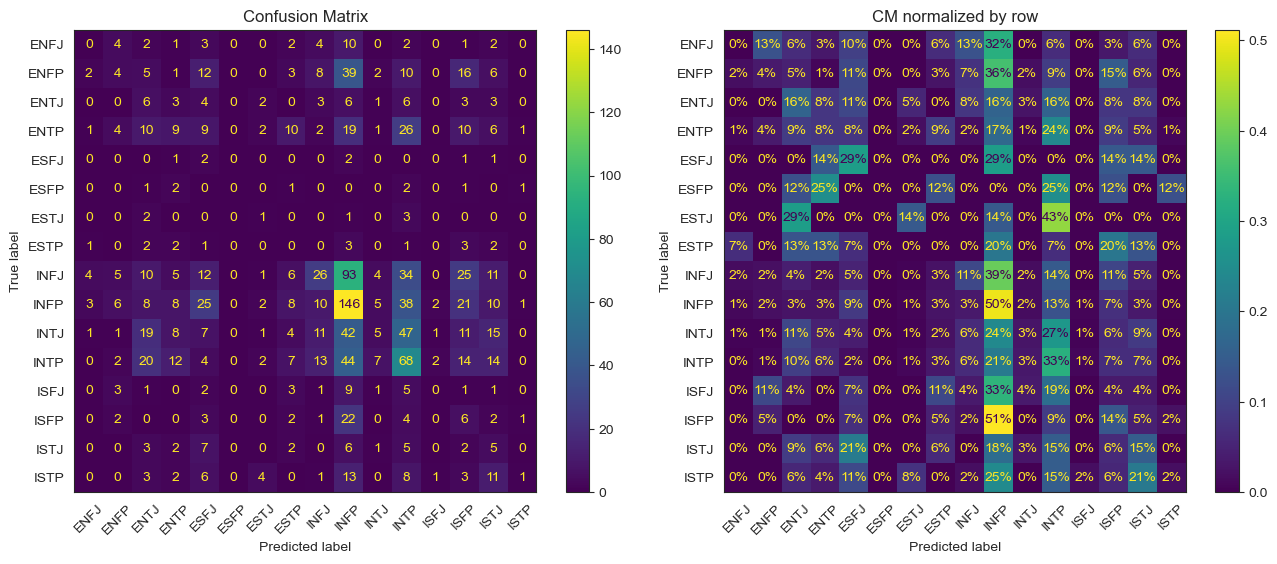

In [ ]:
PlotConfusionMatrix(val_trues.to("cpu"), val_preds.to("cpu"))

The normalized matrix looks relatively similar to the one of the training set. The model seems to **rely even more on frequent classes** like **INFP** and **INTP**. We compute the normalized accuracy for the validation set as well:

In [ ]:
formatted_na(val_trues, val_preds)

12.39%


The difference to the validation accuracy (20.07%) is larger than on the training set, so on new data the model actually relies even more on the most frequent classes.

Finally, let us evaluate how well the model performs on the test set we set apart at the beginning of this notebook:

In [ ]:
cloud_test_dataset = PostsDataset(test_user_pd, tokenizer, max_length=512,
                                  other_feature_cols=None,
                                  post_feature_col=post_feature_col,
                                  labels_col=labels_col)

test_probs, test_preds, test_trues = final_loaded_model.predict(dataset=cloud_test_dataset, use_tqdm=False)

get_acc_from_tensors(test_trues, test_preds, "test set")

Accuracy on the test set: 20.95%


The good news is that this is in between the values of the training and the validation set, so the model generalizes well and achieves a **test accuracy that is over three times higher than the random baseline of 6.25%**. But of course we want to know how big the normalized accuracy is here, too:

In [ ]:
formatted_na(test_trues, test_preds)

11.15%


However, the macro accuracy is lower, reflecting the model’s stronger performance on frequent classes and weaker performance on rare ones. As we have already used weighting which works on the loss function **it could be beneficial to additionally increase the batch size**, so the model sees rarer classes more often in one batch which might help the weights to influence learning. Maybe this would need more resources on the cloud than just one GPU, but it could be worth an attempt.

Another approach – of course – would be to use **oversampling** and repeatedly draw instances from all classes except the most frequent one till each class has the same number of instances like the most frequent class, so in each batch we could expect the same number of instances for each class. However, as already mentioned **this did not lead to better results during experimentation**.

#### Final Model Configuration and Reasoning

While initial hyperparameter tuning (on layer size, activation, optimizer, dropout) provided a strong baseline, the final model configuration was reached through **informed iteration** rather than pure automated search.

In particular:
- **Dynamic unfreezing** was introduced, with careful control over which BERT layers to unfreeze and when.
- I observed that **restoring the best weights after each unfreezing phase introduced instability**, and disabling this led to significantly smoother validation performance.
- Learning rates were adjusted per unfreezing phase based on observed training behavior:
  - A **lower learning rate was used after each unfreezing step** to allow stable adaptation of newly trainable BERT layers.
  - These adjustments were **motivated by validation accuracy trends**, not discovered via tuning trials alone.
- **Patience was increased** to give the model time to adapt to smaller learning rates, especially after unfreezing.

This approach reflects a more realistic training process, where **domain knowledge, diagnostics, and optimization dynamics** guide model improvement beyond what tuning libraries can achieve alone. 

Here are the final model's initation arguments: 

In [ ]:
PATH = Path("GCP/Checkpoints")
checkpoint = "checkpoint-20250507-013210.pth"
device = torch.device("mps")
model_checkpoint = torch.load(PATH/checkpoint, weights_only=True, map_location=device)

model_checkpoint["_init_args"]

{'other_features_dim': 0,
 'hidden_num': 1,
 'hidden_size': 64,
 'num_classes': 16,
 'dropout_rate': 0.2,
 'activation_name': 'silu',
 'use_additional_features': False}

If we wanted to deploy this model for a real-world application, we would **train it once again with this set-up on the full non-test data** (i.e., training and validation sets combined) to provide the model with more data to learn from, and evaluate it afterwards on the test set. We would then **create an endpoint on Google Cloud along with a prediction script**, which could be integrated into the application (or website) to make predictions on new user inputs, that would be preprocessed in the same way as during training. 

Since keeping such endpoints active in the cloud is **fairly expensive, I only did this once for testing purposes** and deleted the endpoint afterwards.

The model building section of this notebook comes to an end here. It is now time to review potential further improvements, reflect on the dataset, and draw some conclusions.

## What Else Could Be Done
Here I summarize and add a few ideas for improvement that occurred during the creation of this notebook but could not be tested due to limited resources.

**Data-level improvements**
- Perform even **more data cleaning**, e.g., detect broken URLs (using a dedicated model, either pretrained or self-trained via data augmentation such as random space insertions), or exclude posts written in languages other than English.

**Model input and preprocessing**
- **Hypertune the minimal allowed posts' length**: I used a value of 250 and we could go up to 512 (BERT's limit). This involves a tradeoff between dataset evenness, which typically stabilizes training, and data loss due to sequence truncation.
- **Use chunks of token length 512 and calculate the mean of their representations**: Splitting long posts into multiple 512-token chunks and averaging their representations is computationally efficient but may blur sequence-specific signals.
- **Use sliding windows to generate more training instances**: For longer posts, we could split them into consecutive 512-token windows (each inheriting the same MBTI label) and apply soft voting across predictions for all windows. Probabilities can be summed or averaged (optionally weighted to account for smaller final chunks), and the class with the highest aggregated score can be selected as final prediction. We could also consider only using exactly 512-token chunks to improve stability during training.
  This approach can be further extended by applying overlapping sliding windows (e.g., with a stride of 256 tokens), which would generate additional training instances while preserving context overlap.

**Training and modeling strategies**
- **Increase the batch size** to stabilize class weighting and gradient estimation, though this would require additional compute resources.
- **Use models specialized on long sequences**, e.g., Longformer or BigBird, which allow processing longer contexts but typically demand more memory or smaller batch sizes.
- **Predict the traits of each preference pair directly**: Instead of predicting the full MBTI type, we could predict each preference pair separately (resulting in four output neurons). However, this might introduce error propagation between subtasks and does not necessarily guarantee better overall performance.

Overall, these extensions offer multiple ways to further explore tradeoffs between data utilization, model capacity, resource constraints, and final predictive stability.


## The Dataset from a Sociological and Methodological Perspective  
**Or: Why It Is Hard to Predict the Types**

While the model achieved an accuracy approximately three times higher than the weighted baseline of 6.25%—**suggesting that there is some core structure to the MBTI typology**—it still fails to classify correctly in roughly four out of five cases. **This has good reasons:**

**The Data is Not Highly Separable**

There are 16 different MBTI types, and for high accuracy scores it would be necessary that there are very typical patterns for each personality type—either in word usage or writing styles. Since each characteristic of the four preference pairs (e.g., Extraversion/Introversion) appears in eight of the sixteen types, the types are already highly intertwined and non-distinct. **As a result, models must implicitly learn the specific quality of each trait and then combine these predictions to infer the full type.** And that is where the next reason comes into play.

**Methodological Weaknesses**

As already mentioned in the introduction, the MBTI typology is heavily **criticized for being pseudo-scientific**, especially due to a lack in **validity and reliability**. If the MBTI fails to reliably measure the constructs it claims to (low **construct validity**), and repeated testing does not yield consistent results for the same individual (low **reliability**), then **it is questionable whether machine learning models can learn any stable, generalizable patterns from such data.**

**Personality Types Are a Problematic Concept in General**

While 16 personality types sound like a granular concept, **it certainly is not when it comes to humans**: There are over 8 billion people on Earth now. The idea that each of them could clearly be classified into one of the 16 types of MBTI is almost **illusory**.

Furthermore, **sociology and social psychology have shown convincingly that a large proportion—if not the majority—of human behavior is shaped by situational and cultural factors**. Remember the **Stanford Prison Experiment** or the **Milgram Experiments**—but even subtle things, like the **title of a game** (where the rules stay the same), can significantly change our behaviour, no matter how we define our own personality (see also **Mischel's personality paradox**).

More widely accepted instruments like the **Big Five** avoid strict categorization and instead assign individuals continuous scores across five trait dimensions. However, **even this model has faced critique** for being culturally limited and somewhat atheoretical.

**Resulting Models Should Be Deployed on More Diverse Data With Care**

This one is not a reason for low accuracy but another important **methodological issue**. It is hard to infer the **social stratification** from the data, but the fact that it comes from a website where people chat about personality types means that **they are not representative of the global population**. Not everyone enjoys reflecting on personality types and writing about them in a forum.

This suggests that the dataset's participants are more likely from the **middle or upper class**, meaning they are likely **financially secure and formally educated**.  
Studies suggest that **men are more active in online forums**, so it is likely that the **gender distribution** in this dataset is also skewed.  
The language in the forum is English, so we would expect most of the authors to come from **English-speaking countries**, which are **not representative of the Western world, let alone the global population**.  
While I cannot prove it definitively, the **tone and content of many posts suggest that the authors are relatively young**, and their **age distribution likely does not reflect that of the global population**.

**All these aspects substantially influence the writing style and even the word choice of a person**, so resulting models are supposed to be biased by the data. However, **neural net models trained on this dataset could still serve as a starting point for transfer learning**—*if* more diverse data becomes available.

## Conclusions

In this project, I explored MBTI text data and developed a preprocessing pipeline with PySpark for data cleaning and feature engineering. My initial goal was to predict a user's MBTI type based on a single post. Several traditional machine learning models were tested but performed poorly, while a BERT-based classifier showed improved results. 

Due to methodological challenges, I shifted to predicting a user’s type based on all their posts at once. In this setting, an XGBoost model surprisingly achieved strong results by leveraging simple word count features. However, since such models rely heavily on long texts — which may not always be available in real-world scenarios — I also trained a BERT-based classifier, which requires only 512 tokens and can additionally capture writing styles and linguistic patterns.

The training process involved various advanced elements, including dynamic unfreezing, device and memory management, cloud orchestration via a pipeline of bash scripts, and careful logging. Although the final model's validation accuracy remains modest (but still more than three times better than random guessing), it demonstrated solid generalization performance on the test set. The experiments also illustrated the importance of fine-tuning strategies, such as whether to restore best weights after each phase or how to adapt learning rates depending on training dynamics.

While there are still several options for further improvements, I would remain cautious about applying these models directly in real-world applications. The dataset exhibits biases, and the MBTI framework itself is widely debated. Nevertheless, the fact that the models consistently outperform random guessing suggests that at least some meaningful patterns are being captured.

Beyond predictive performance, this project also served as a valuable exercise in designing and orchestrating end-to-end machine learning workflows under realistic resource constraints.